# Benchmark TPC-DS 10

This notebook contains work pertatining to benchmark metrics and data visualization / descriptions. The chosen dataset are extracts from Oracle internal tables/views, attempting to benchmarking the TPC-DS schema transaction load across a variety of loads denoted below:
* 10GB

This notebook describes the TPC-DS transaction workload in terms of query / transaction variety, resource consumption, identification of top consumers, and more.

![TPC-DS Component Visualization](components/TPC-DS benchmark components.png)

In [1]:
#
# Module Import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tpcds='TPCDS10'
#
# Open Data
rep_execution_plans_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Benchmark/' + tpcds + '/rep_execution_plans.csv'
rep_explain_plans_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Benchmark/' + tpcds + '/rep_explain_plans.csv'
#
rep_execution_plans_df = pd.read_csv(rep_execution_plans_path)
rep_explain_plans_df = pd.read_csv(rep_explain_plans_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
rep_execution_plans_headers = prettify_header(rep_execution_plans_df.columns.values)
rep_explain_plans_headers = prettify_header(rep_explain_plans_df.columns.values)
#
# Replace original headers with a prettified version of the same column list
rep_execution_plans_df = pd.read_csv(rep_execution_plans_path, names=rep_execution_plans_headers)
rep_explain_plans_df = pd.read_csv(rep_explain_plans_path, names=rep_explain_plans_headers)
rep_execution_plans_df.drop(rep_execution_plans_df.index[0],inplace=True)
rep_explain_plans_df.drop(rep_explain_plans_df.index[0],inplace=True)
#
print("REP_EXECUTION_PLAN Headers:\n")
[print(header) for header in prettify_header(rep_execution_plans_df.columns.values)]
print(rep_execution_plans_df.head())
print("\n---------------------------------------------------------------------------------\n")
print("REP_EXPLAIN_PLAN Headers:\n")
[print(header) for header in prettify_header(rep_explain_plans_df.columns.values)]
print(rep_explain_plans_df.head())

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


REP_EXECUTION_PLAN Headers:

SQL_TEXT
SQL_FULLTEXT
SQL_ID
SHARABLE_MEM
PERSISTENT_MEM
RUNTIME_MEM
SORTS
LOADED_VERSIONS
OPEN_VERSIONS
USERS_OPENING
FETCHES
EXECUTIONS
PX_SERVERS_EXECUTIONS
END_OF_FETCH_COUNT
USERS_EXECUTING
LOADS
FIRST_LOAD_TIME
INVALIDATIONS
PARSE_CALLS
DISK_READS
DIRECT_WRITES
BUFFER_GETS
APPLICATION_WAIT_TIME
CONCURRENCY_WAIT_TIME
CLUSTER_WAIT_TIME
USER_IO_WAIT_TIME
PLSQL_EXEC_TIME
JAVA_EXEC_TIME
ROWS_PROCESSED
COMMAND_TYPE
OPTIMIZER_MODE
OPTIMIZER_COST
OPTIMIZER_ENV
OPTIMIZER_ENV_HASH_VALUE
PARSING_USER_ID
PARSING_SCHEMA_ID
PARSING_SCHEMA_NAME
KEPT_VERSIONS
ADDRESS
TYPE_CHK_HEAP
HASH_VALUE
OLD_HASH_VALUE
PLAN_HASH_VALUE
FULL_PLAN_HASH_VALUE
CHILD_NUMBER
SERVICE
SERVICE_HASH
MODULE
MODULE_HASH
ACTION
ACTION_HASH
SERIALIZABLE_ABORTS
OUTLINE_CATEGORY
CPU_TIME
ELAPSED_TIME
OUTLINE_SID
CHILD_ADDRESS
SQLTYPE
REMOTE
OBJECT_STATUS
LITERAL_HASH_VALUE
LAST_LOAD_TIME
IS_OBSOLETE
IS_BIND_SENSITIVE
IS_BIND_AWARE
IS_SHAREABLE
CHILD_LATCH
SQL_PROFILE
SQL_PATCH
SQL_PLAN_BASELINE
P

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1,3,6,9,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,30,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dataset Description

Statistical calculations:

* Column Names
* Dataframe Row Counts
* Mean (were applicable)
* Standard Dev (were applicable)
* Quartile Percentile
* Min / Max

In [2]:
print('\n-----------------------------------------------------------\nDataframe Row Count: REP_EXECUTION_PLANS - ' + str(len(rep_execution_plans_df)))
print('Dataframe Row Count: REP_EXPLAIN_PLANS - ' + str(len(rep_explain_plans_df)) + '\n-----------------------------------------------------------\n')
#
print('REP_EXECUTION_PLANS:')
print(rep_execution_plans_df.describe())
print('\n\nREP_EXPLAIN_PLANS:')
print(rep_explain_plans_df.describe())


-----------------------------------------------------------
Dataframe Row Count: REP_EXECUTION_PLANS - 1368
Dataframe Row Count: REP_EXPLAIN_PLANS - 22318
-----------------------------------------------------------

REP_EXECUTION_PLANS:
                                                 SQL_TEXT  \
count                                                1368   
unique                                                195   
top      create /*ICS5200_MONITOR_HINT*/ table s_catal...   
freq                                                   23   

                                             SQL_FULLTEXT         SQL_ID  \
count                                                1368           1368   
unique                                                195            195   
top      create /*ICS5200_MONITOR_HINT*/ table s_catal...  9h3zgv5nzkzym   
freq                                                   23             23   

       SHARABLE_MEM PERSISTENT_MEM RUNTIME_MEM SORTS LOADED_VERSIONS  \
cou

# Dataset Extraction

The above datasets were extracted from the following user defined tables:
* REP_EXECUTION_PLANS 
* REP_EXPLAIN_PLANS 

Each table corresponds to an Oracle defined table, whose sole function is to offload data from Oracle defined tables (which tend to have a retention period) into a user defined table.

For table REP_EXECUTION_PLANS, the Oracle V$SQL view (https://docs.oracle.com/cd/B19306_01/server.102/b14237/dynviews_2113.htm#REFRN30246) was opted for. This oracle view is particularly useful at giving a fine grained, in-depth look at resource consumption per active SQL. The specific query used can be found further below.

For table REP_EXPLAIN_PLANS, the Oracle PLAN_TABLE temporary table (https://docs.oracle.com/cd/B28359_01/server.111/b28320/statviews_5127.htm#REFRN29510) was opted for. This oracle temporary table is particularly useful at capturing each step carried out to compute an SQL query. The specific query used can be found further below.

``` sql
/*
REP_EXECUTION_PLANS Metric Extraction Pseudocode
*/
select * 
from(
  select vs.*, 
  		'place_holder_transaction_name', 
  		'place_holder_md5_sum', 
  		'place_holder_iteration_run', 
  		'place_holder_gathered_stats'
  from v$sql vs
  where sql_text like '%" + self.__execution_plan_hint + "%'
  and sql_text not like '%v_sql%'
  and sql_text not like '%V_SQL%'
  order by last_active_time desc
) where rownum <= 1;


/*
REP_EXPLAIN_PLANS Metric Extraction Pseudocode
*/
select   pt.STATEMENT_ID
		,pt.PLAN_ID
		,pt.TIMESTAMP
		,pt.REMARKS
		,pt.OPERATION
		,pt.OPTIONS
		,pt.OBJECT_NODE
		,pt.OBJECT_OWNER
		,pt.OBJECT_NAME
		,pt.OBJECT_INSTANCE
		,pt.OBJECT_TYPE
		,pt.OPTIMIZER
		,pt.SEARCH_COLUMNS
		,pt.ID
		,pt.PARENT_ID
		,pt.depth
		,pt.POSITION
		,pt.COST
		,pt.CARDINALITY
		,pt.BYTES
		,pt.OTHER_TAG
		,pt.PARTITION_START
		,pt.PARTITION_STOP
		,pt.PARTITION_ID
		,pt.DISTRIBUTION
		,pt.CPU_COST
		,pt.IO_COST
		,pt.TEMP_SPACE
		,pt.ACCESS_PREDICATES
		,pt.FILTER_PREDICATES
		,pt.TIME
		,'transaction_name',
		'md5_sum', 
		'iteration_run', 
		'gathered_stats'
from plan_table pt
where plan_id = (
  select max(plan_id)
  from plan_table
  where to_date(to_char(timestamp,'MM/DD/YYYY'),'MM/DD/YYYY') = to_date(to_char(sysdate,'MM/DD/YYYY'),'MM/DD/YYYY')
)
order by id;
```

# Benchmark Resource Visualization

The following section plots resource metrics pertaining to top consumer transaction queries, spread across a particular TPC-DS Workload. Each schedule is the same, and follows this pattern:

* query_1.sql
* ...
* query_99.sql
* dml_1.sql
* ...
* dml_42.sql

In [3]:
def plot_benchmark_distribution(column=None, tpc_type=None):
    """
    Plots line graph.
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    #
    # Sort by order of execute time
    df = rep_execution_plans_df.sort_values(by=['LAST_LOAD_TIME'])
    #
    # Convert to float
    df[column]=df[column].astype(float)
    #
    # DISK_READS over benchmark execution
    ts = pd.Series(df[column].values, index=pd.date_range(start=df['LAST_LOAD_TIME'].values.min(),periods=len(df['LAST_LOAD_TIME'])))
    ts.plot()
    plt.xticks([])
    plt.ylabel(column)
    plt.xlabel('Benchmark Duration')
    plt.title(tpc_type + ' ' + str(column) + ' between ' + str(df['LAST_LOAD_TIME'].values.min()) + ' and ' + str(df['LAST_LOAD_TIME'].values.max()))
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
def plot_plan_ratios(column=None, tpc_type=None):
    """
    Plots Pie Chart
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    #
    df = rep_explain_plans_df.groupby([column])[column].count()
    #
    # Sort by operation counts
    series = pd.Series(df.values, index=df.index, name='series')
    series.plot.pie(figsize=(6, 6))
    plt.xticks([])
    plt.ylabel(column)
    plt.title(tpc_type + ' ' + str(column) + ' Ratio')
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.legend()
    plt.show()
#
def plot_optimizer_stats_contrast(column=None, tpc_type=None):
    """
    Plots Bar Graph which contrasts with/without optimizer stats on underlying schema
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    #
    # Convert to float
    df = rep_execution_plans_df
    df[column]=df[column].astype(float)
    #
    df = df.groupby(['GATHERED_STATS'])[column].mean()
    df.plot(kind='bar');
    plt.ylabel(column)
    plt.xlabel('GATHERED_STATS')
    plt.title(tpc_type + ' ' + str(column))
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
def top_consumer_histogram(table=None, column=None, tpc_type=None, gathered_stats=None):
    """
    Plots histogram for all queries, for a particular resource column. 
    """
    if table is None or column is None or tpc_type is None or gathered_stats is None:
        raise ValueError('Parameters were declared incorrectly')
    tpc_type = tpc_type.upper()
    gathered_stats = str(gathered_stats).title()
    table=table.lower()
    #
    # Convert to float
    if table == 'rep_execution_plans':
        df = rep_execution_plans_df
    elif table == 'rep_explain_plans':
        df = rep_explain_plans_df
    else:
        raise ValueError('Table Name not supported!')
    df[column]=df[column].astype(float)
    #
    df = df.where(df['GATHERED_STATS'] == gathered_stats)
    df = df.groupby(['TPC_TRANSACTION_NAME'])[column].sum()
    #
    df.plot(kind='hist',bins=141)
    plt.ylabel(column)
    plt.xlabel(tpc_type + ' transaction range')
    plt.title(tpc_type + ' ' + str(column) + " - Optimizer Stats Gathered: " + gathered_stats)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
def top_consumer_bar(table=None, column=None, tpc_type=None, gathered_stats=None, top_n=20):
    """
    Plots barchart for top N queries, for a particular resource column. 
    """
    if table is None or column is None or tpc_type is None or gathered_stats is None:
        raise ValueError('Parameters were declared incorrectly')
    tpc_type = tpc_type.upper()
    gathered_stats = str(gathered_stats).title()
    table=table.lower()
    #
    # Convert to float
    if table == 'rep_execution_plans':
        df = rep_execution_plans_df
    elif table == 'rep_explain_plans':
        df = rep_explain_plans_df
    else:
        raise ValueError('Table Name not supported!')
    df[column]=df[column].astype(float)
    #
    df = df.where(df['GATHERED_STATS'] == gathered_stats)
    df = df.groupby(['TPC_TRANSACTION_NAME'])[column].sum()
    df = df.sort_values(ascending=False).head(top_n)
    #
    df.plot(kind='bar',x=df.values,y=['TPC_TRANSACTION_NAME'])
    plt.ylabel(column)
    plt.xlabel(tpc_type + ' transaction range')
    plt.title(tpc_type + ' ' + str(column) + " - Top [" + str(top_n) + "] Optimizer Stats Gathered: " + gathered_stats)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()

### Shareable Memory Distribution

Amount of shared memory used by the child cursor (in bytes)

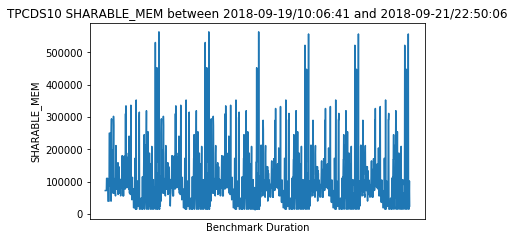

In [4]:
plot_benchmark_distribution(column="SHARABLE_MEM", tpc_type=tpcds)

### Persistent Memory Distribution

Fixed amount of memory used for the lifetime of the child cursor (in bytes)

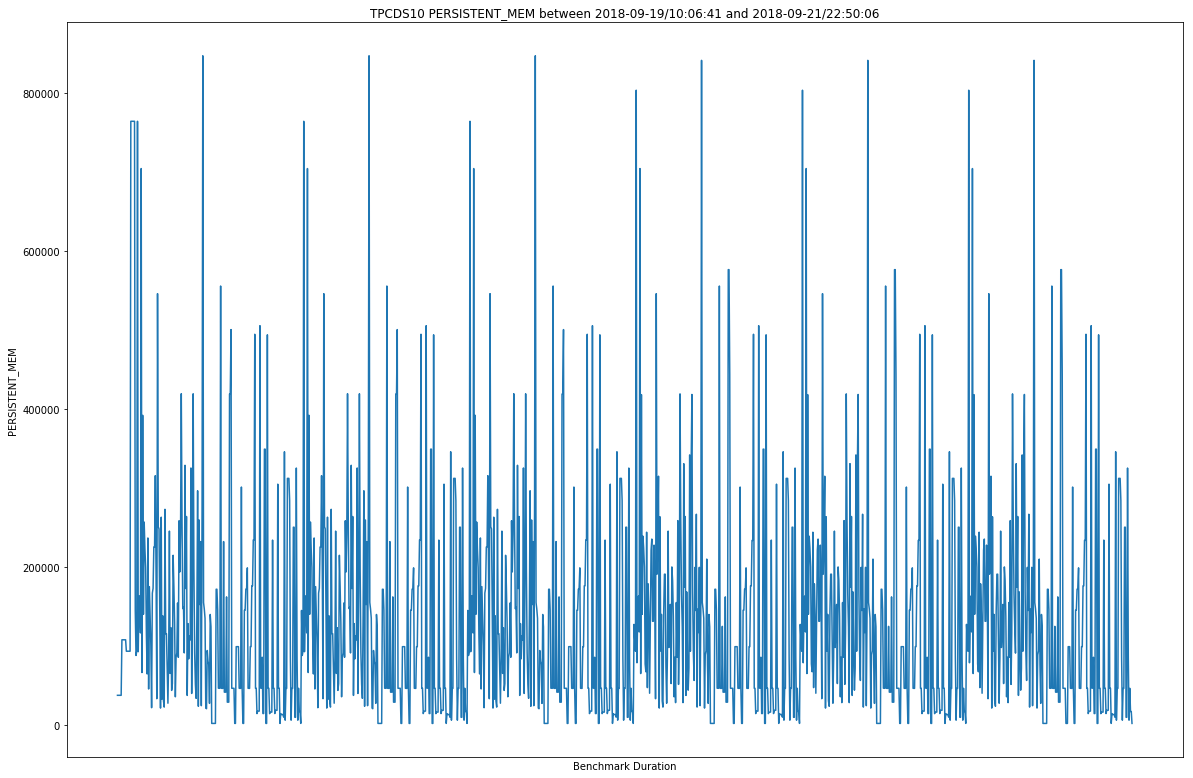

In [5]:
plot_benchmark_distribution(column="PERSISTENT_MEM",tpc_type=tpcds)

### Runtime Memory Distribution

Fixed amount of memory required during the execution of the child cursor

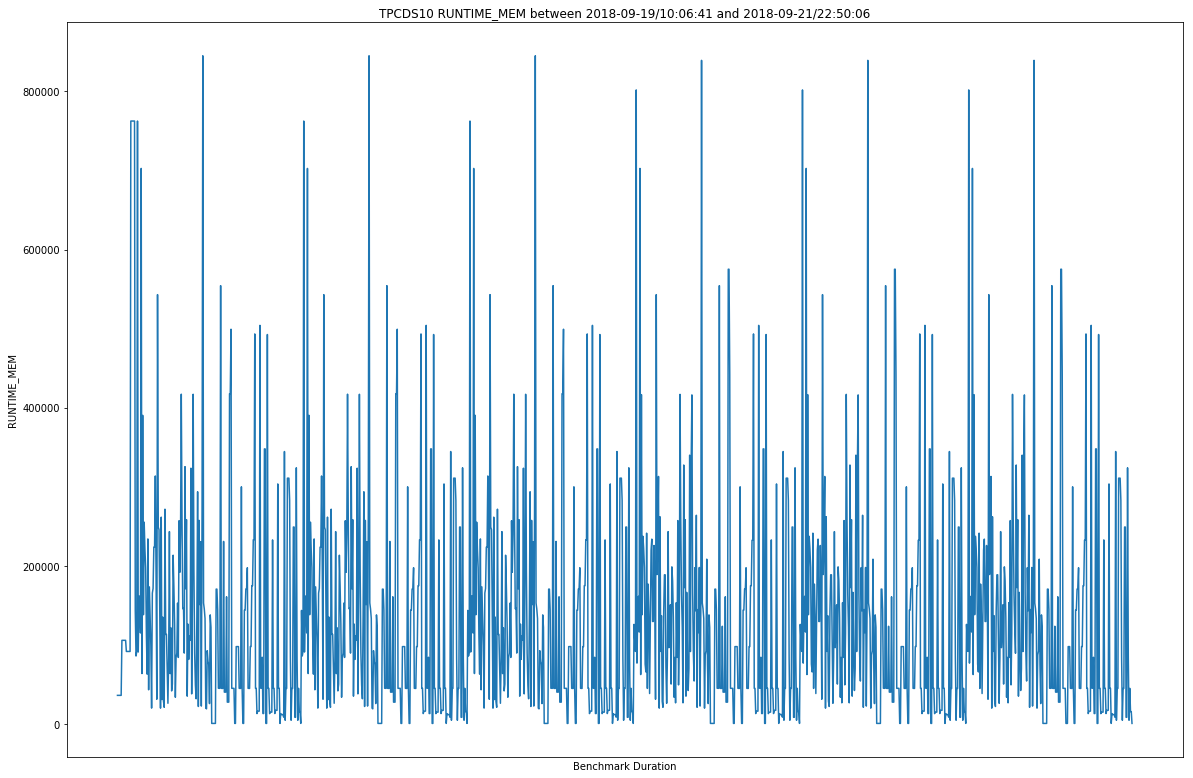

In [6]:
plot_benchmark_distribution(column="RUNTIME_MEM",tpc_type=tpcds)

### Disk Read Distribution

Number of disk reads for this child cursor

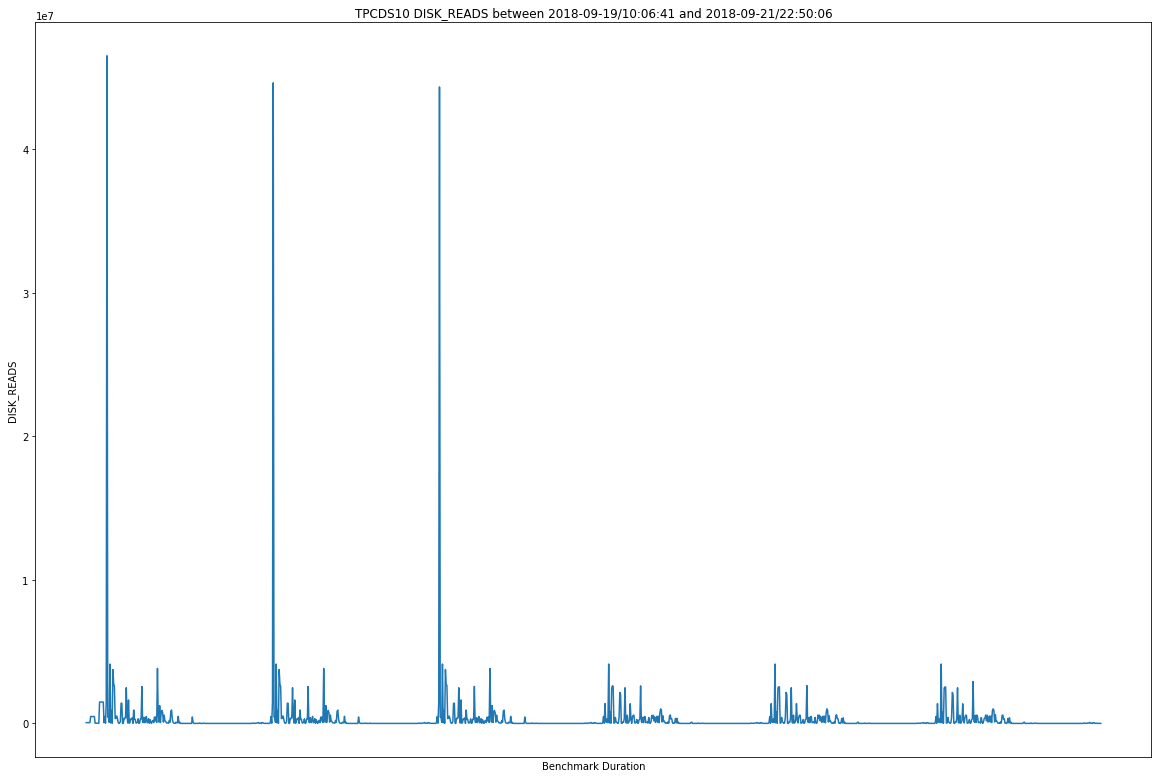

In [7]:
plot_benchmark_distribution(column="DISK_READS",tpc_type=tpcds)

### Direct Write Distribution

Number of direct writes for this child cursor

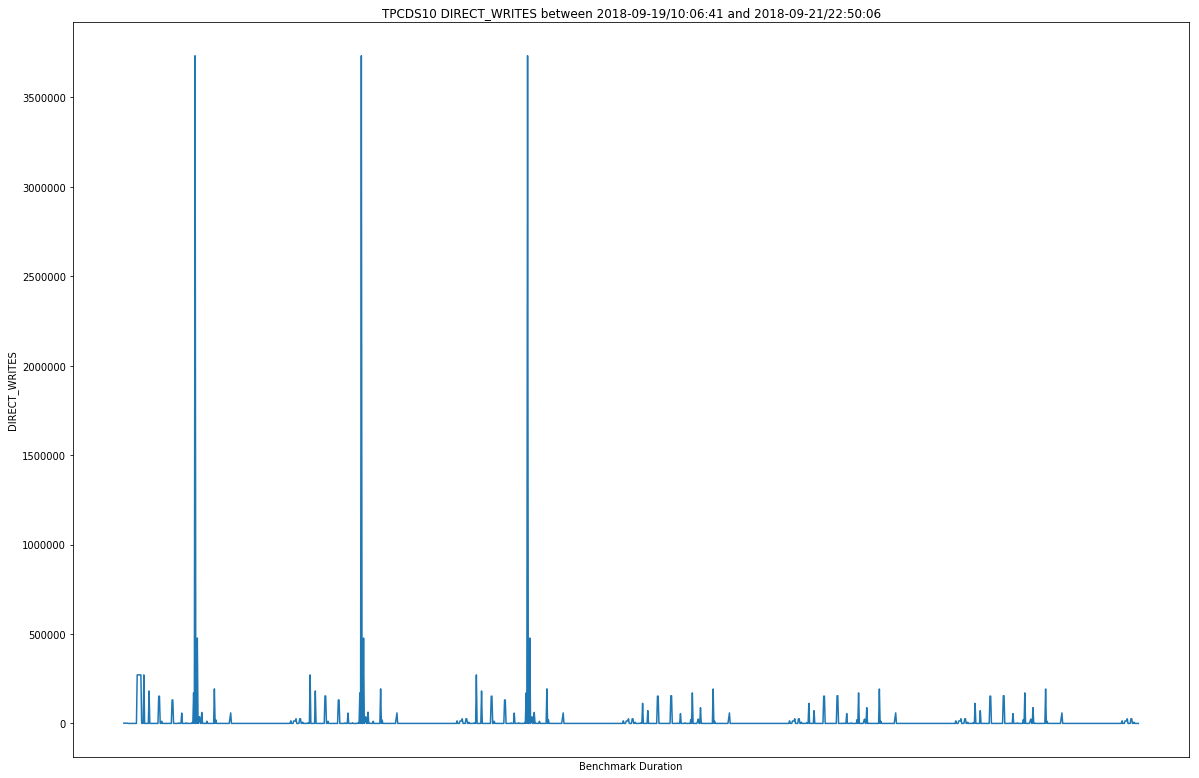

In [8]:
plot_benchmark_distribution(column="DIRECT_WRITES",tpc_type=tpcds)

### Buffer Gets Distribution

Number of buffer gets for this child cursor

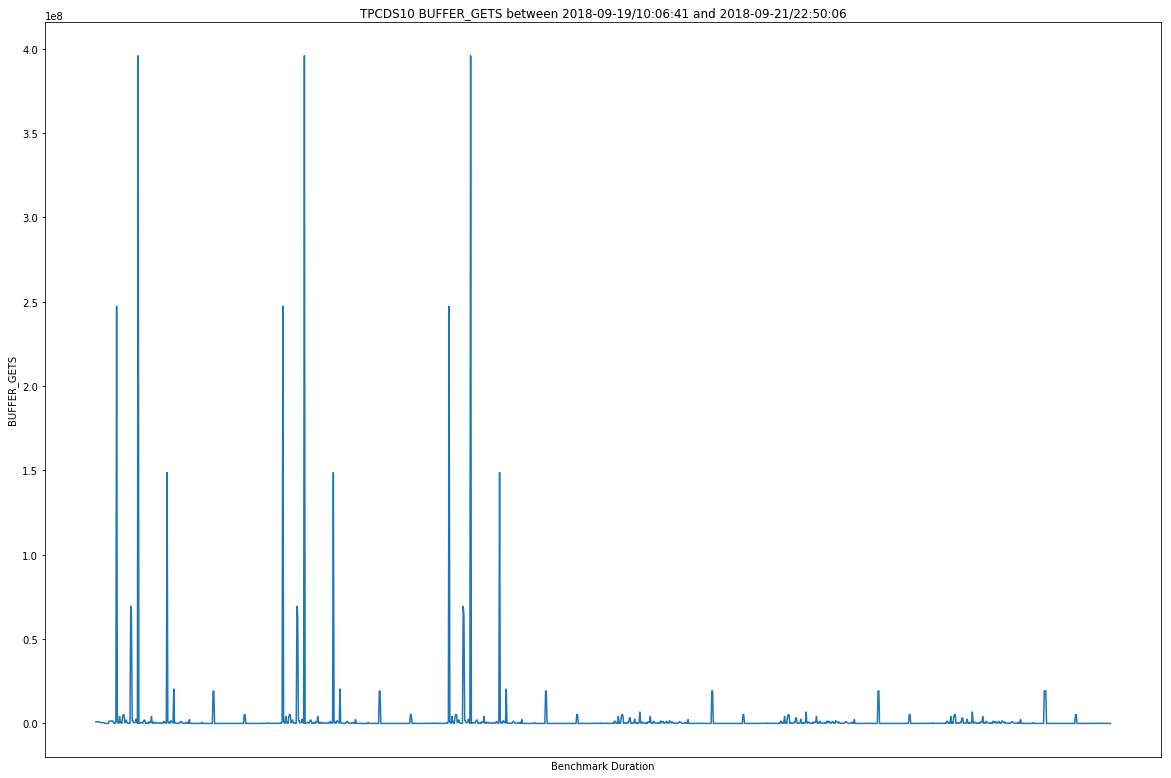

In [9]:
plot_benchmark_distribution(column="BUFFER_GETS",tpc_type=tpcds)

### User IO Wait Time Distribution 

User I/O Wait Time (in microseconds)

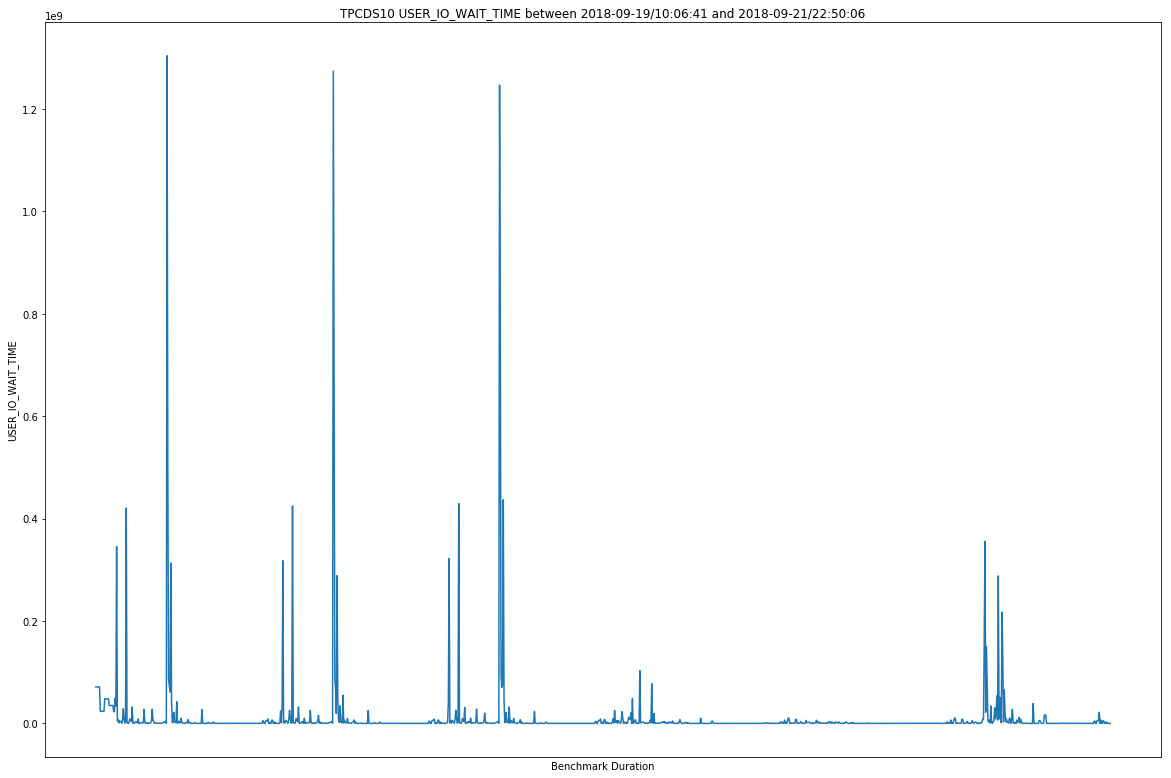

In [10]:
plot_benchmark_distribution(column="USER_IO_WAIT_TIME",tpc_type=tpcds)

### PLSQL Exec Time Distribution

PL/SQL execution time (in microseconds)

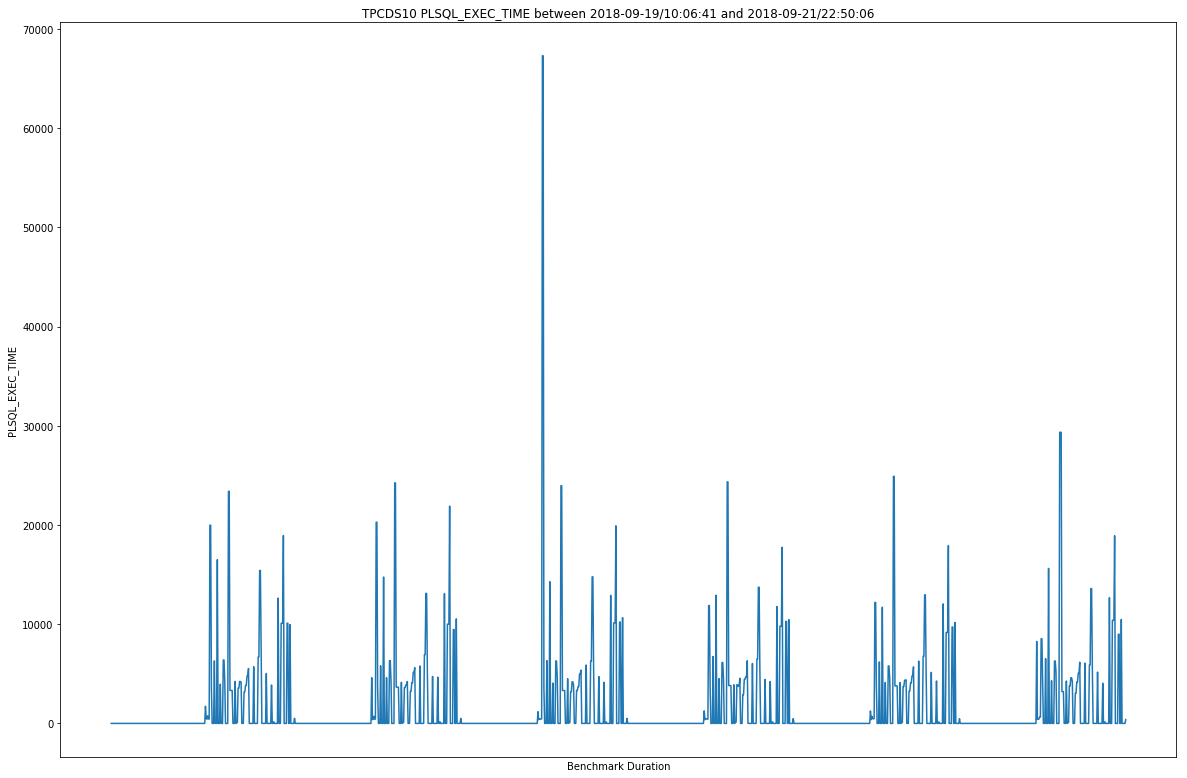

In [11]:
plot_benchmark_distribution(column="PLSQL_EXEC_TIME",tpc_type=tpcds)

### Rows Processesd Distribution

Total number of rows the parsed SQL statement returns

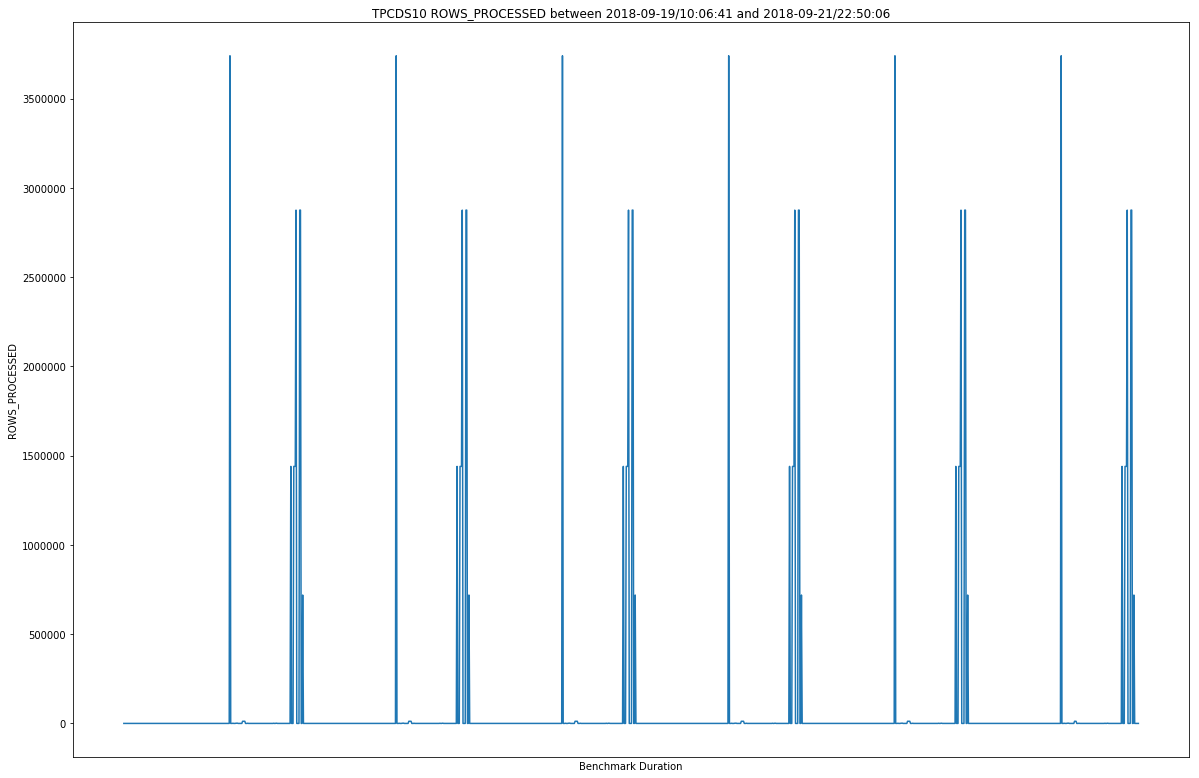

In [12]:
plot_benchmark_distribution(column="ROWS_PROCESSED",tpc_type=tpcds)

### CPU Time Distribution

CPU time (in microseconds) used by this cursor for parsing, executing, and fetching

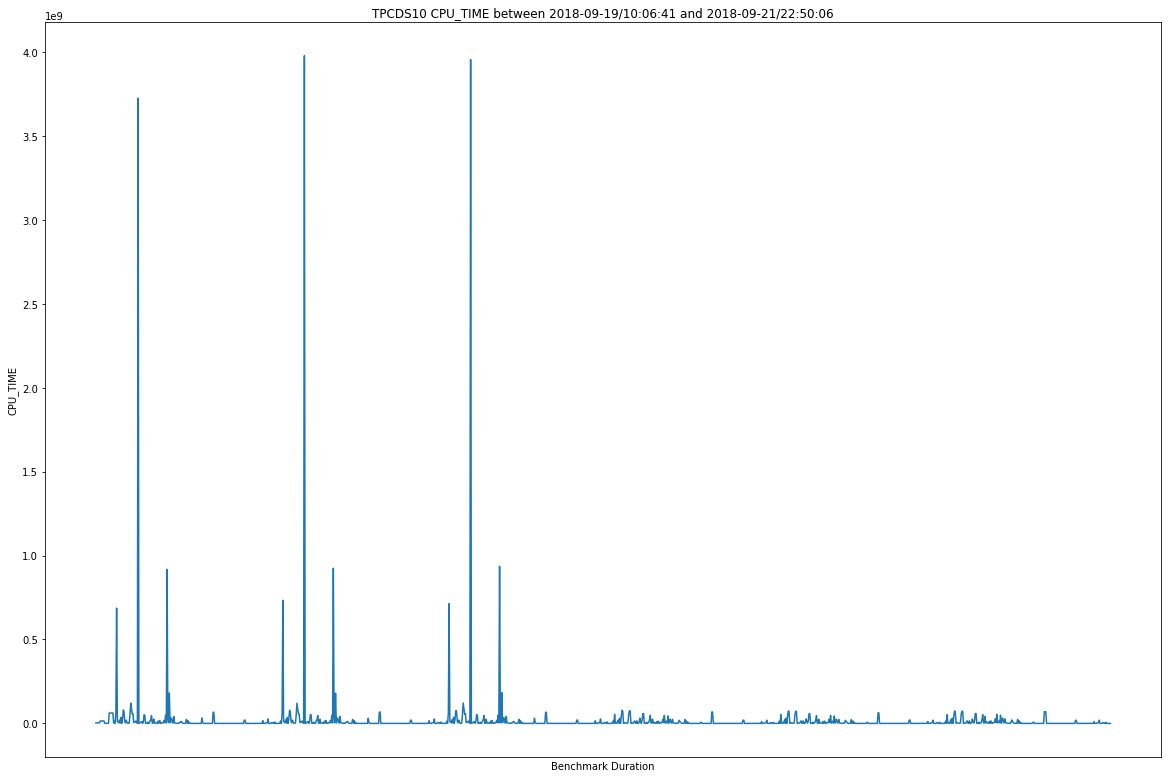

In [13]:
plot_benchmark_distribution(column="CPU_TIME",tpc_type=tpcds)

### Elapsed Timed Distribution

Elapsed time (in microseconds) used by this cursor for parsing, executing, and fetching

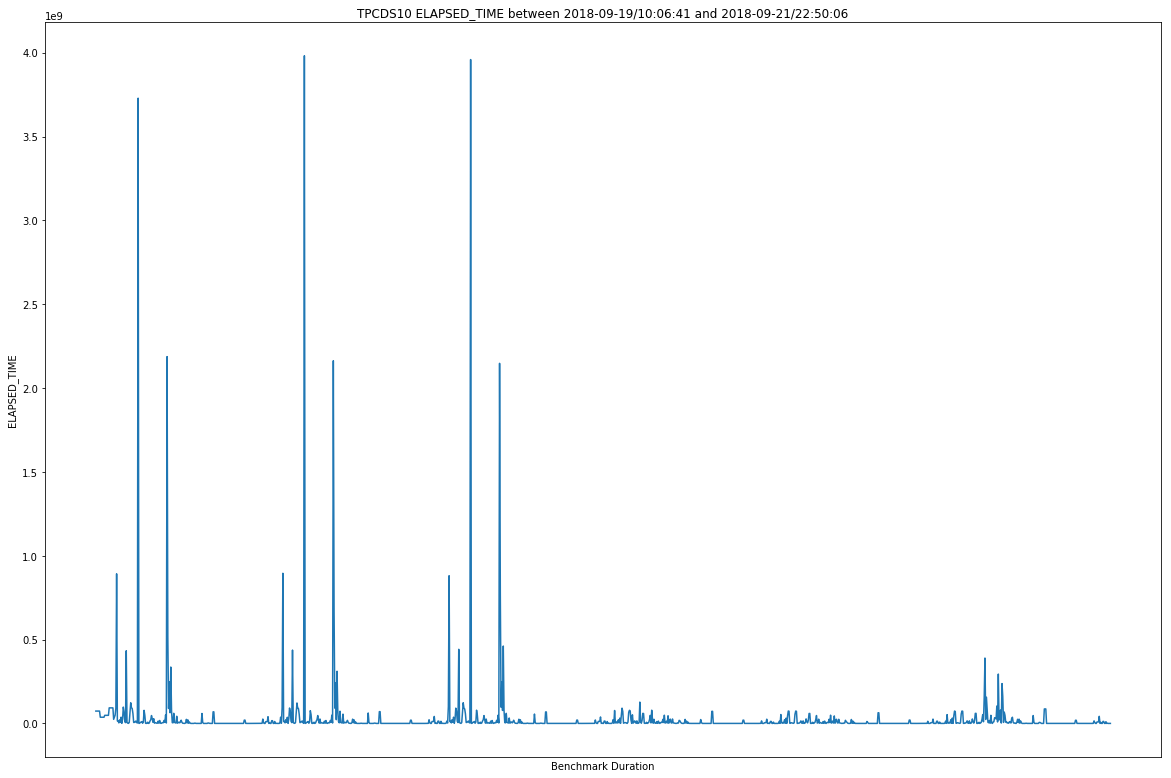

In [14]:
plot_benchmark_distribution(column="ELAPSED_TIME",tpc_type=tpcds)

### Physical Read Requests Distribution

Number of physical read I/O requests issued by the monitored SQL

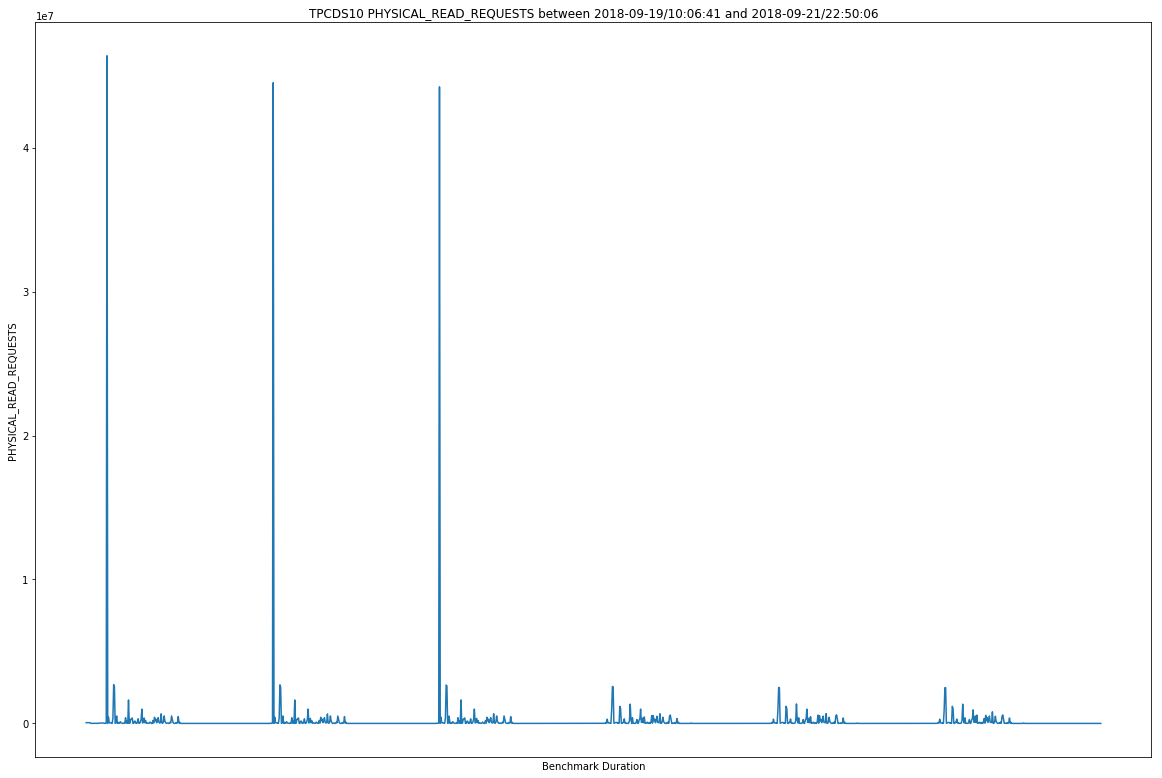

In [15]:
plot_benchmark_distribution(column="PHYSICAL_READ_REQUESTS",tpc_type=tpcds)

### Physical Write Requests Distribution

Number of physical write I/O requests issued by the monitored SQL

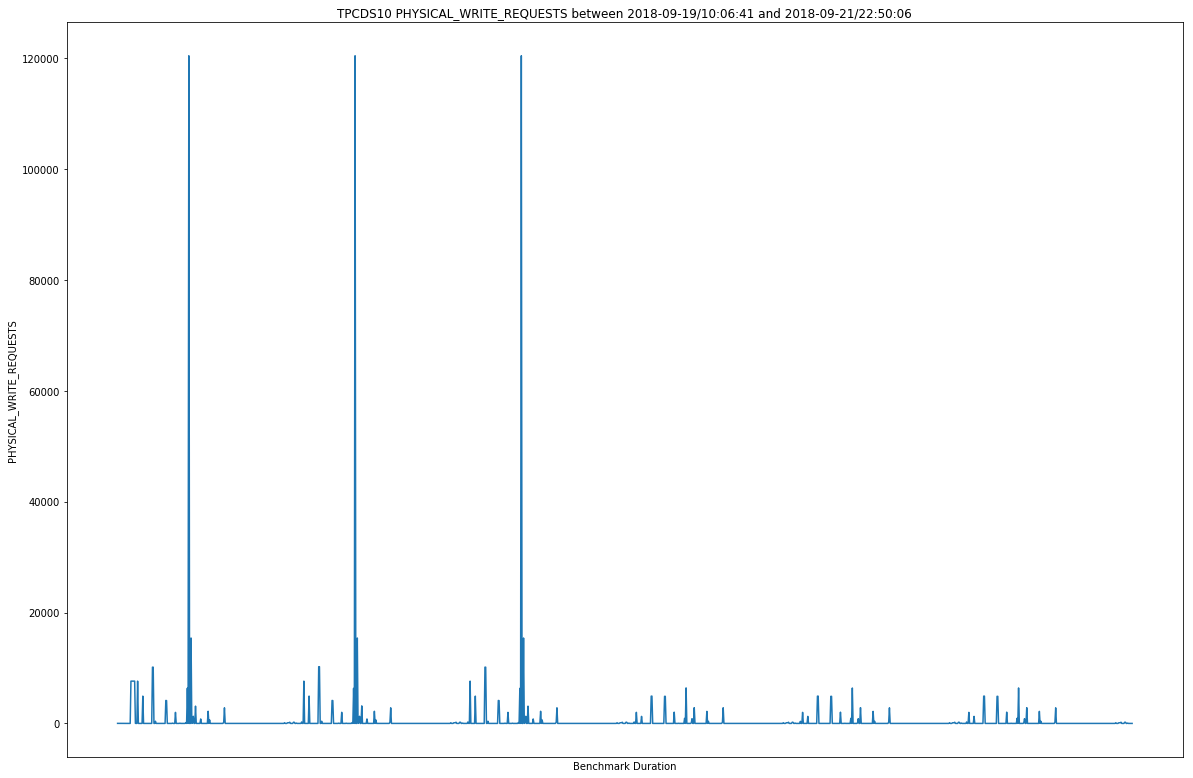

In [16]:
plot_benchmark_distribution(column="PHYSICAL_WRITE_REQUESTS",tpc_type=tpcds)

### Optimizer Operation Ratio Distribution

Name of the internal operation performed in this step. In the first row generated for a statement, the column contains one of the following values:

* DELETE STATEMENT
* INSERT STATEMENT
* SELECT STATEMENT
* UPDATE STATEMENT

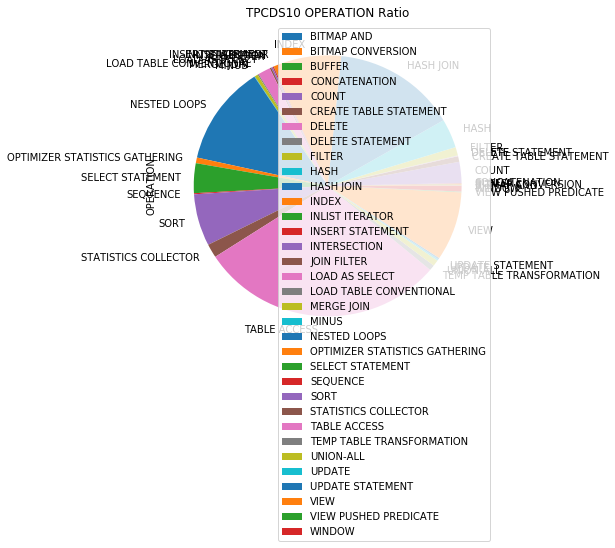

In [17]:
plot_plan_ratios(column="OPERATION",tpc_type=tpcds)

### Optimizer Plan Options Ratio

A variation on the operation described in the OPERATION column

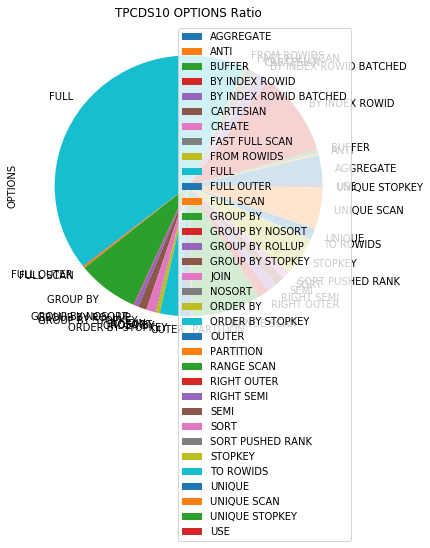

In [18]:
plot_plan_ratios(column="OPTIONS",tpc_type=tpcds)

# TPC-DS Optimizer Statistic Benchmark Comparison

This section compares resource utilization for all carried out TPC-DS benchmark (1,10,100), but does so in comparison when optimizer statistics are gathered on the database, and when not.

### Sharable Memory Comparison

Amount of shared memory used by the child cursor (in bytes)

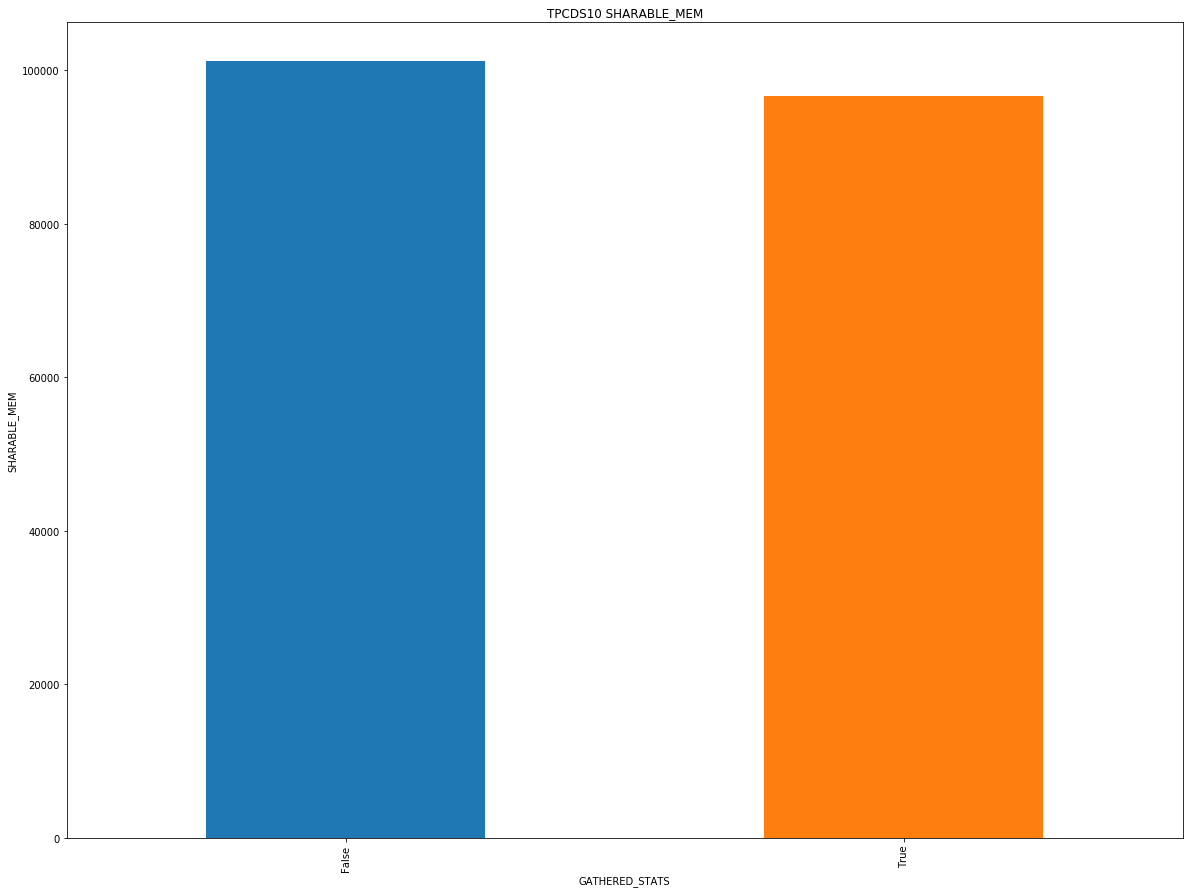

In [19]:
plot_optimizer_stats_contrast(column='SHARABLE_MEM',tpc_type=tpcds)

### Persistent Memory Comparison

Fixed amount of memory used for the lifetime of the child cursor (in bytes)

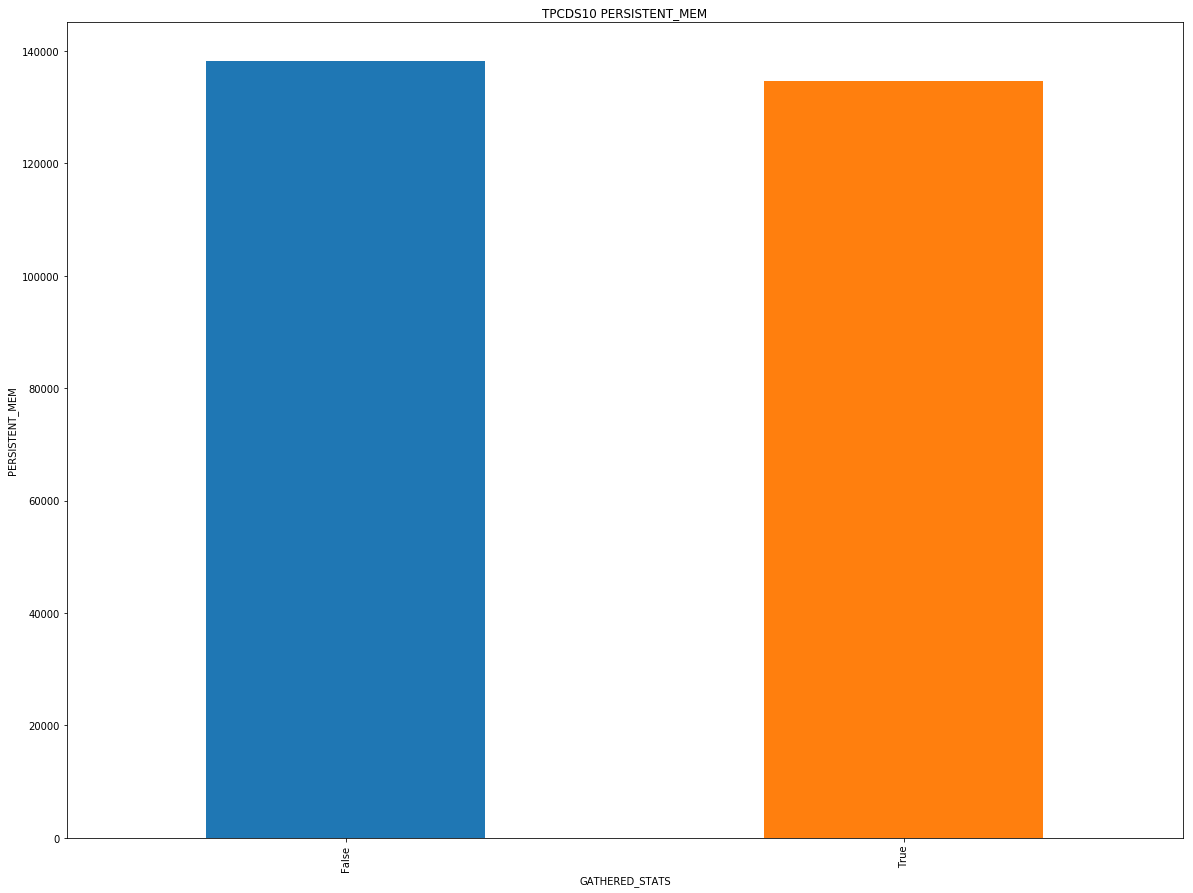

In [20]:
plot_optimizer_stats_contrast(column='PERSISTENT_MEM',tpc_type=tpcds)

### Runtime Memory Comparison

Fixed amount of memory required during the execution of the child cursor

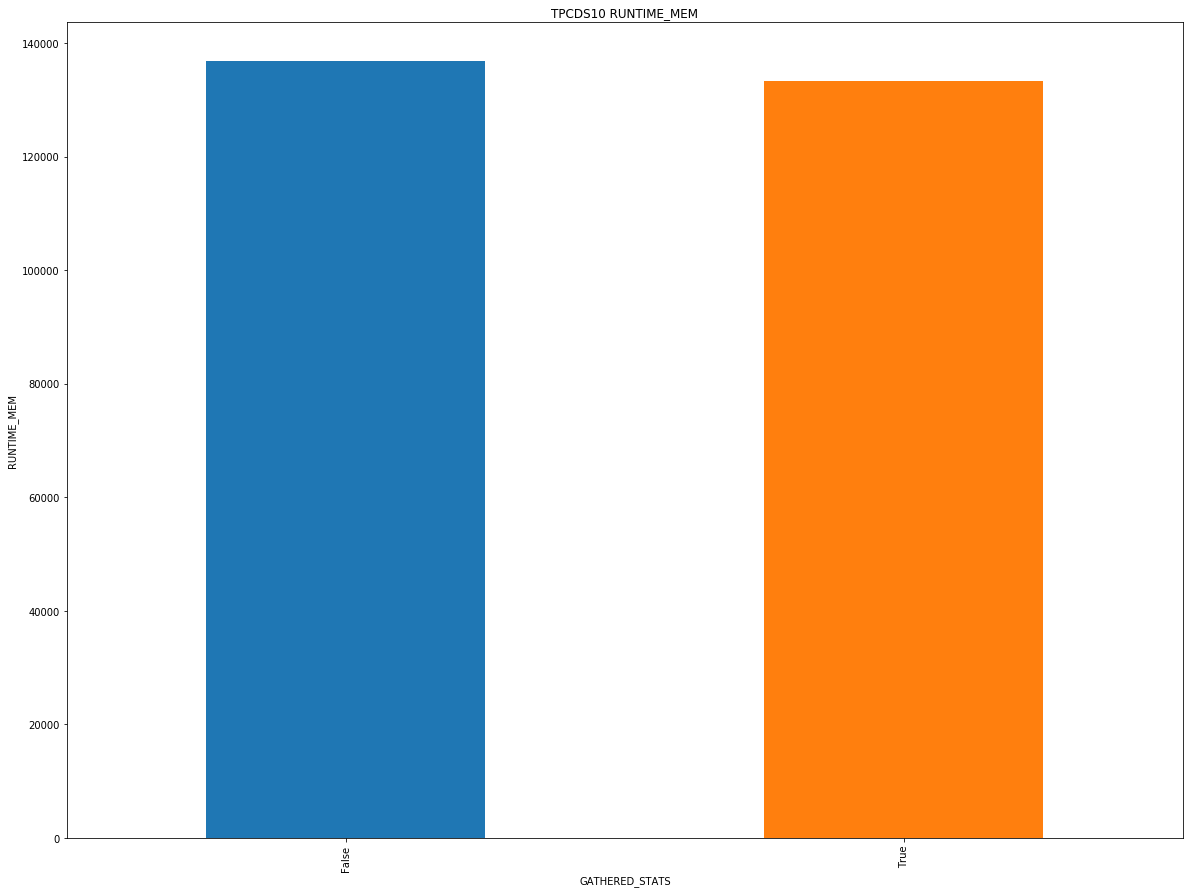

In [21]:
plot_optimizer_stats_contrast(column='RUNTIME_MEM',tpc_type=tpcds)

### Sorts Comparison

Number of sorts that were done for the child cursor

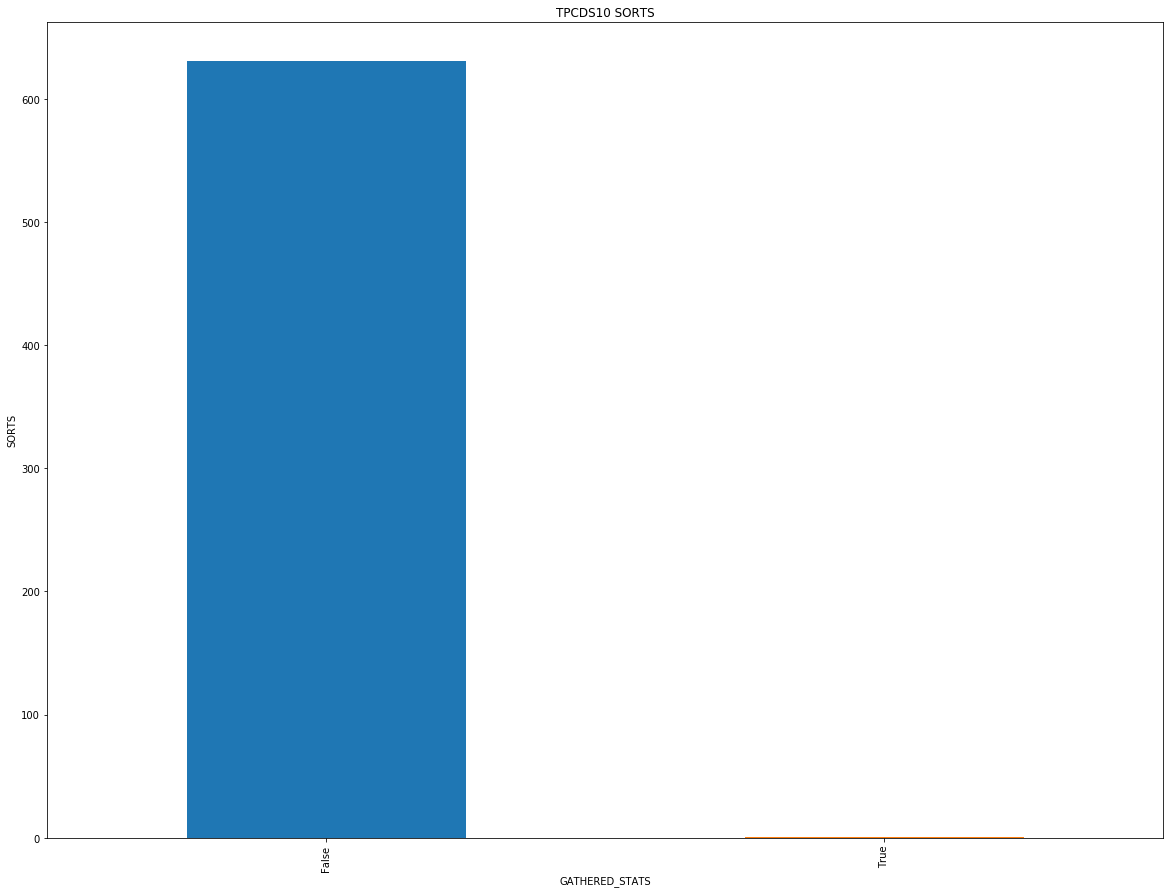

In [22]:
plot_optimizer_stats_contrast(column='SORTS',tpc_type=tpcds)

### Disk Reads Comparison

Number of disk reads for this child cursor

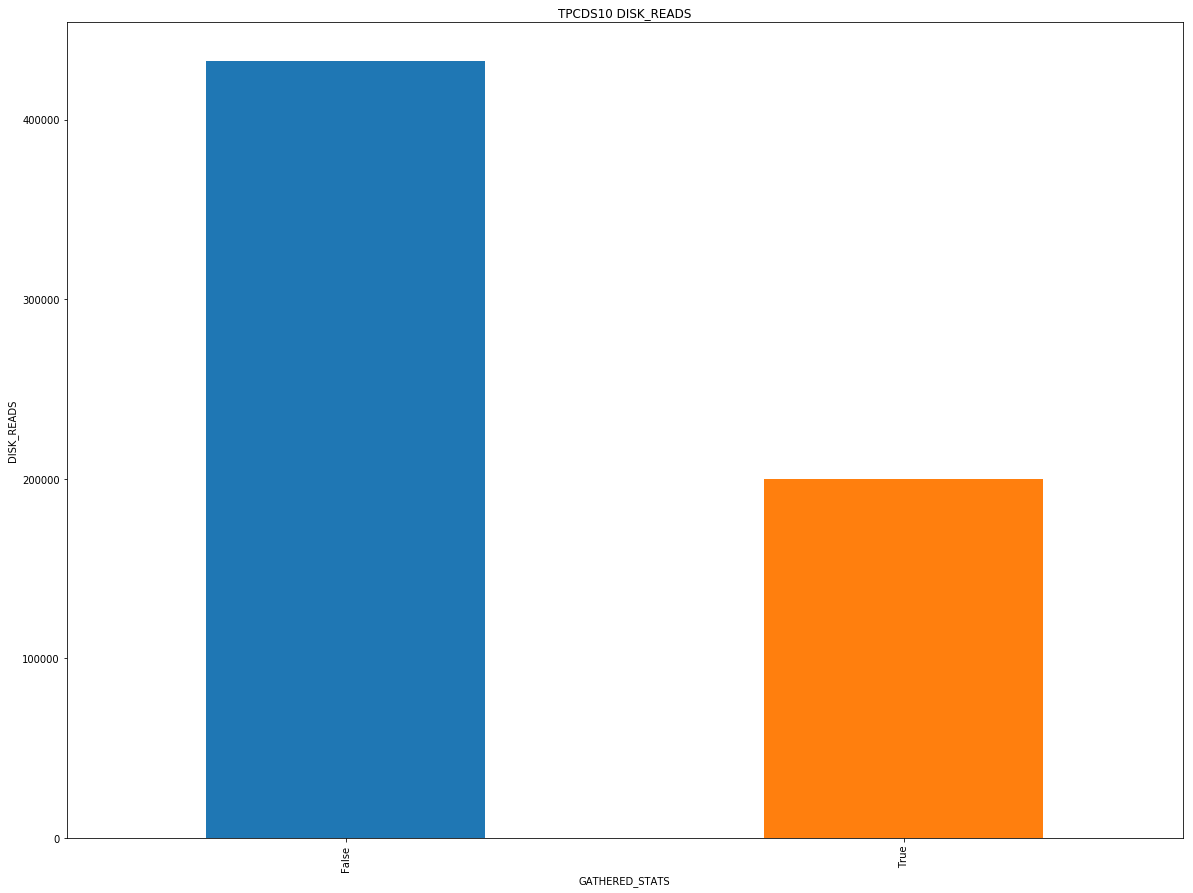

In [23]:
plot_optimizer_stats_contrast(column='DISK_READS',tpc_type=tpcds)

### Direct Writes Comparison

Number of direct writes for this child cursor

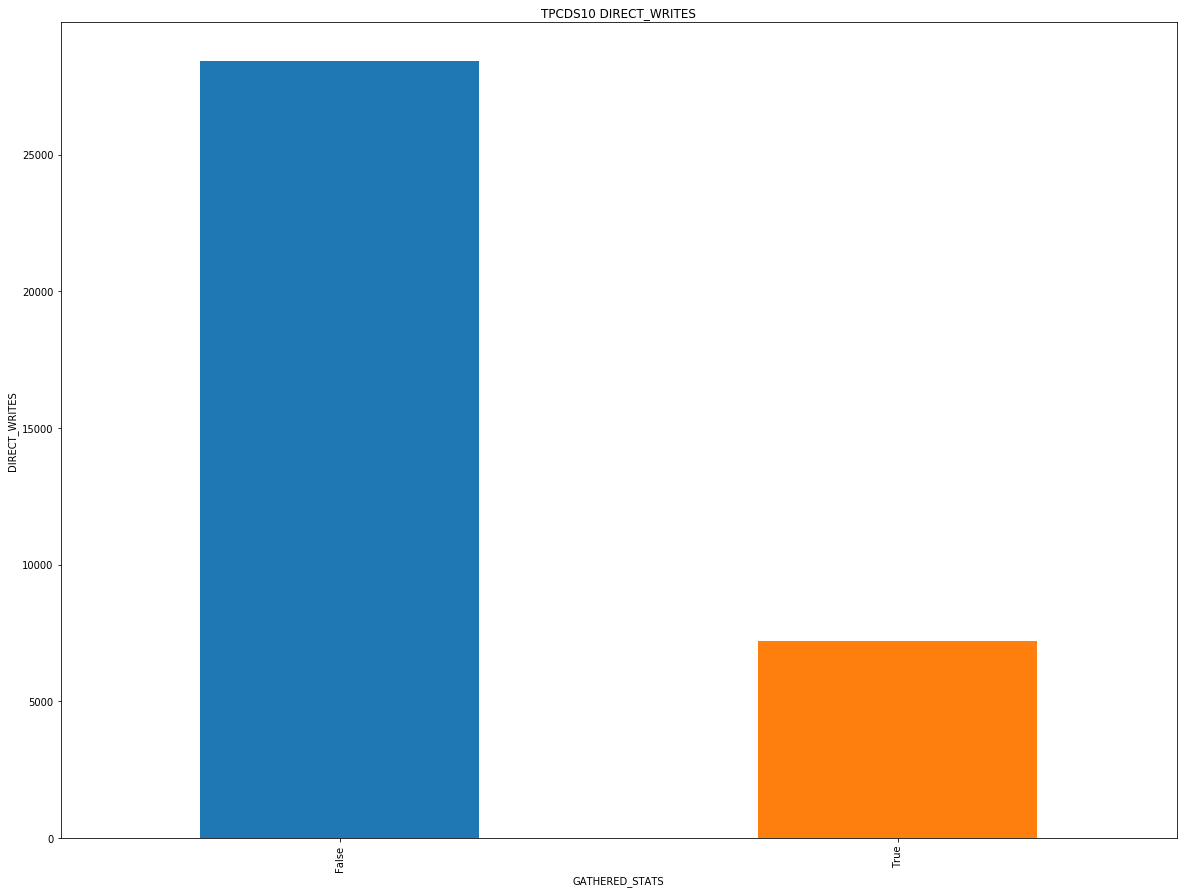

In [24]:
plot_optimizer_stats_contrast(column='DIRECT_WRITES',tpc_type=tpcds)

### Buffer Gets Comparison

Number of buffer gets for this child cursor

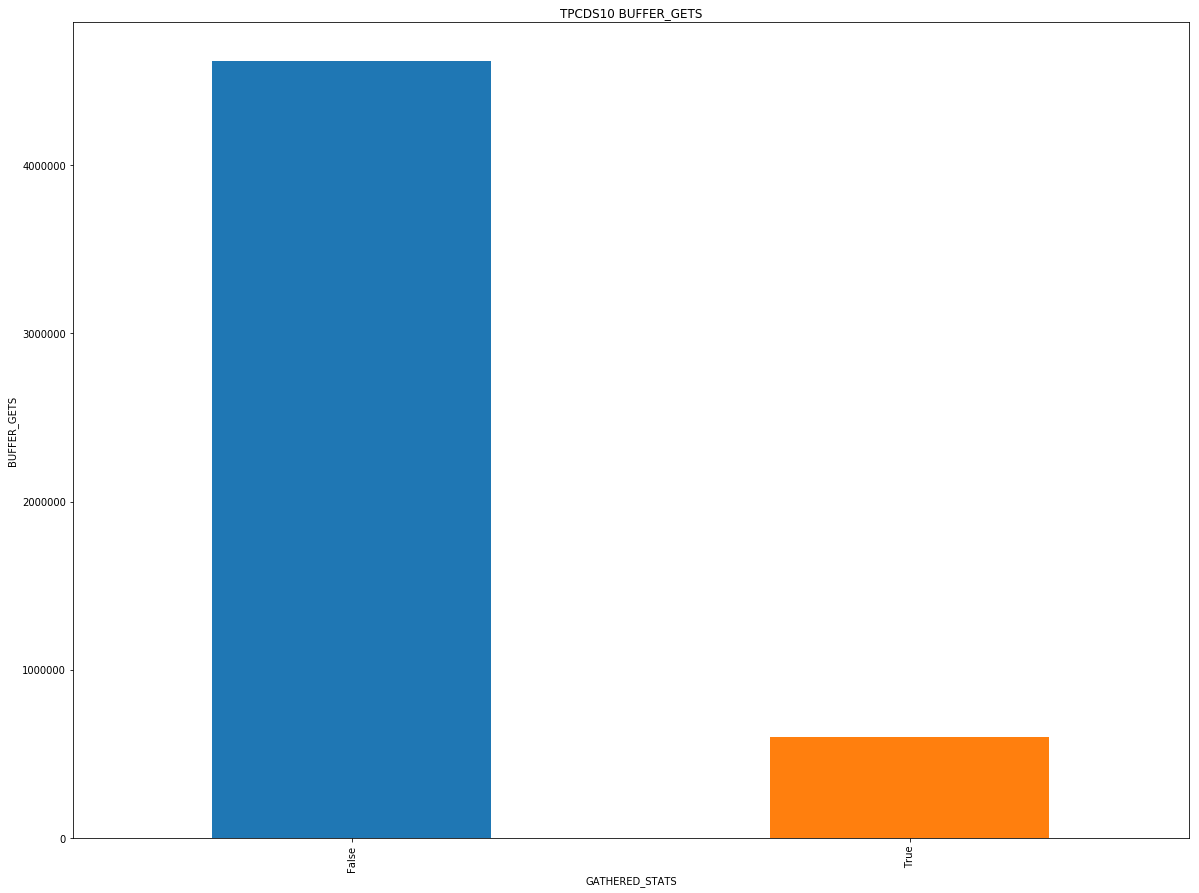

In [25]:
plot_optimizer_stats_contrast(column='BUFFER_GETS',tpc_type=tpcds)

### User IO Wait Time Comparison

User I/O Wait Time (in microseconds)

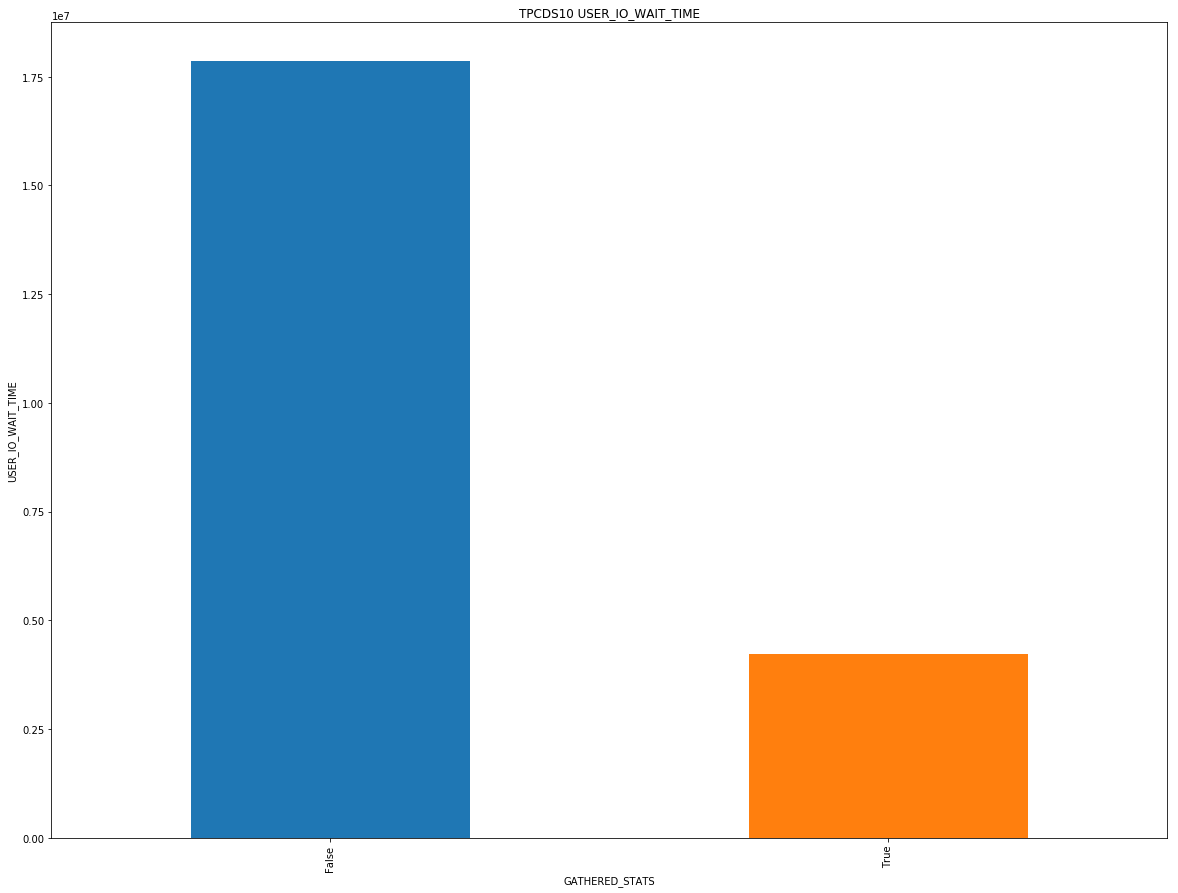

In [26]:
plot_optimizer_stats_contrast(column='USER_IO_WAIT_TIME',tpc_type=tpcds)

### Rows Processed Comparison

Total number of rows the parsed SQL statement returns

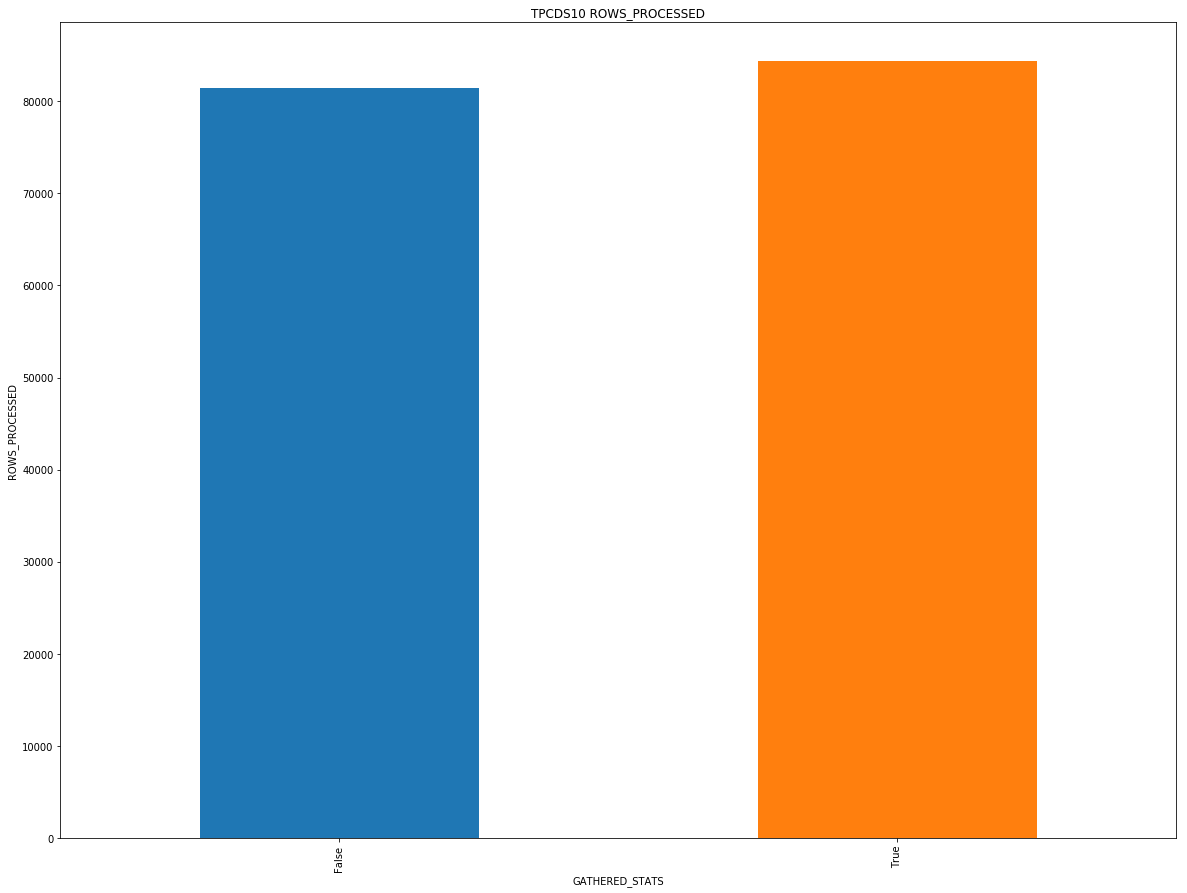

In [27]:
plot_optimizer_stats_contrast(column='ROWS_PROCESSED',tpc_type=tpcds)

### CPU Time Comparison

CPU time (in microseconds) used by this cursor for parsing, executing, and fetching

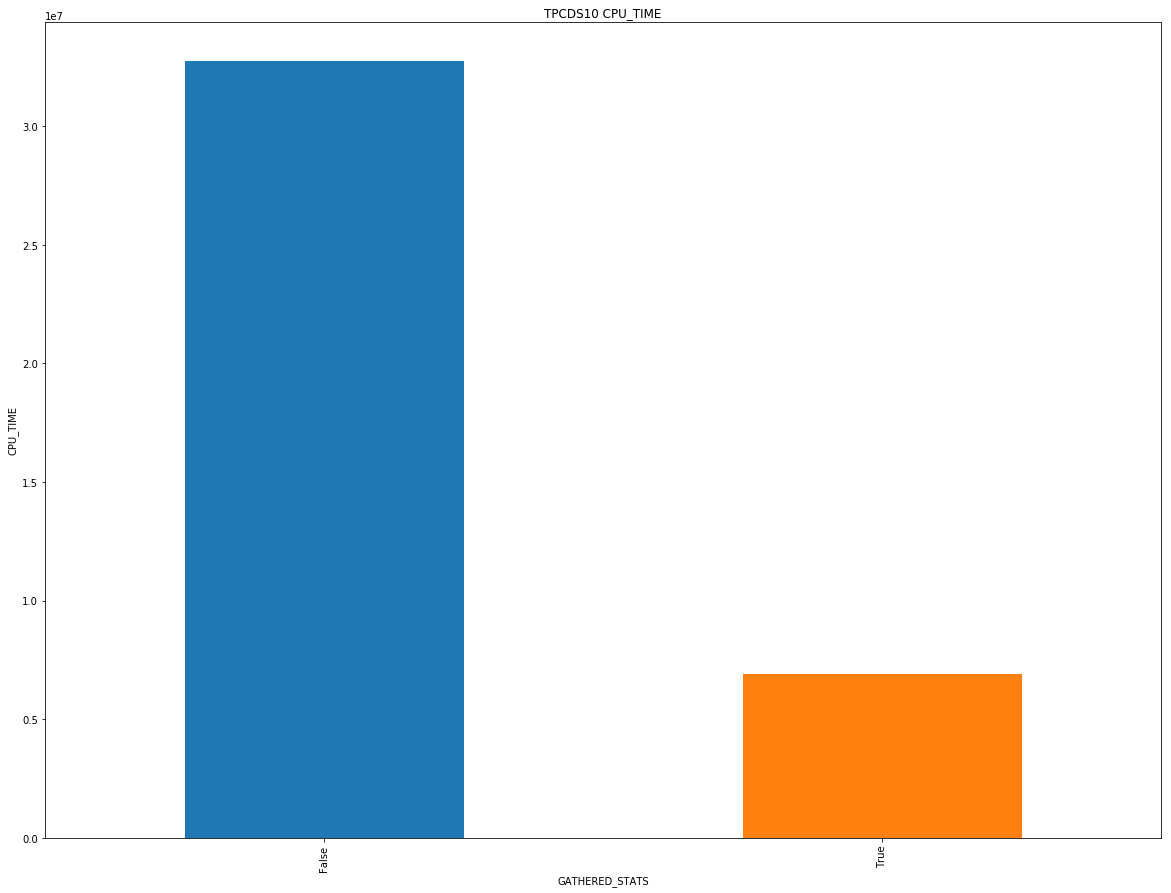

In [28]:
plot_optimizer_stats_contrast(column='CPU_TIME',tpc_type=tpcds)

### Elapsed Time Comparison

Elapsed time (in microseconds) used by this cursor for parsing, executing, and fetching

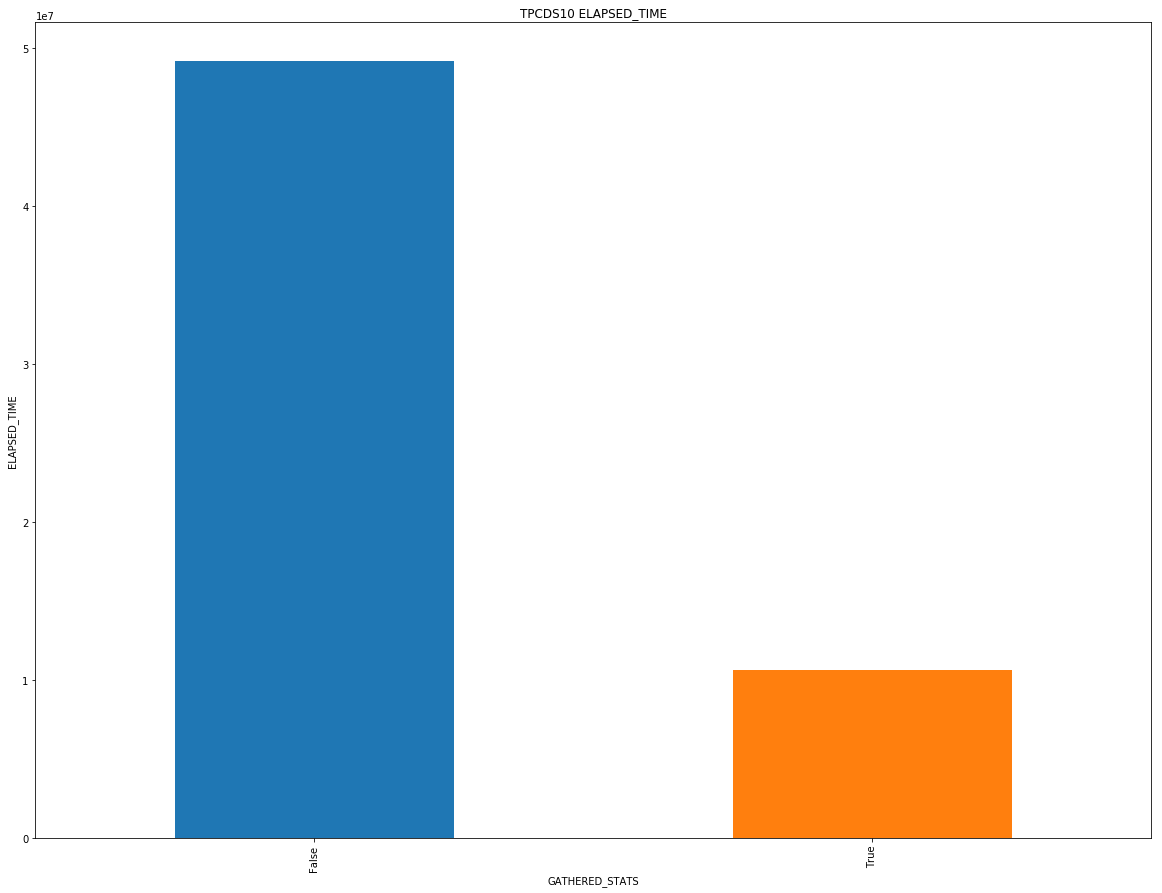

In [29]:
plot_optimizer_stats_contrast(column='ELAPSED_TIME',tpc_type=tpcds)

### Physical Read Requests Comparison

Number of physical Read I/O requests issued by the monitored SQL

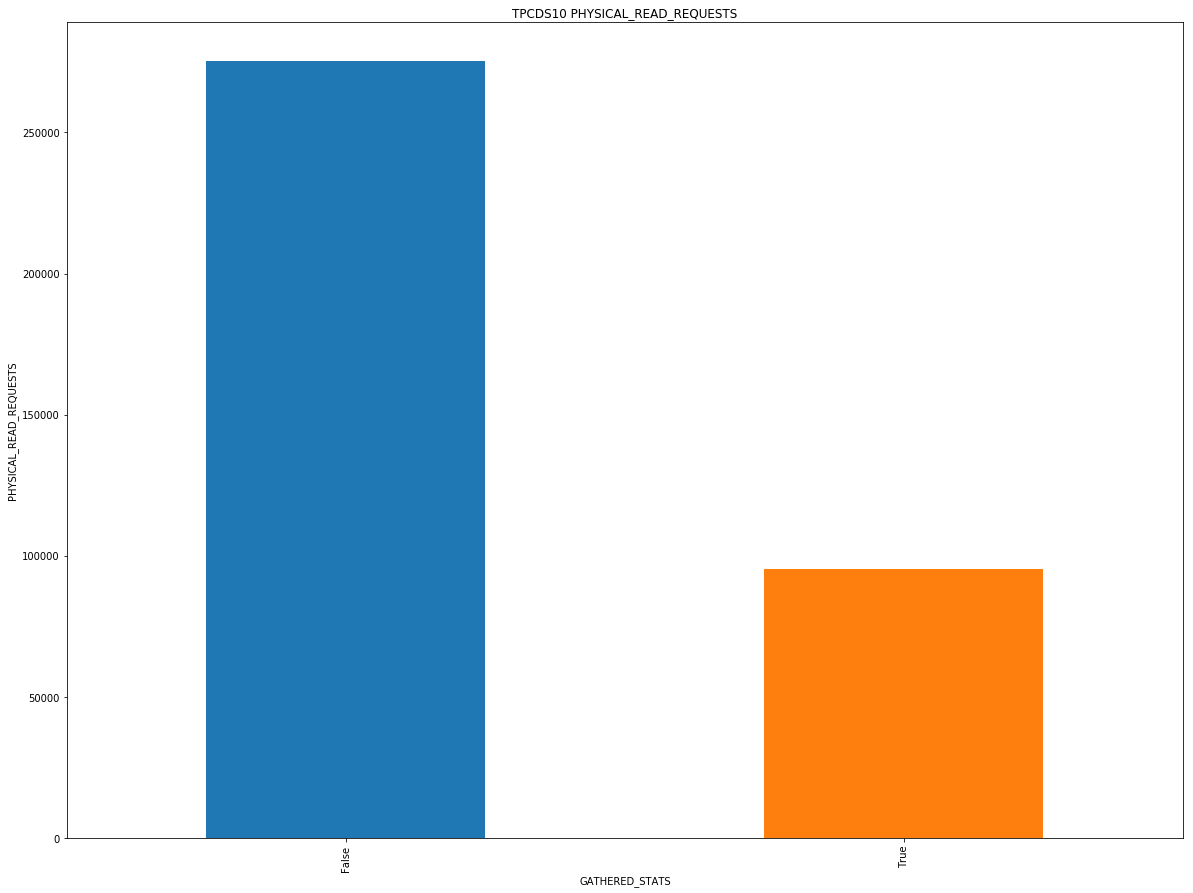

In [30]:
plot_optimizer_stats_contrast(column='PHYSICAL_READ_REQUESTS',tpc_type=tpcds)

### Physical Write Requests Comparison

Number of physical Write I/O requests issued by the monitored SQL

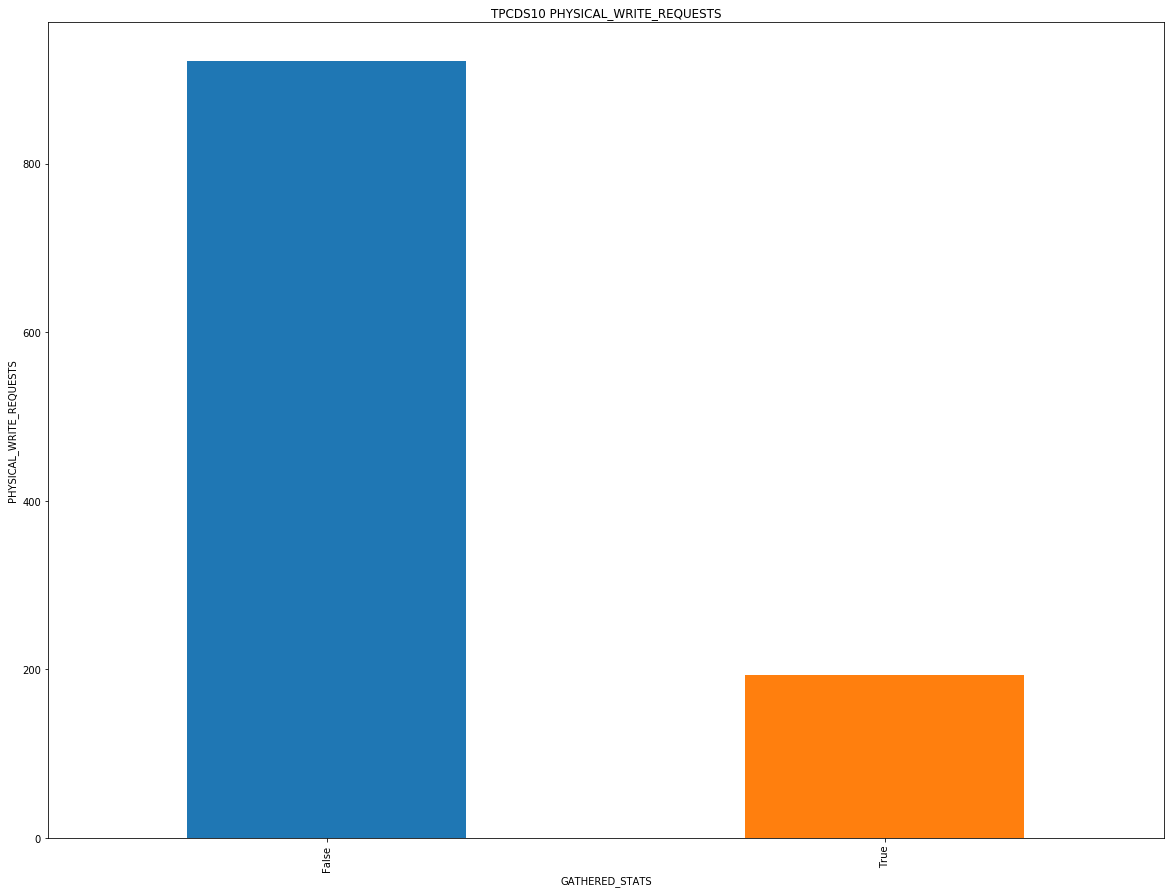

In [31]:
plot_optimizer_stats_contrast(column='PHYSICAL_WRITE_REQUESTS',tpc_type=tpcds)

### Shareable Mem (Histogram Distribution)

Amount of shared memory used by the child cursor (in bytes).

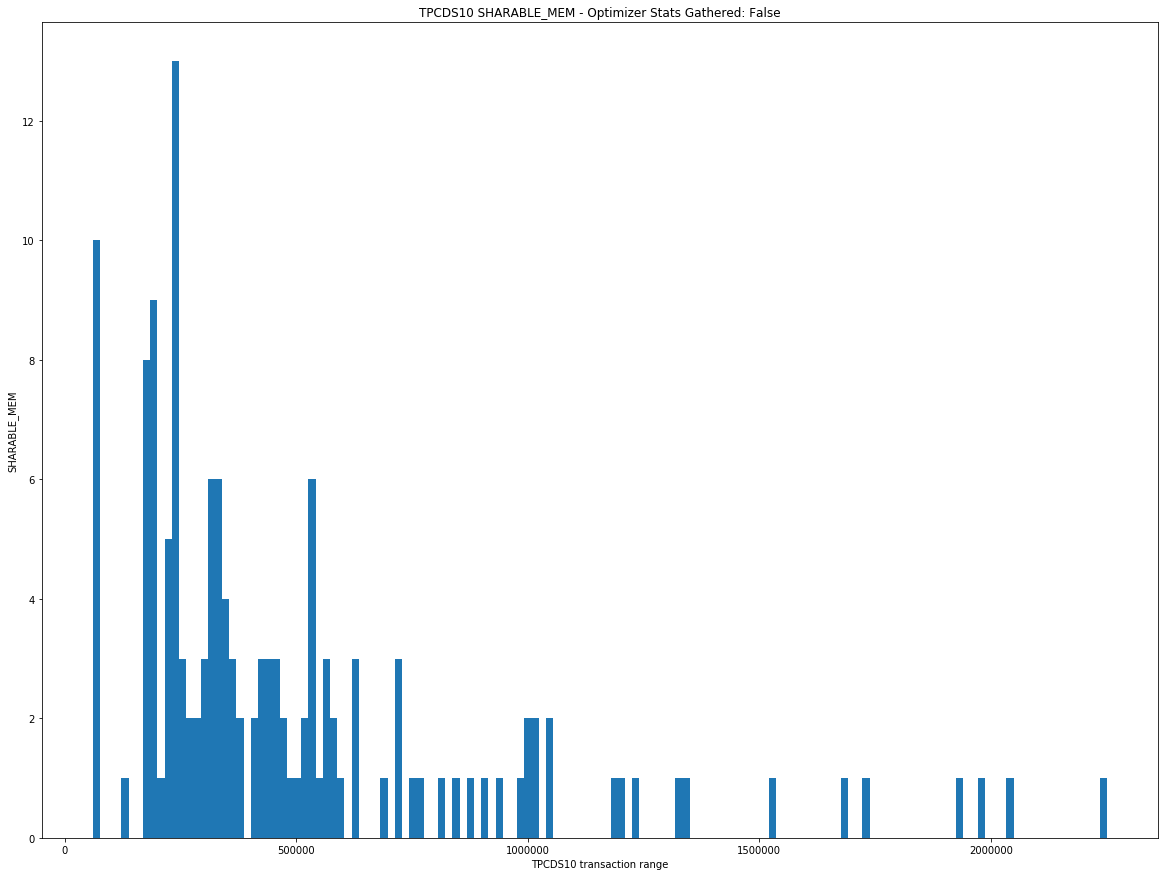

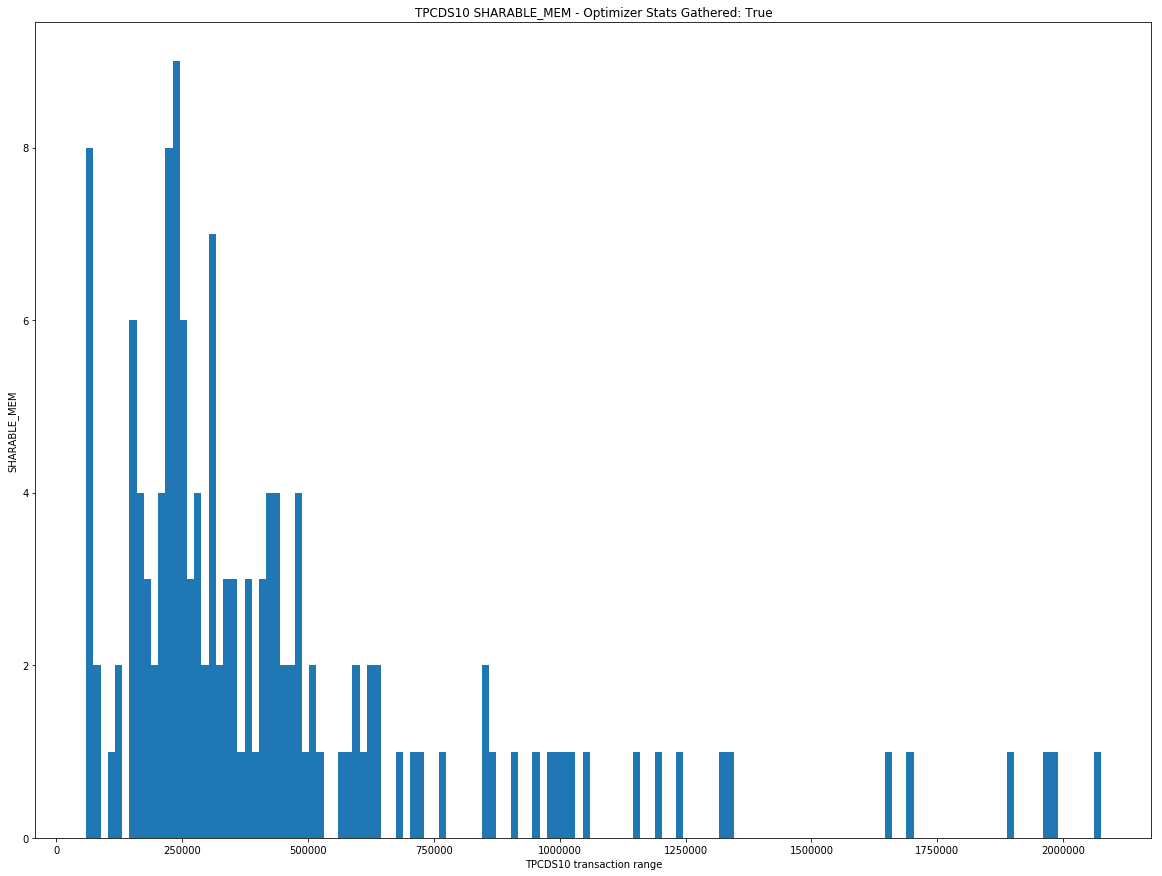

In [32]:
top_consumer_histogram(table='rep_execution_plans', column='SHARABLE_MEM', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='SHARABLE_MEM', tpc_type=tpcds, gathered_stats=True)

### Shareable Mem (Top 20 Transactions)

Amount of shared memory used by the child cursor (in bytes).

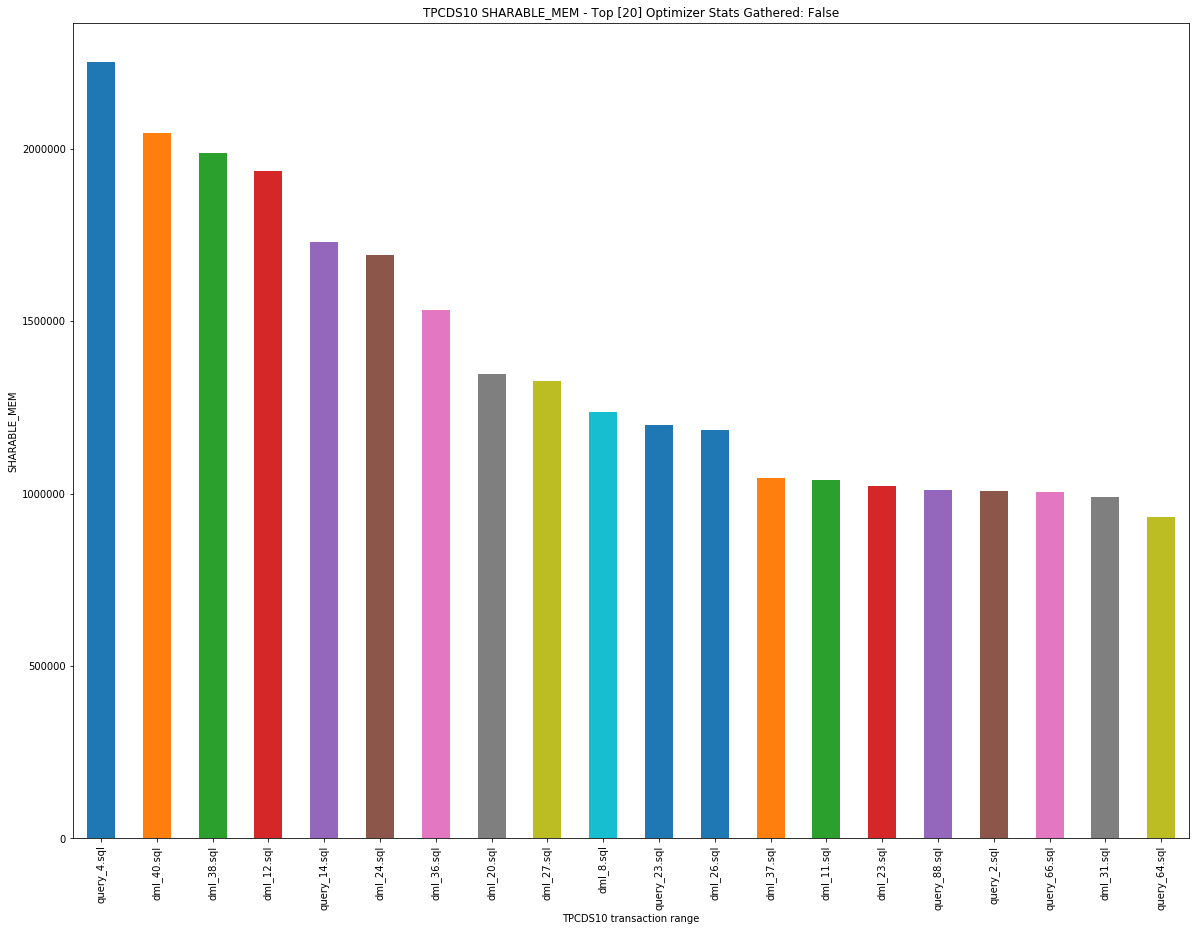

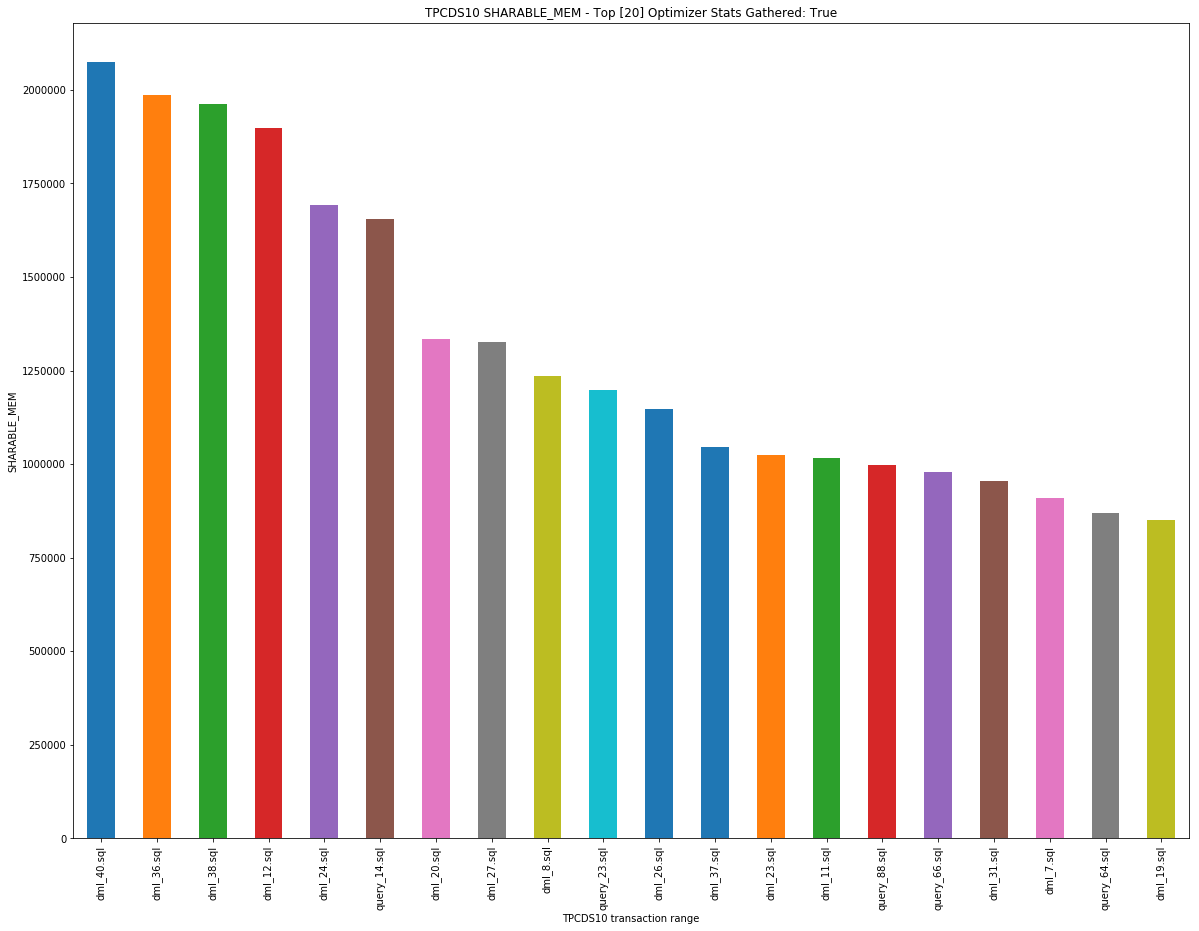

In [33]:
top_consumer_bar(table='rep_execution_plans', column='SHARABLE_MEM', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='SHARABLE_MEM', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Persistent Memory Distribution (Histogram Distribution)

Fixed amount of memory used for the lifetime of the child cursor (in bytes)

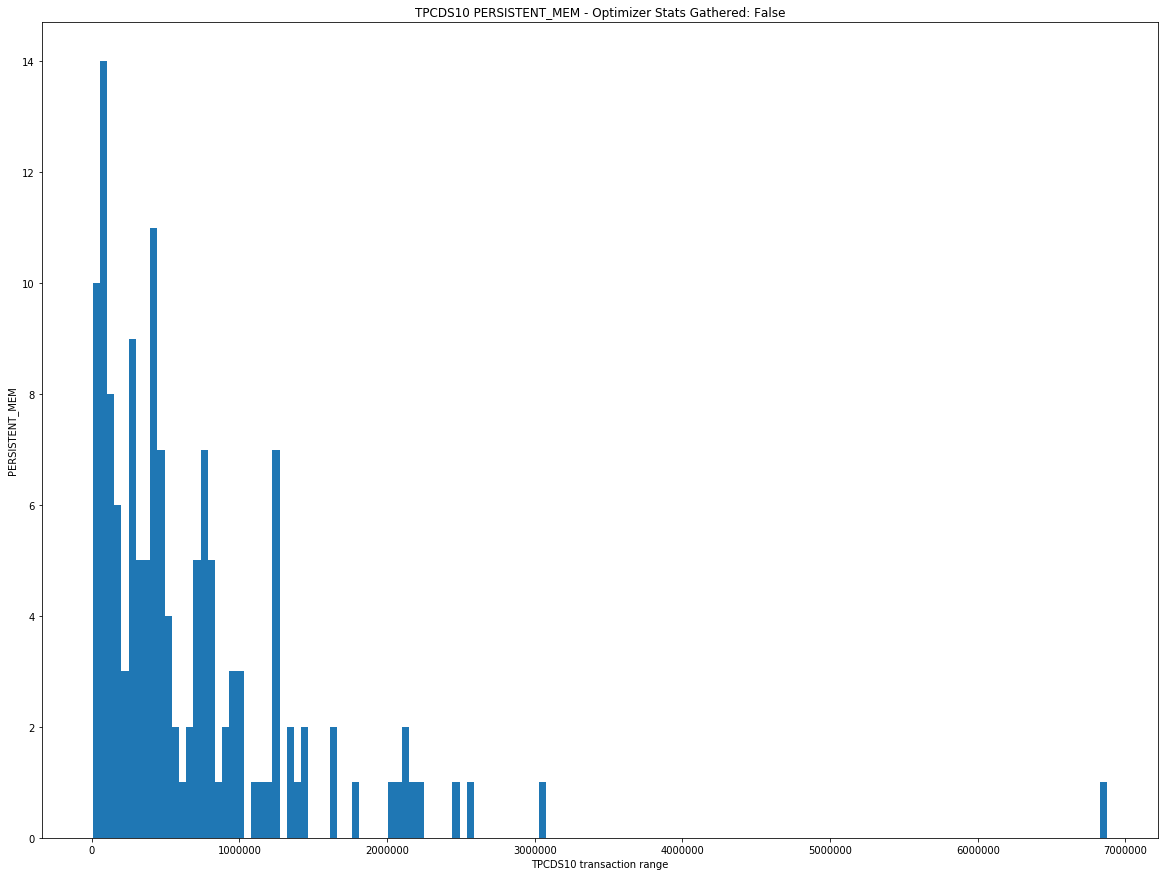

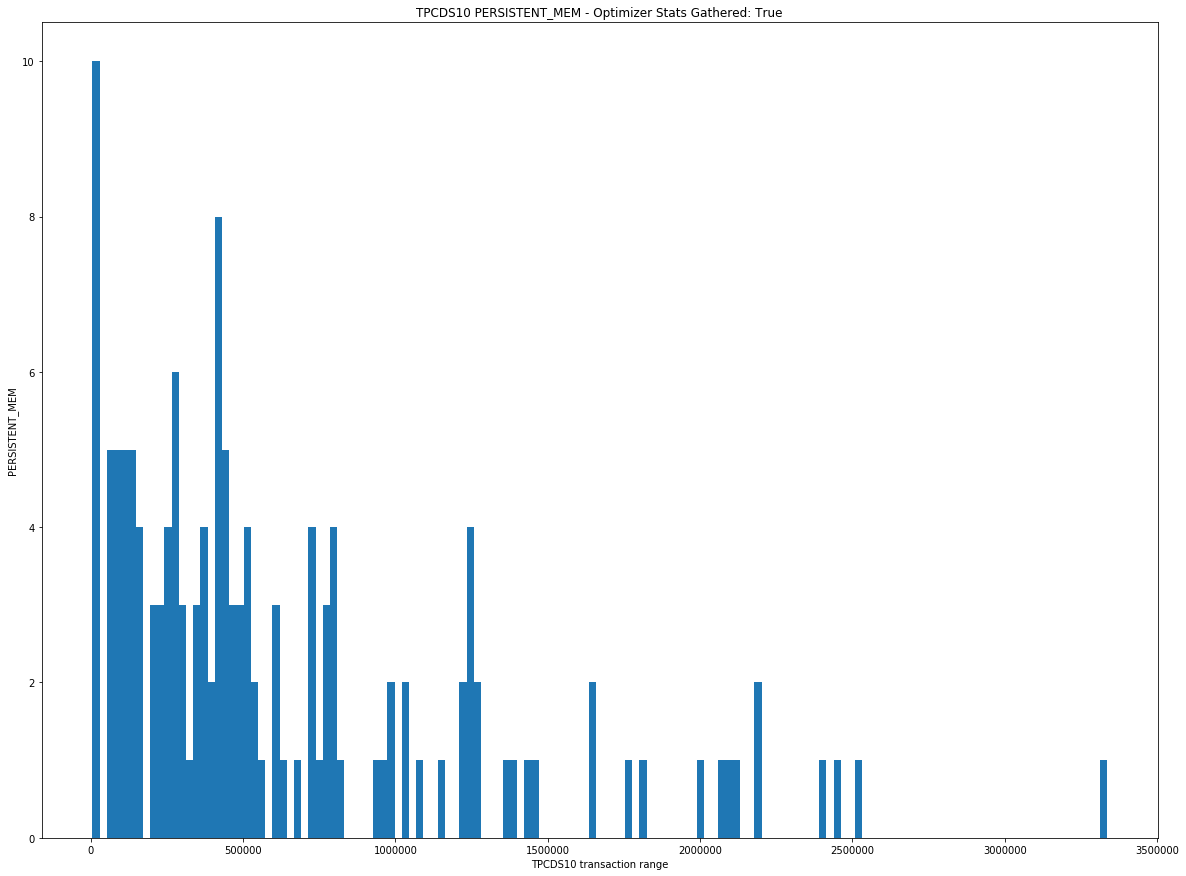

In [34]:
top_consumer_histogram(table='rep_execution_plans', column='PERSISTENT_MEM', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='PERSISTENT_MEM', tpc_type=tpcds, gathered_stats=True)

### Persistent Memory Distribution (Top 20 Transactions)

Fixed amount of memory used for the lifetime of the child cursor (in bytes)

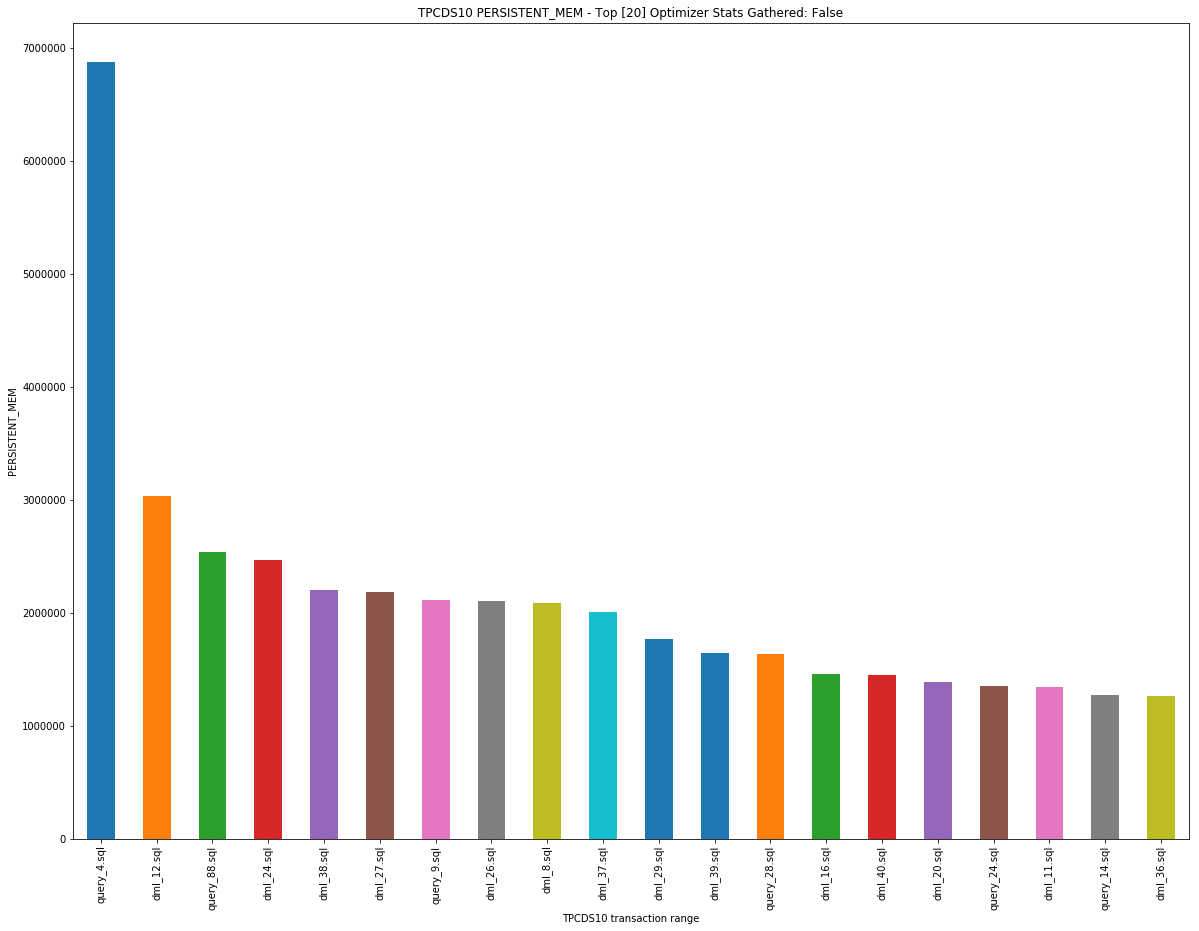

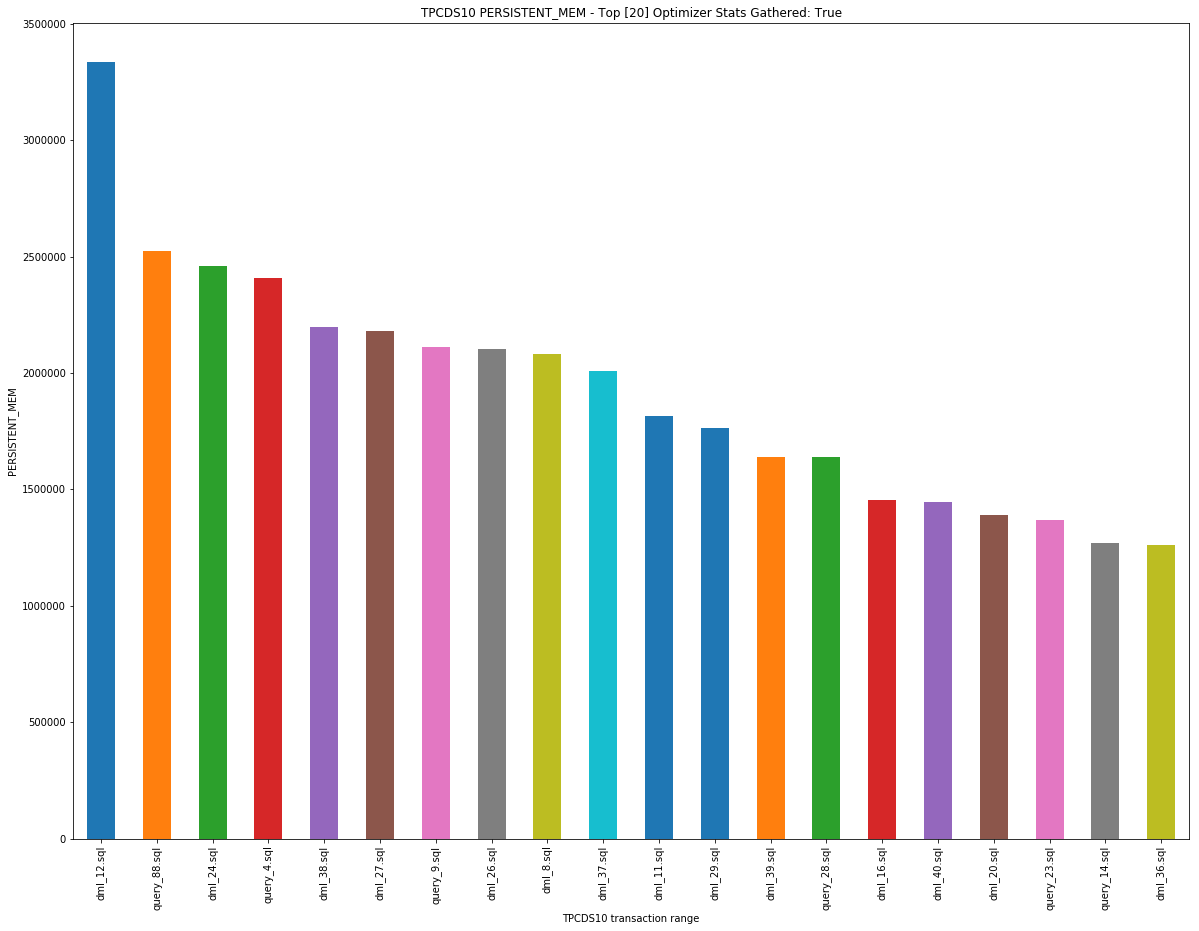

In [35]:
top_consumer_bar(table='rep_execution_plans', column='PERSISTENT_MEM', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='PERSISTENT_MEM', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Runtime Memory Distribution (Histogram Distribution)

Fixed amount of memory required during the execution of the child cursor

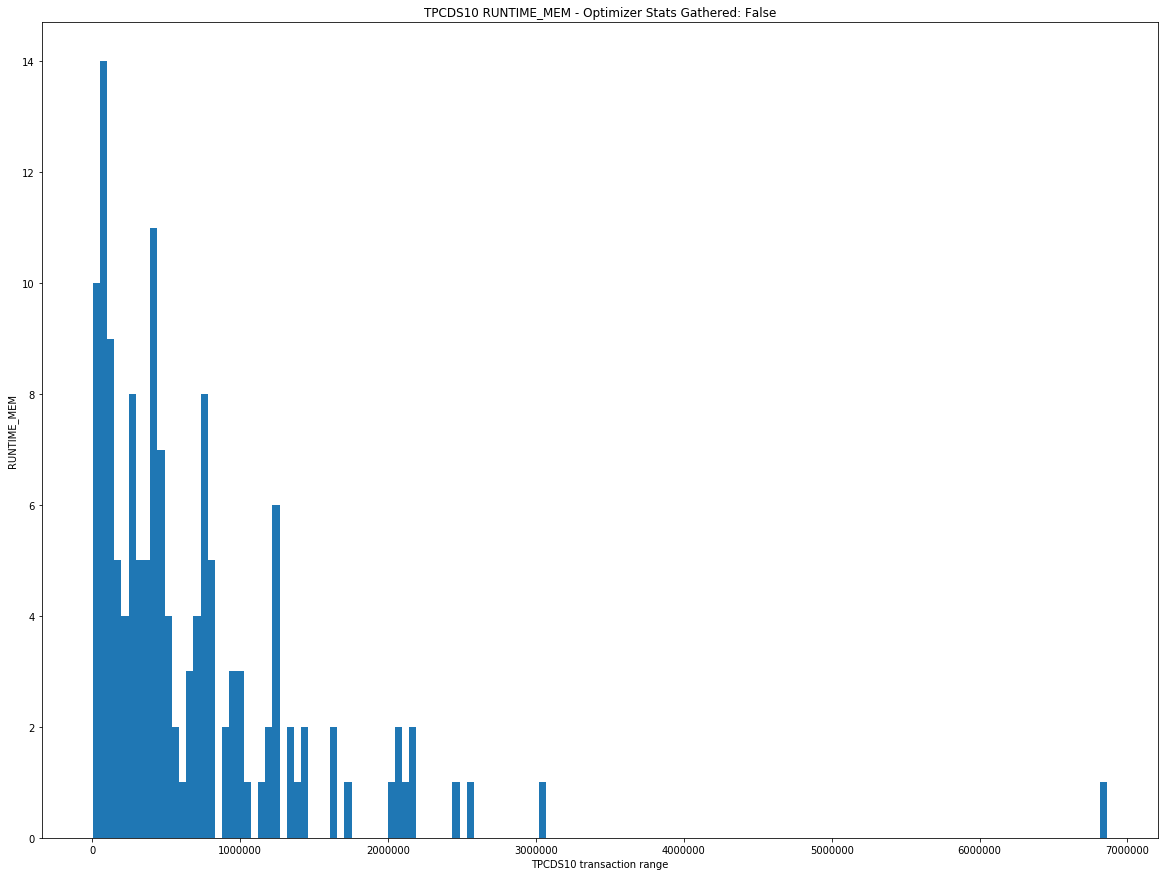

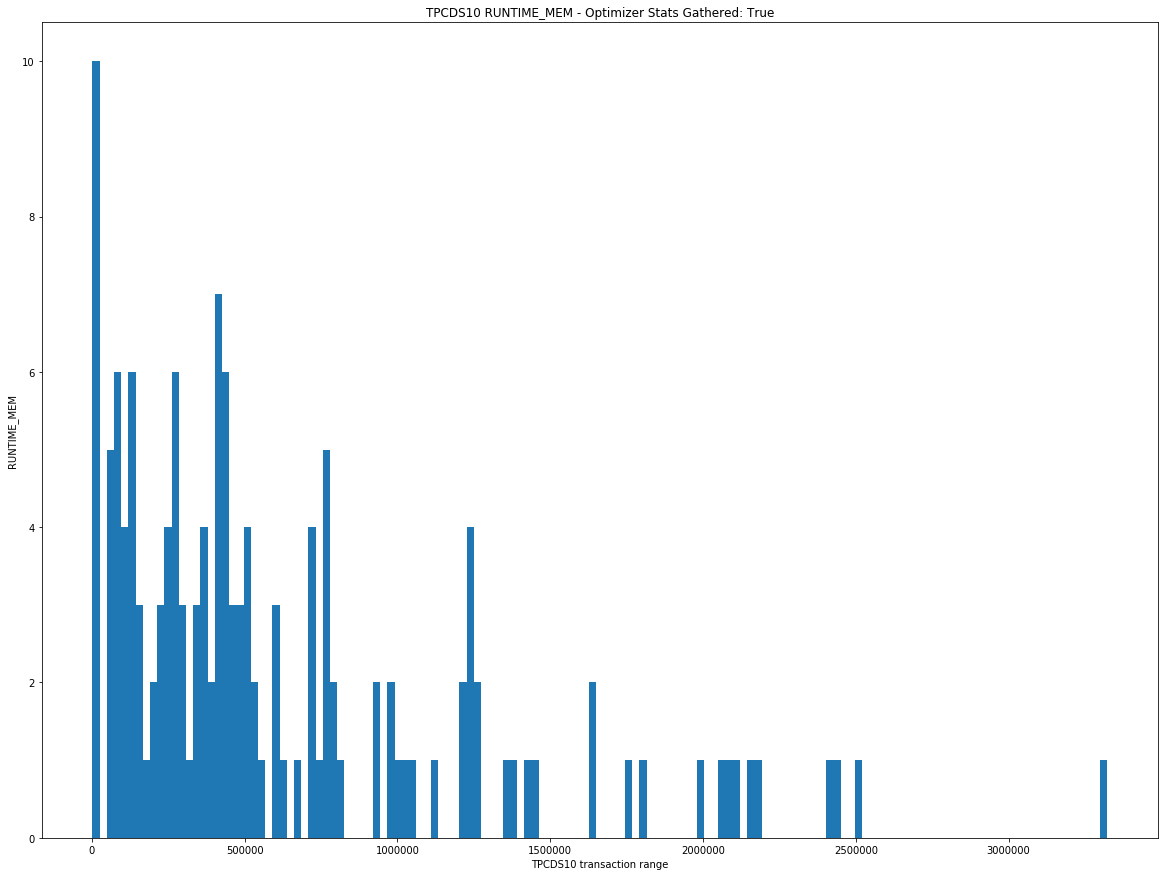

In [36]:
top_consumer_histogram(table='rep_execution_plans', column='RUNTIME_MEM', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='RUNTIME_MEM', tpc_type=tpcds, gathered_stats=True)

### Runtime Memory Distribution (Top 20 Transactions)

Fixed amount of memory required during the execution of the child cursor

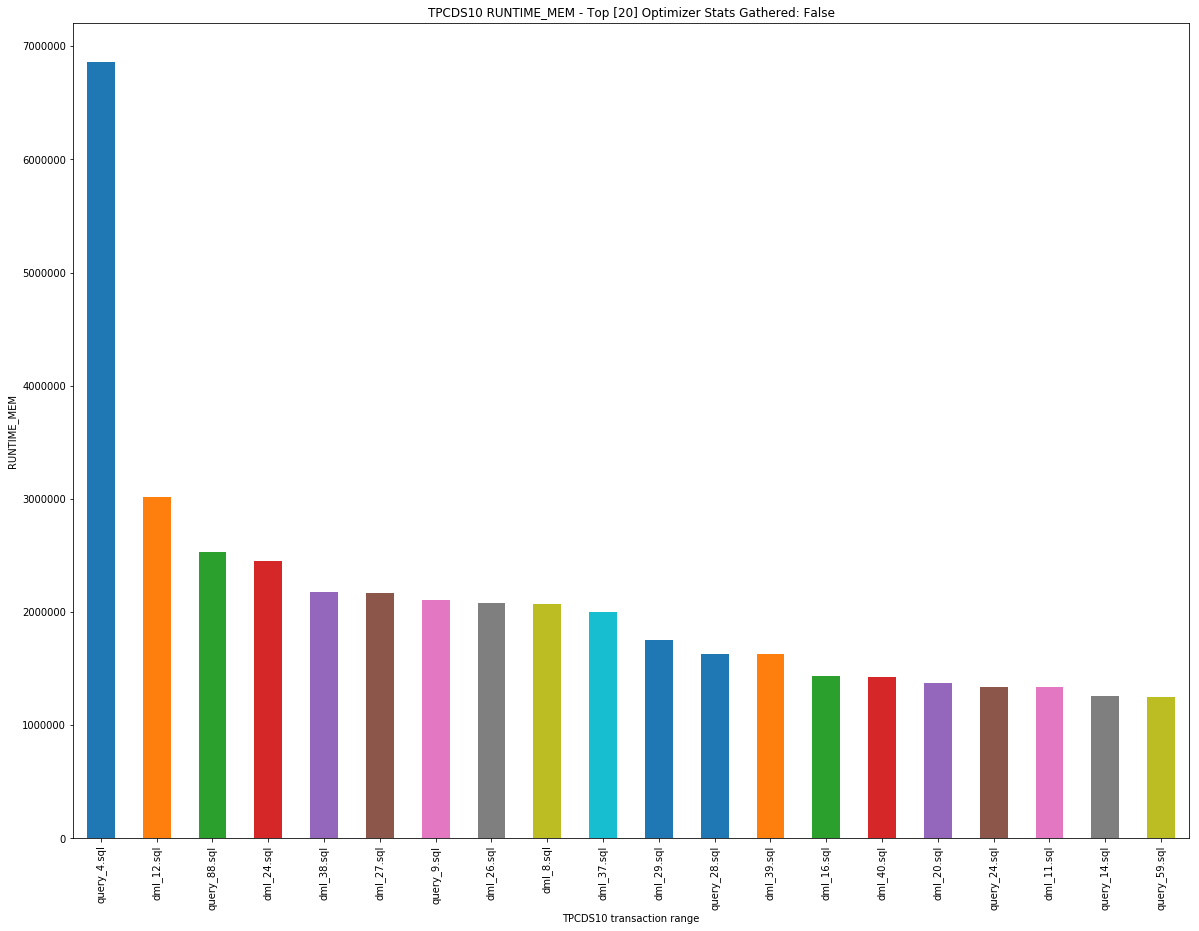

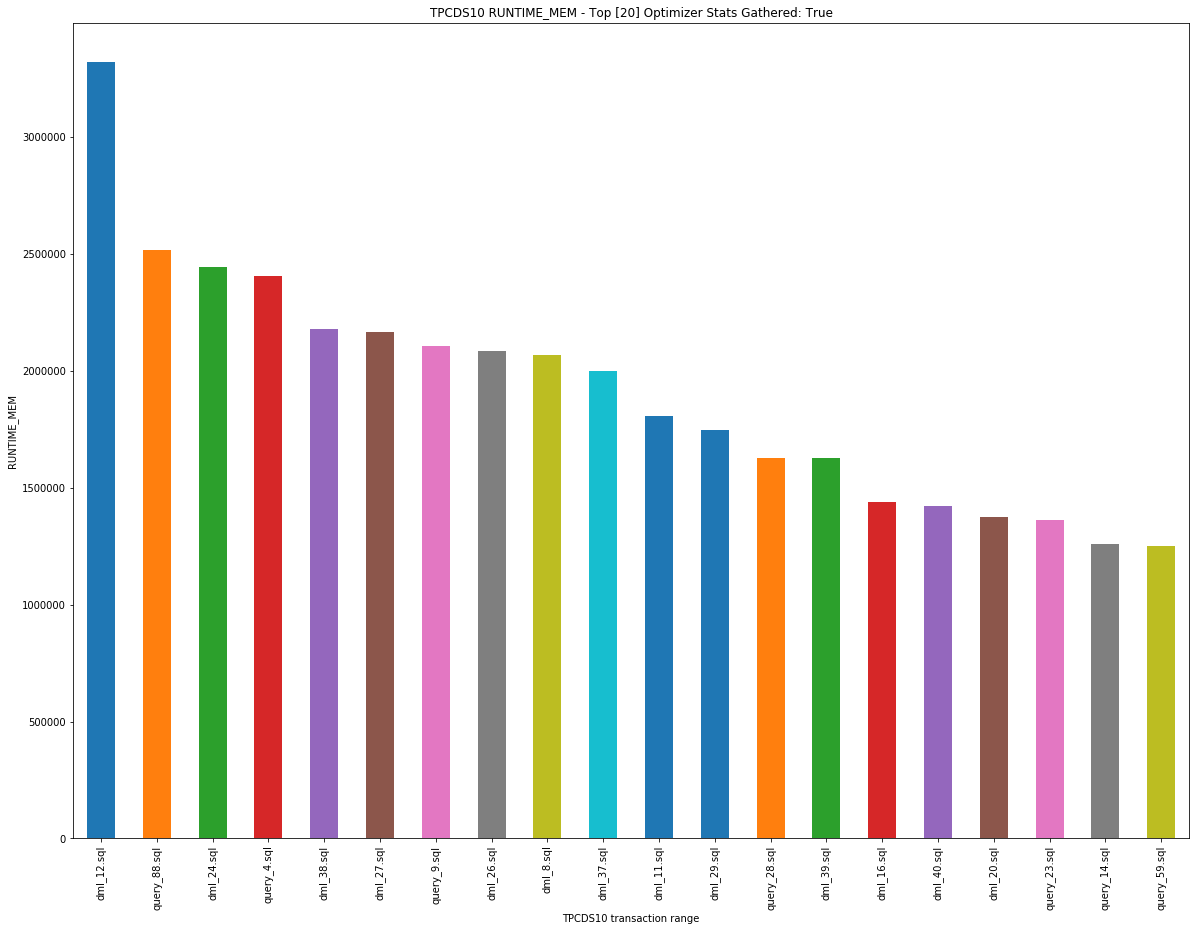

In [37]:
top_consumer_bar(table='rep_execution_plans', column='RUNTIME_MEM', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='RUNTIME_MEM', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Disk Read Distribution (Histogram Distribution)

Number of disk reads for this child cursor

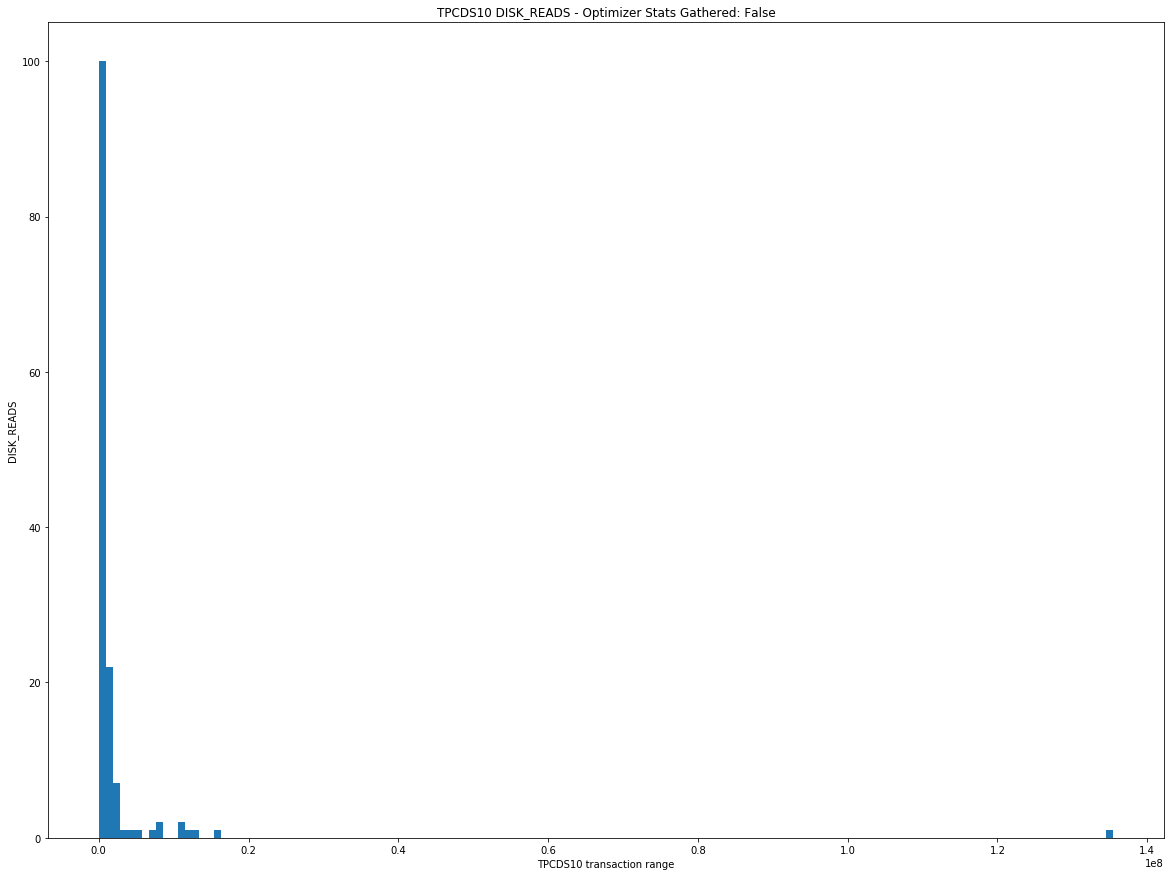

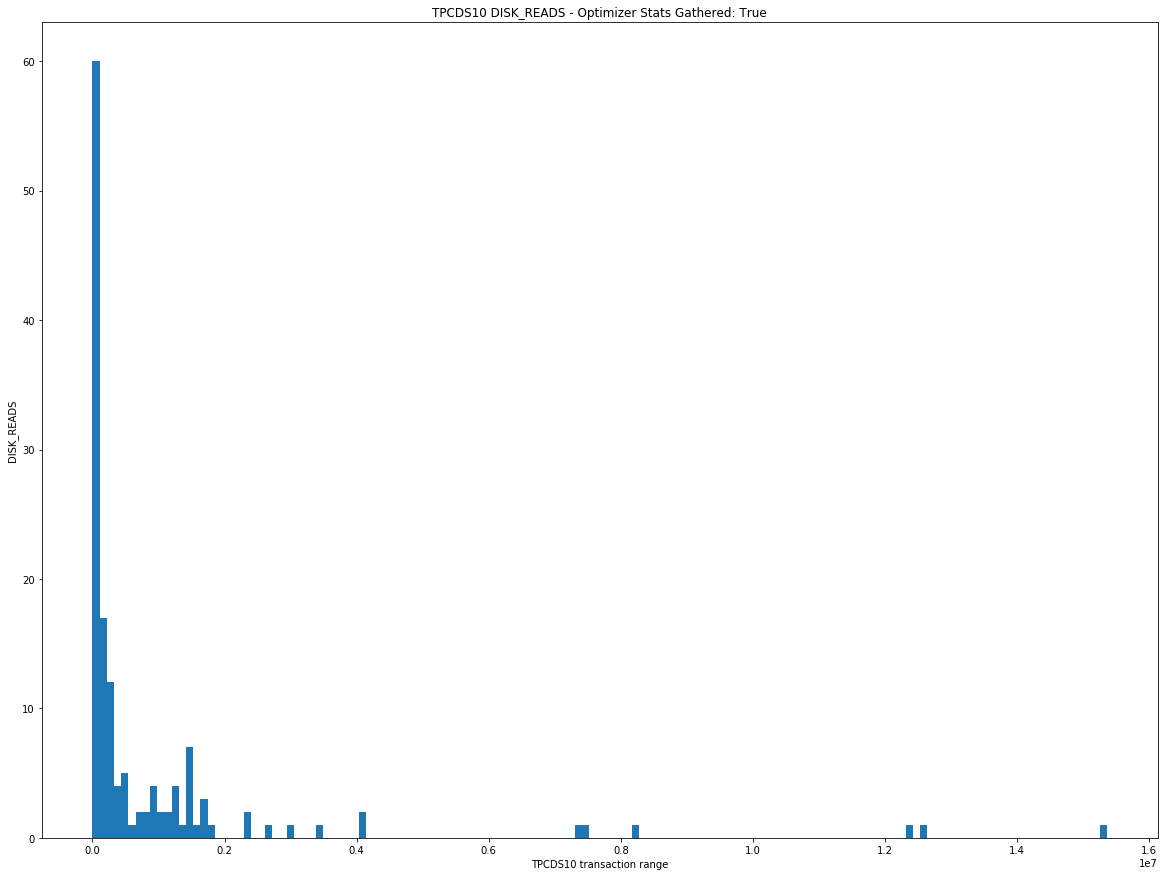

In [38]:
top_consumer_histogram(table='rep_execution_plans', column='DISK_READS', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='DISK_READS', tpc_type=tpcds, gathered_stats=True)

### Disk Read Distribution (Top 20 Transactions)

Number of disk reads for this child cursor

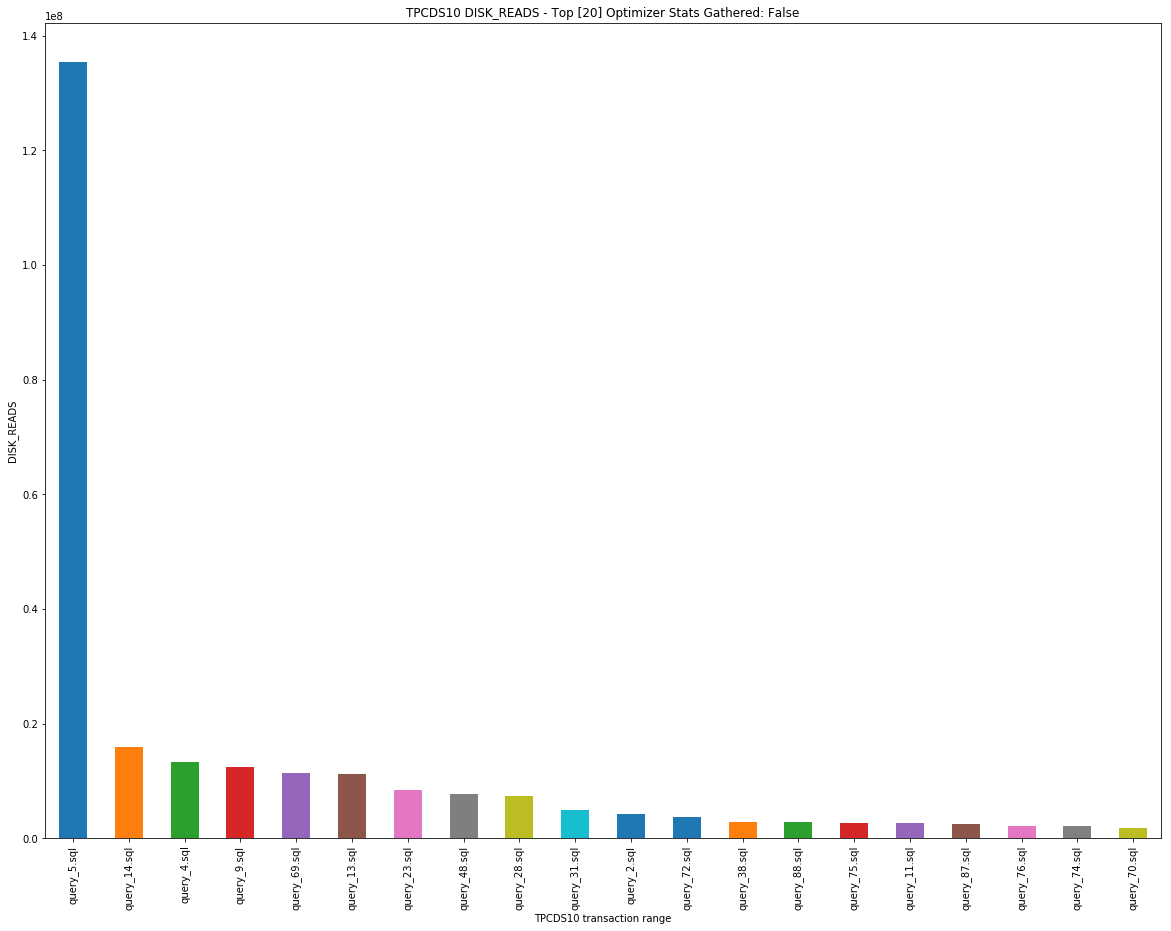

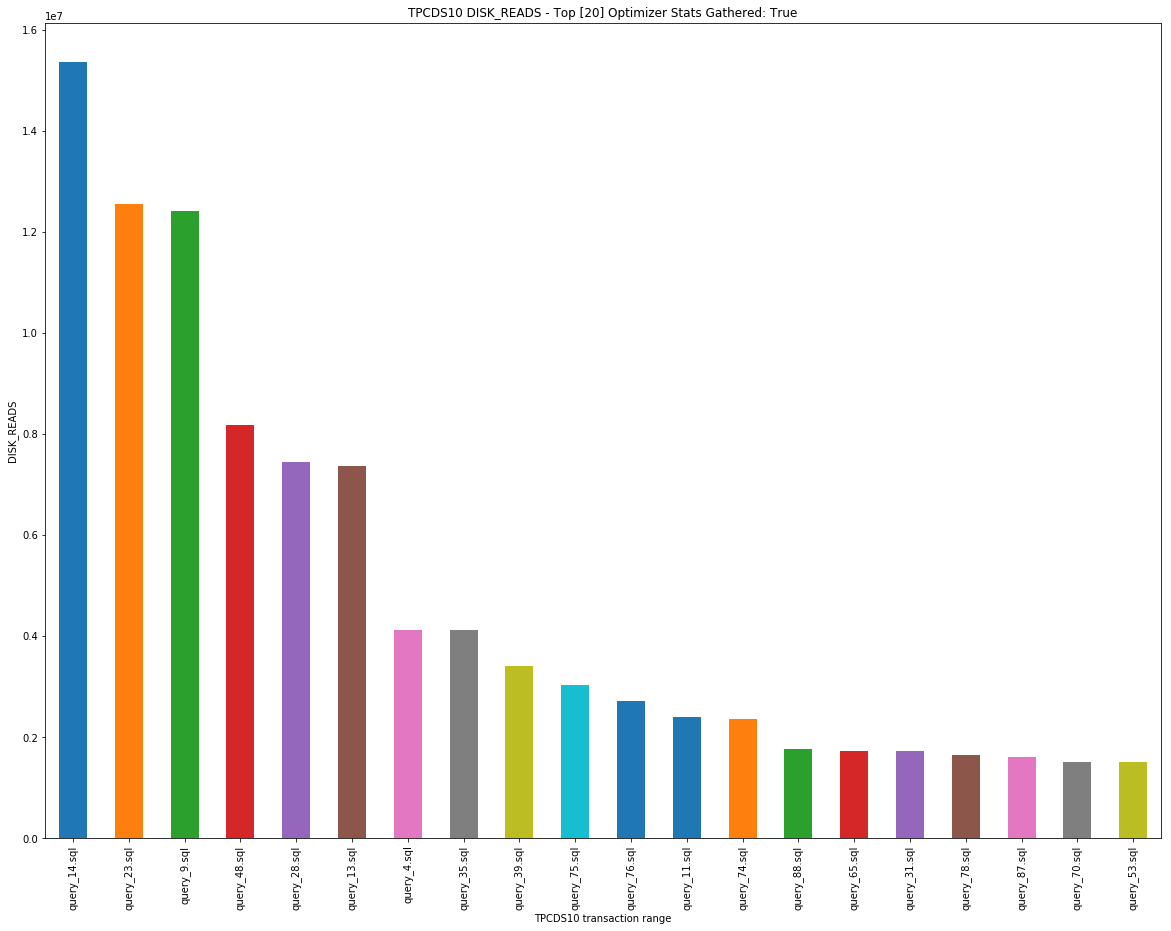

In [39]:
top_consumer_bar(table='rep_execution_plans', column='DISK_READS', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='DISK_READS', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Direct Write Distribution (Histogram Distribution)

Number of direct writes for this child cursor

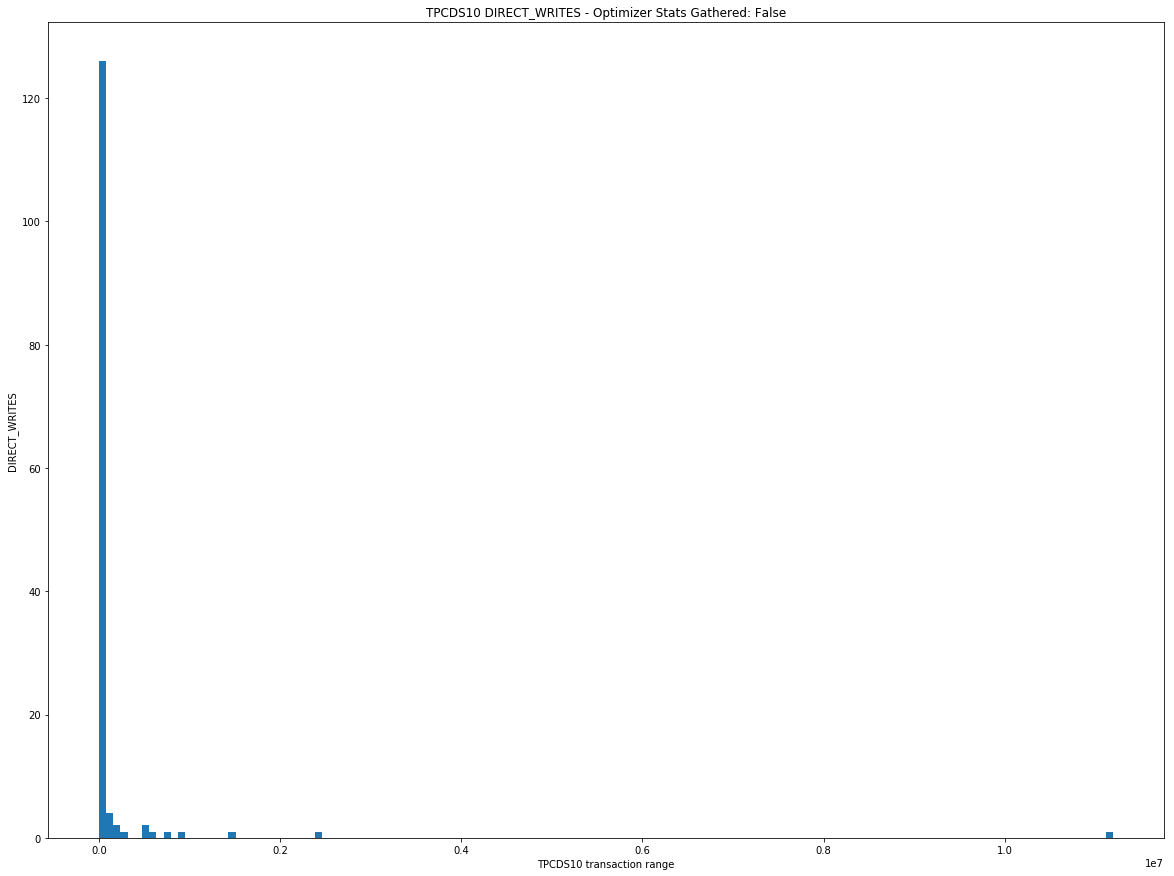

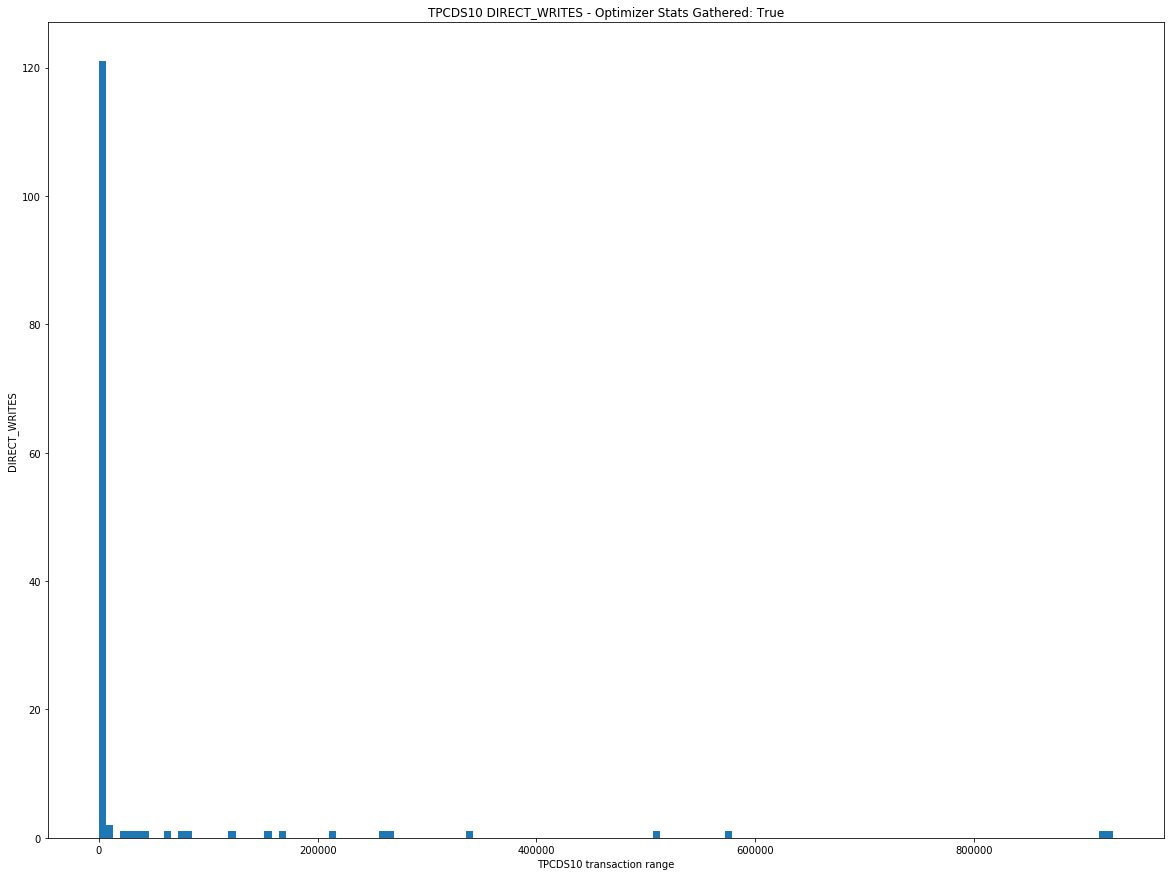

In [40]:
top_consumer_histogram(table='rep_execution_plans', column='DIRECT_WRITES', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='DIRECT_WRITES', tpc_type=tpcds, gathered_stats=True)

### Direct Write Distribution (Top 20 Transactions)

Number of direct writes for this child cursor

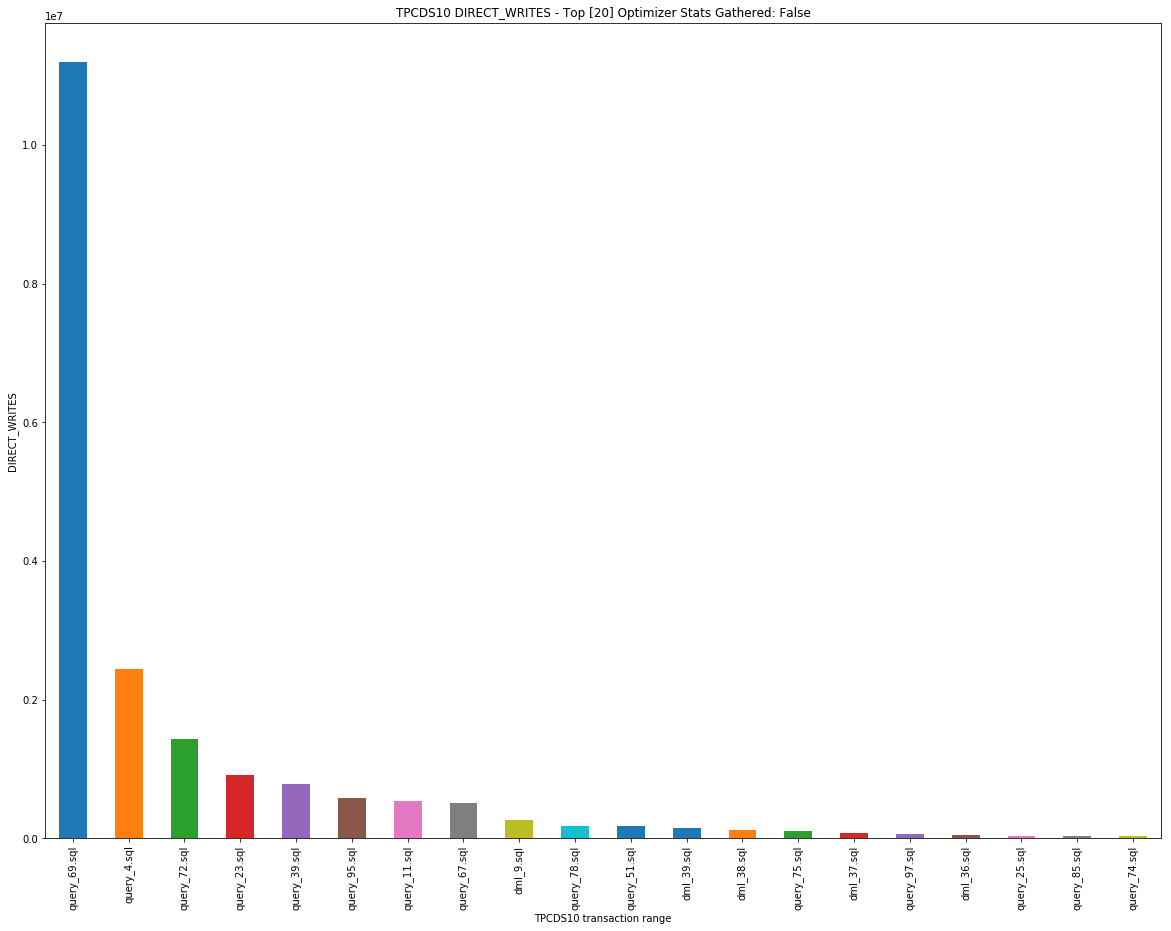

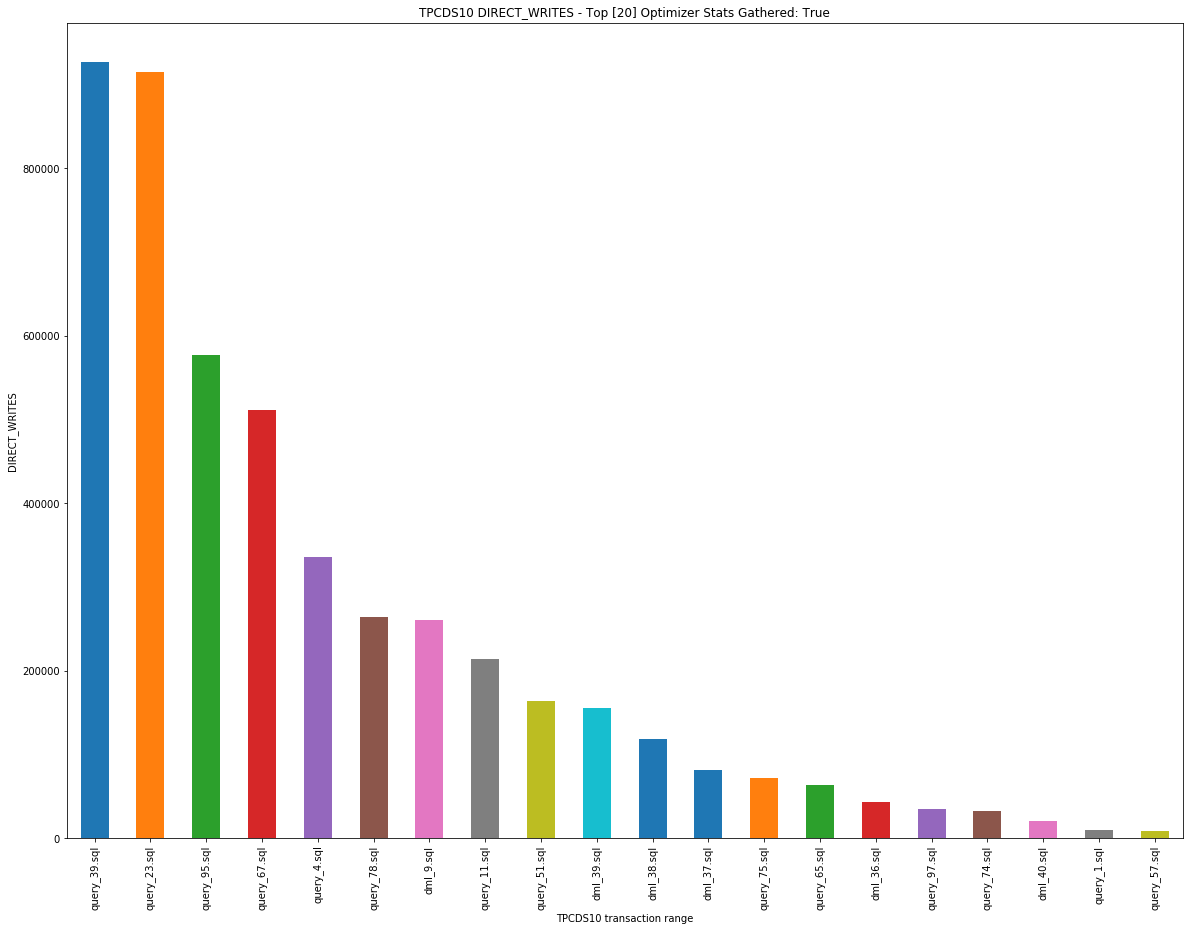

In [41]:
top_consumer_bar(table='rep_execution_plans', column='DIRECT_WRITES', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='DIRECT_WRITES', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Buffer Gets Distribution (Histogram Distribution)

Number of buffer gets for this child cursor

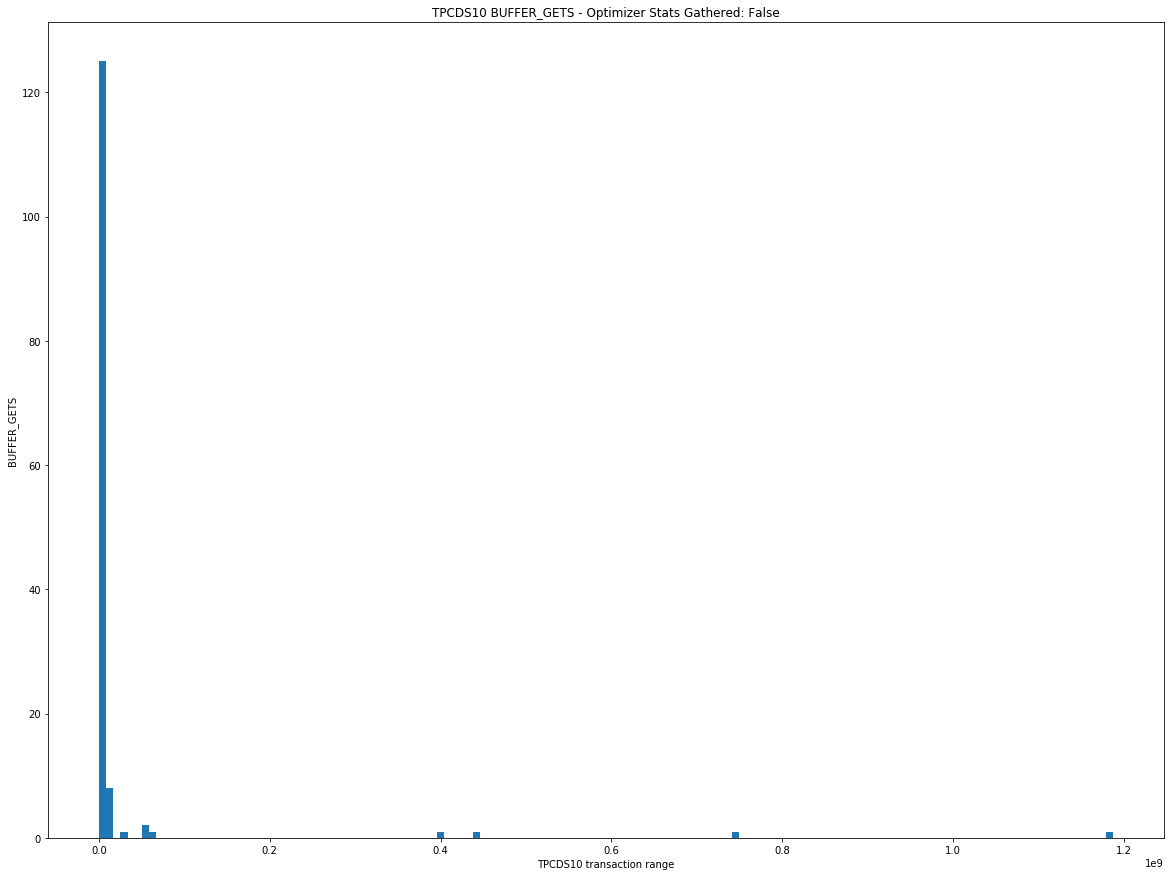

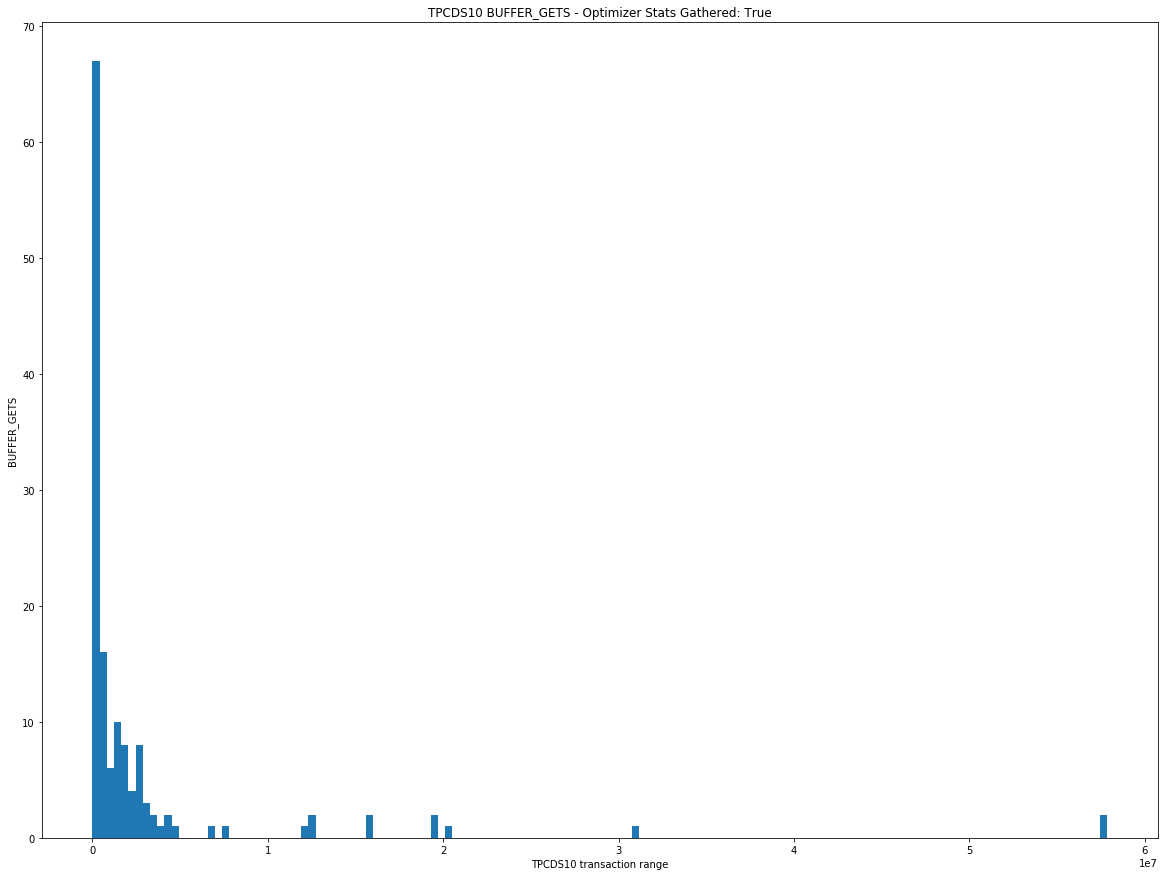

In [42]:
top_consumer_histogram(table='rep_execution_plans', column='BUFFER_GETS', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='BUFFER_GETS', tpc_type=tpcds, gathered_stats=True)

### Buffer Gets Distribution (Top 20 Transactions)

Number of buffer gets for this child cursor

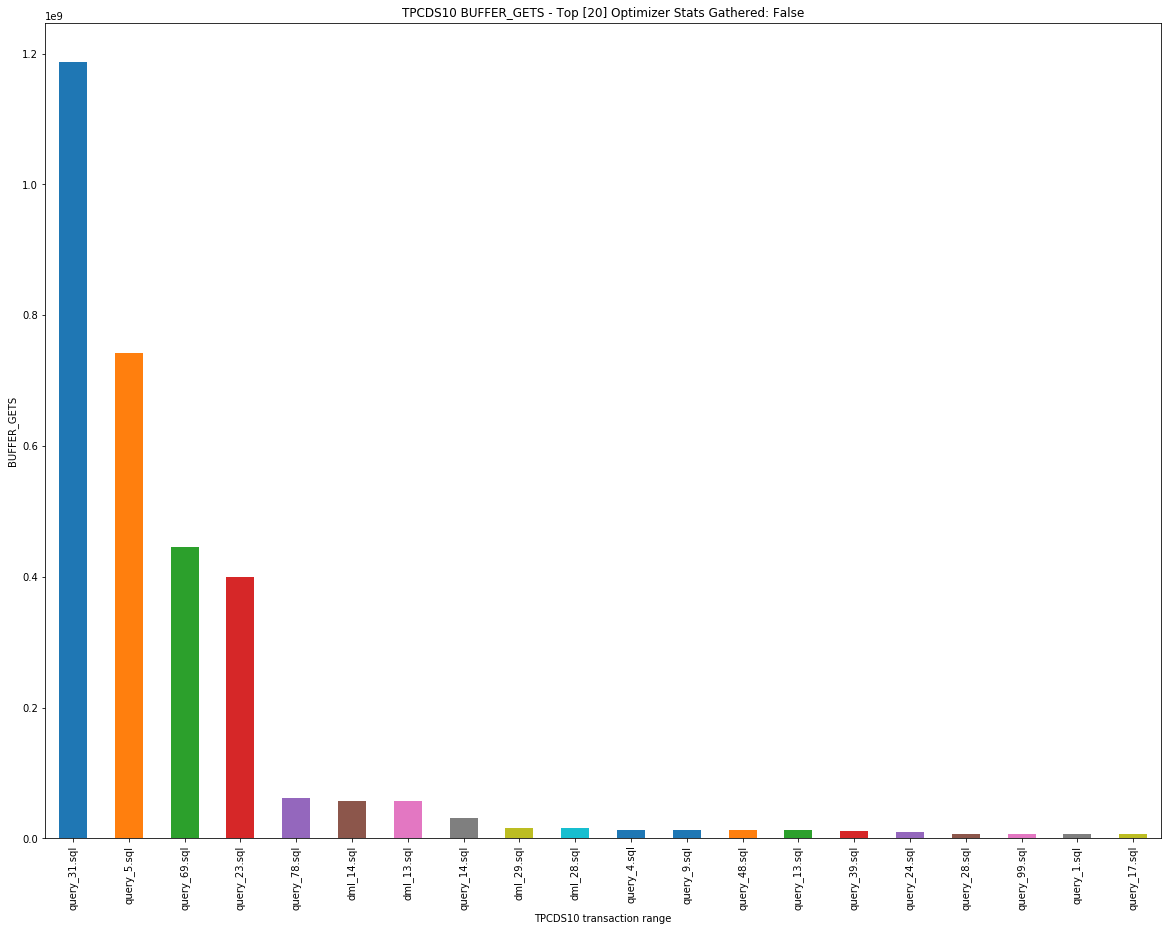

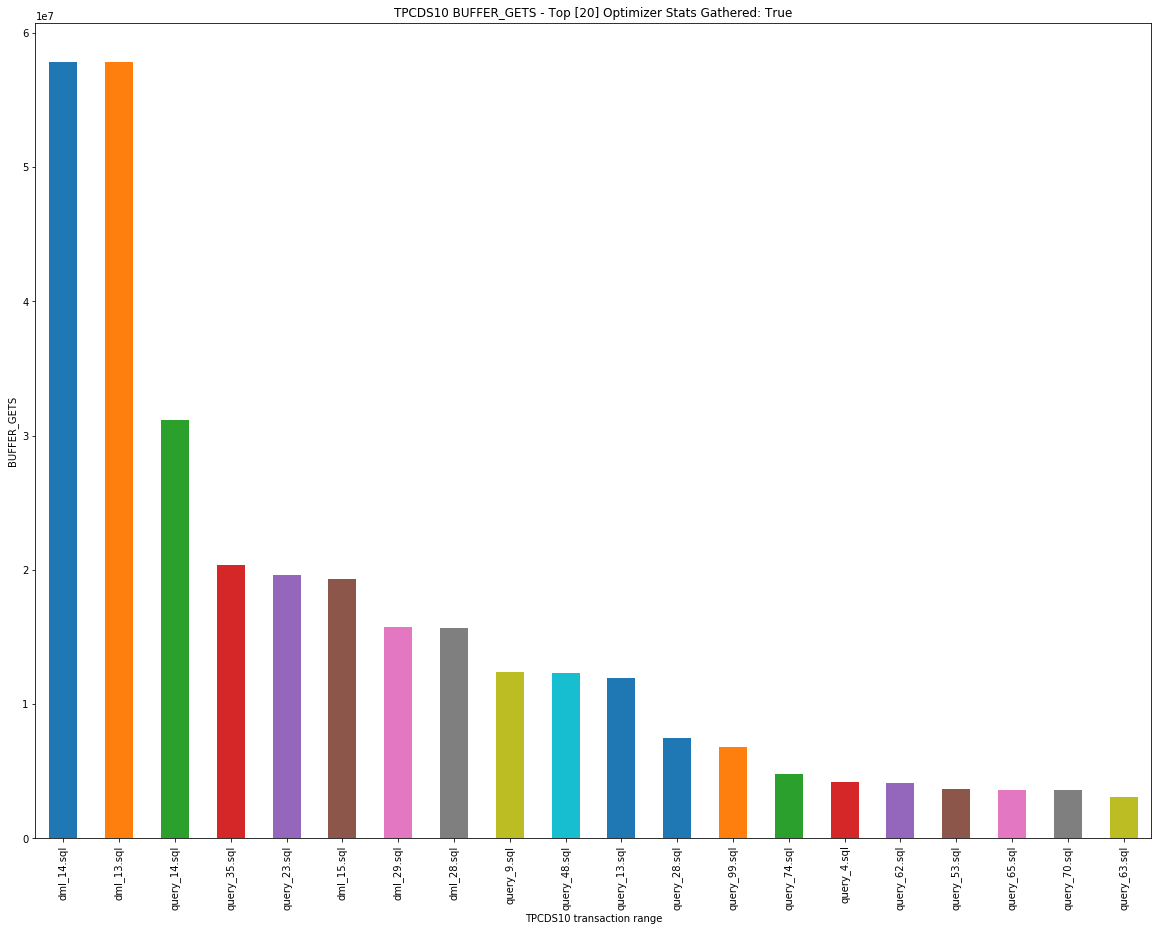

In [43]:
top_consumer_bar(table='rep_execution_plans', column='BUFFER_GETS', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='BUFFER_GETS', tpc_type=tpcds, gathered_stats=True,top_n=20)

### User IO Wait Time Distribution (Histogram Distribution)

User I/O Wait Time (in microseconds)

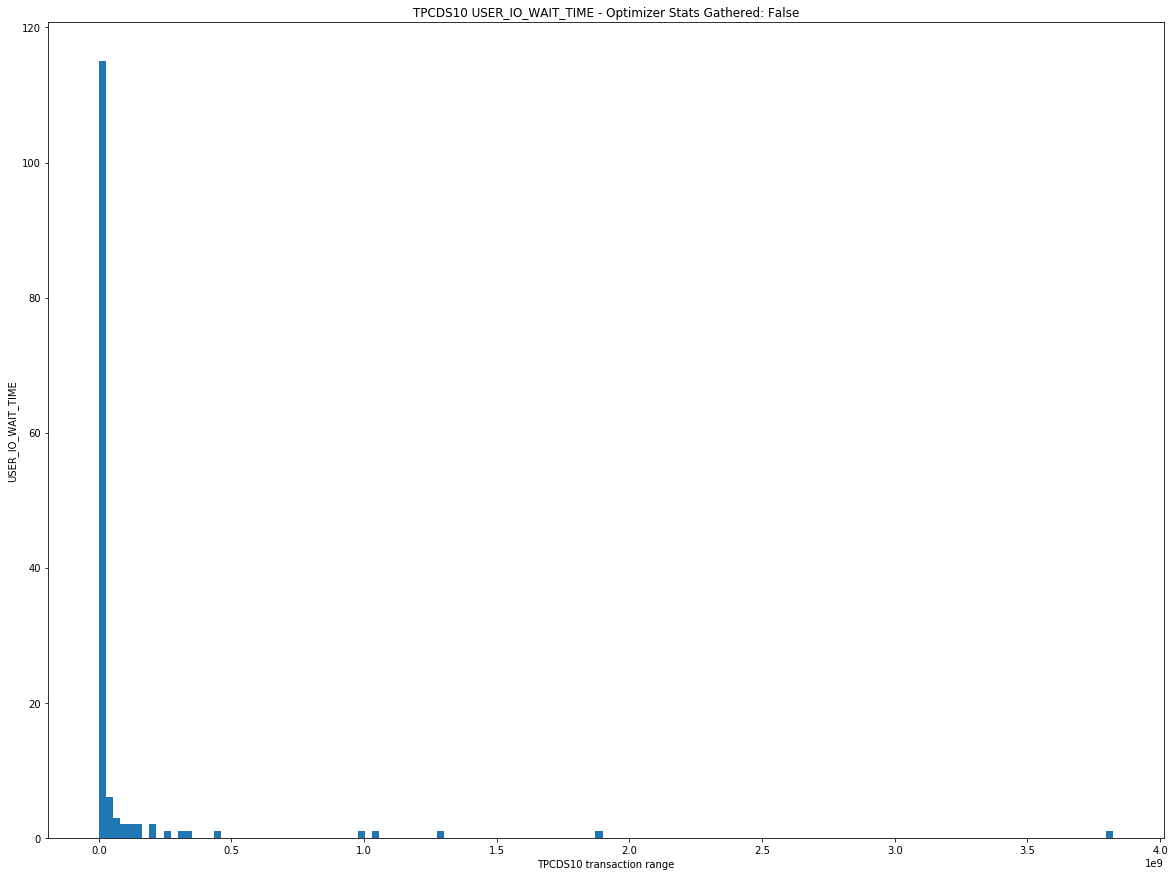

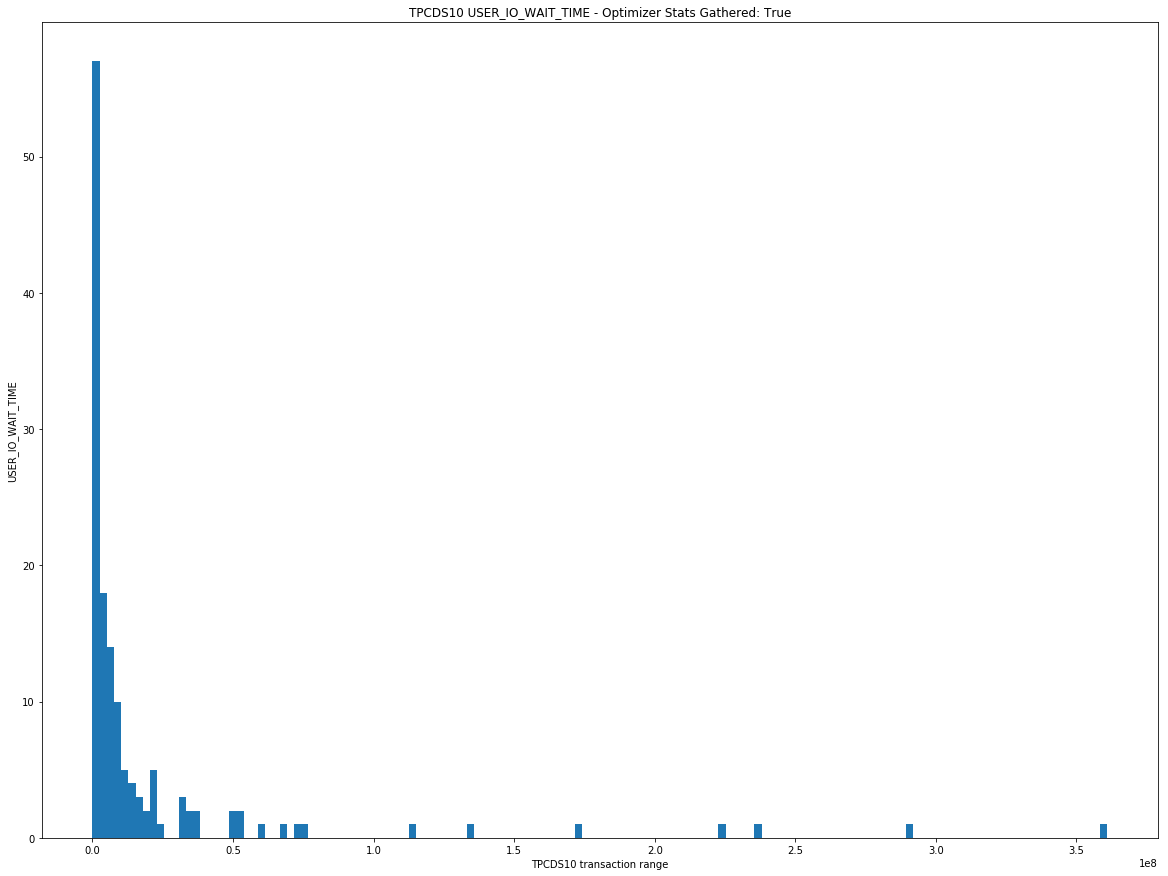

In [44]:
top_consumer_histogram(table='rep_execution_plans', column='USER_IO_WAIT_TIME', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='USER_IO_WAIT_TIME', tpc_type=tpcds, gathered_stats=True)

### User IO Wait Time Distribution (Top 20 Transactions)

User I/O Wait Time (in microseconds)

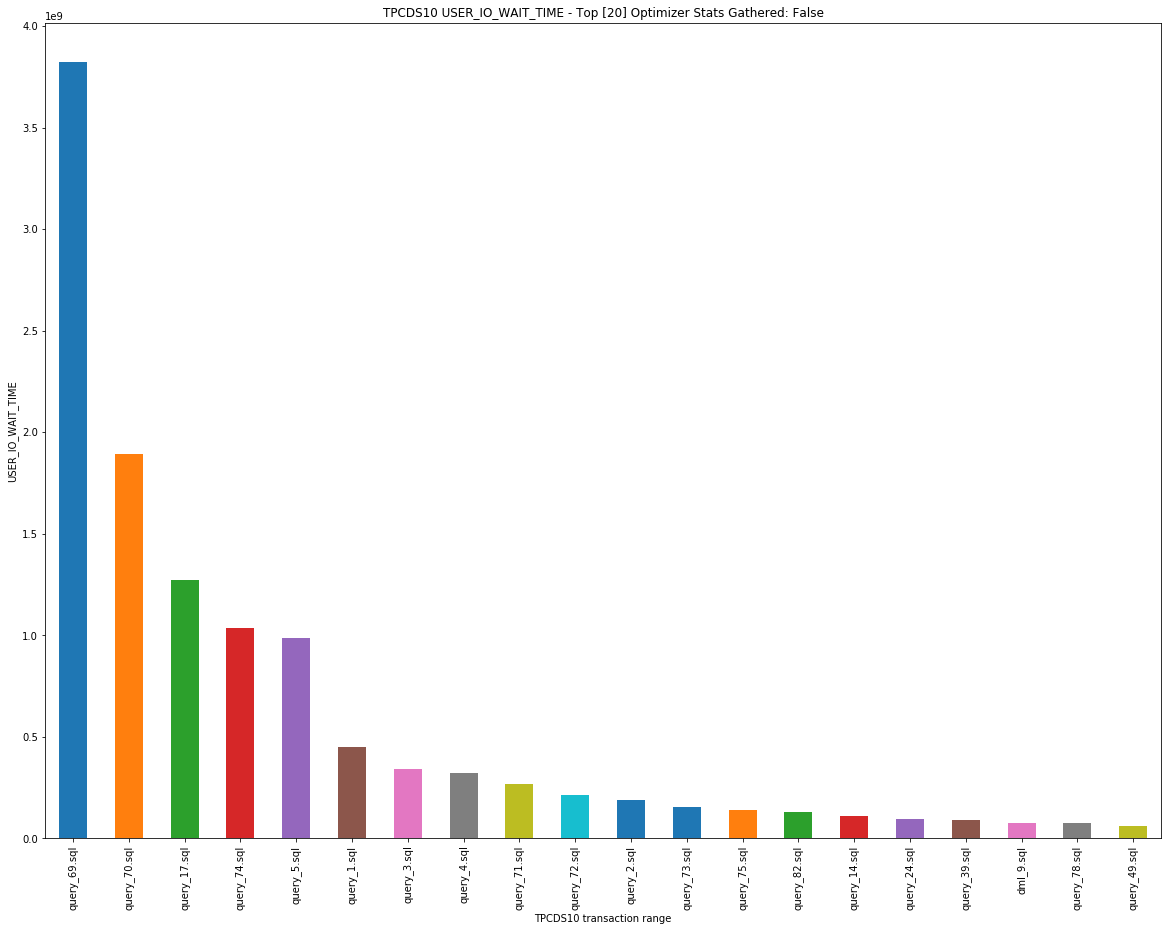

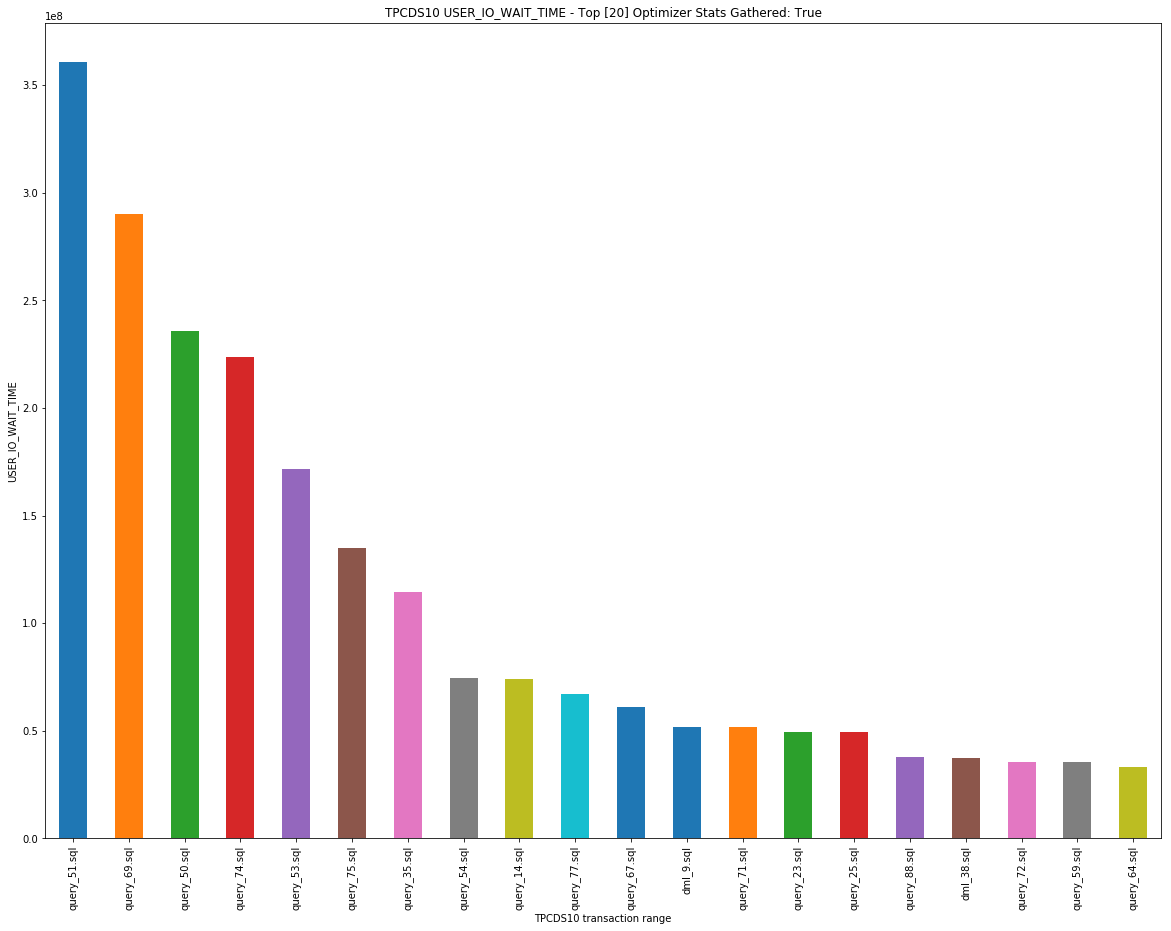

In [45]:
top_consumer_bar(table='rep_execution_plans', column='USER_IO_WAIT_TIME', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='USER_IO_WAIT_TIME', tpc_type=tpcds, gathered_stats=True,top_n=20)

### PLSQL Exec Time Distribution (Histogram Distribution)

PL/SQL execution time (in microseconds)

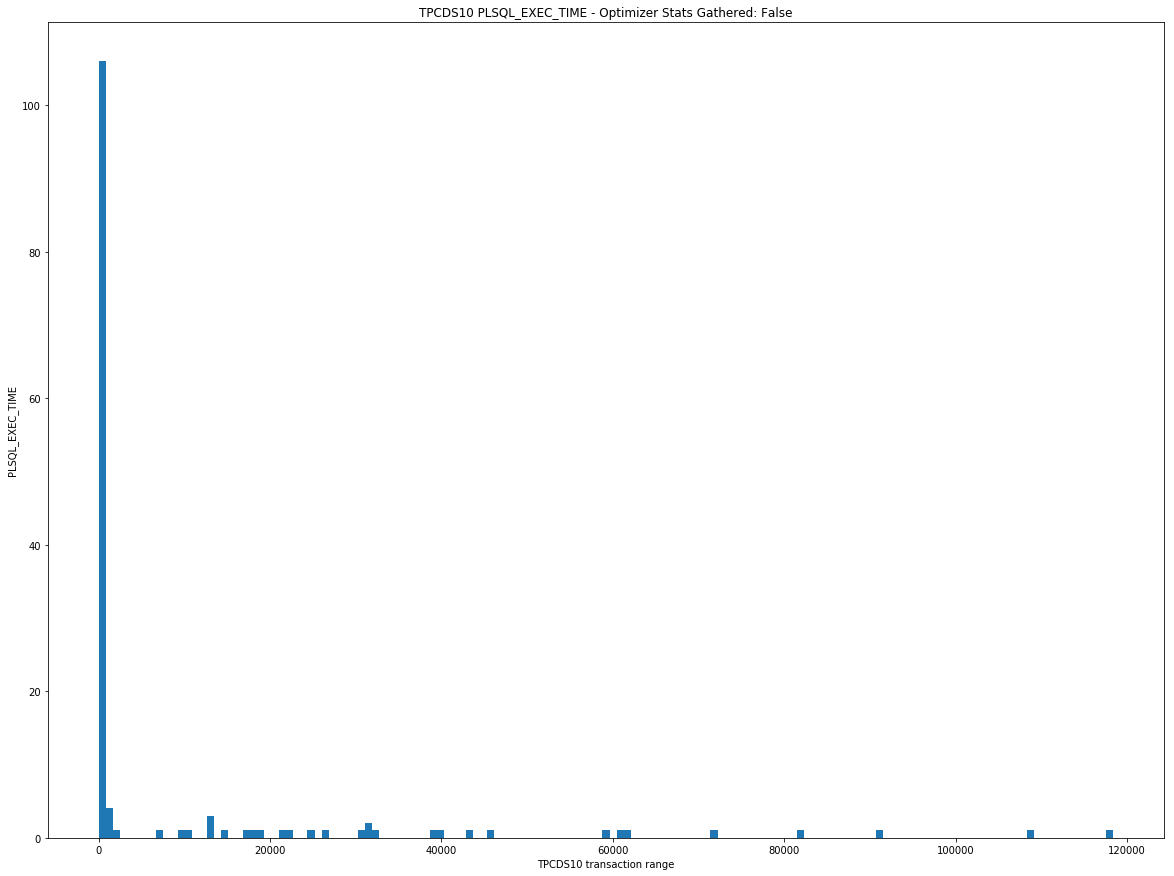

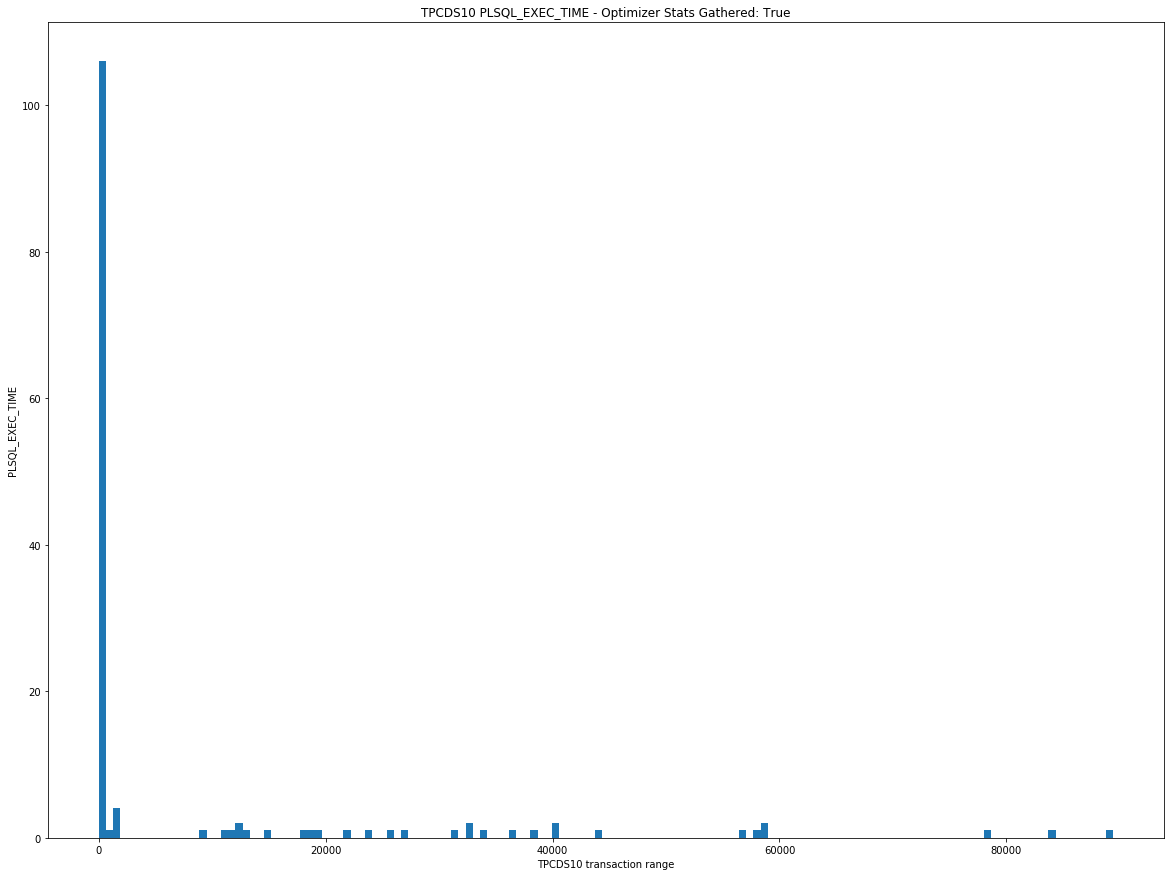

In [46]:
top_consumer_histogram(table='rep_execution_plans', column='PLSQL_EXEC_TIME', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='PLSQL_EXEC_TIME', tpc_type=tpcds, gathered_stats=True)

### PLSQL Exec Time Distribution (Top 20 Transactions)

PL/SQL execution time (in microseconds)

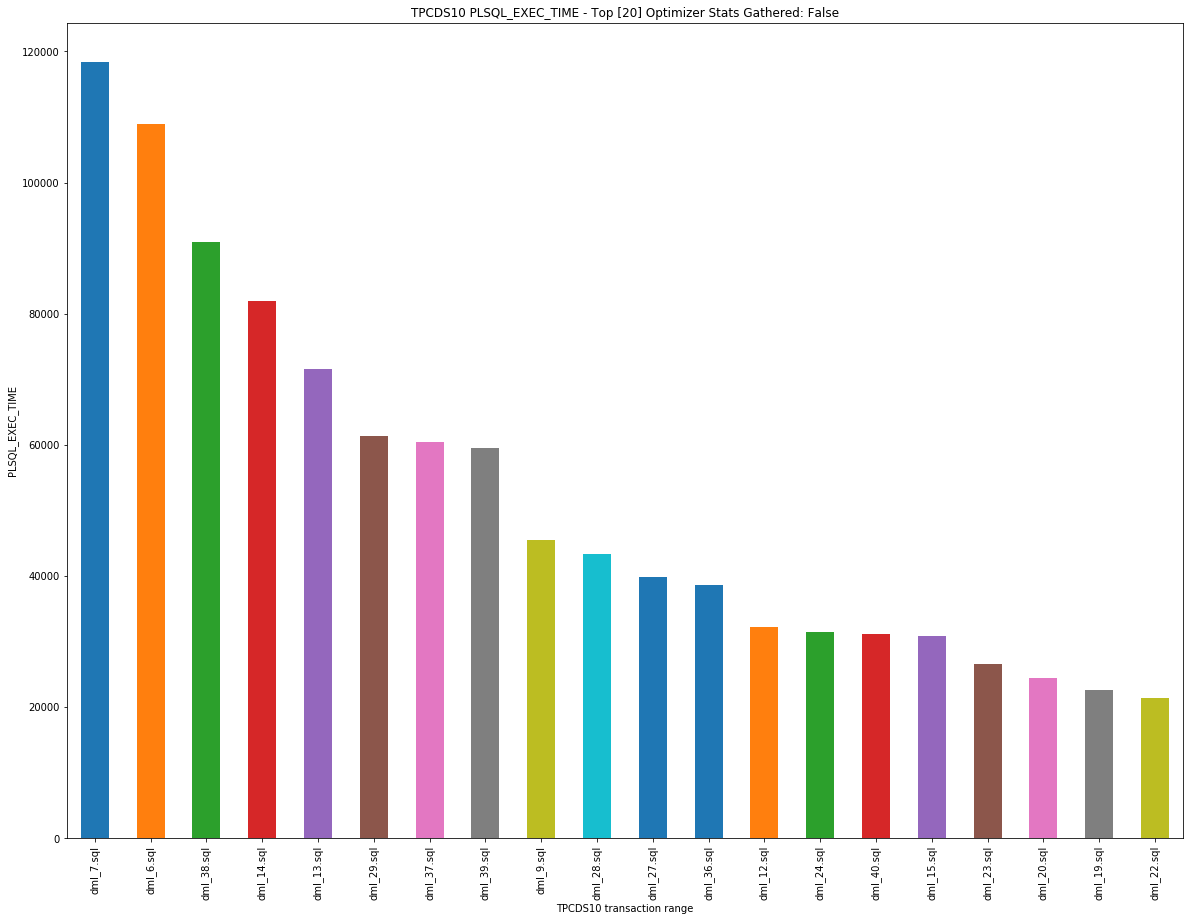

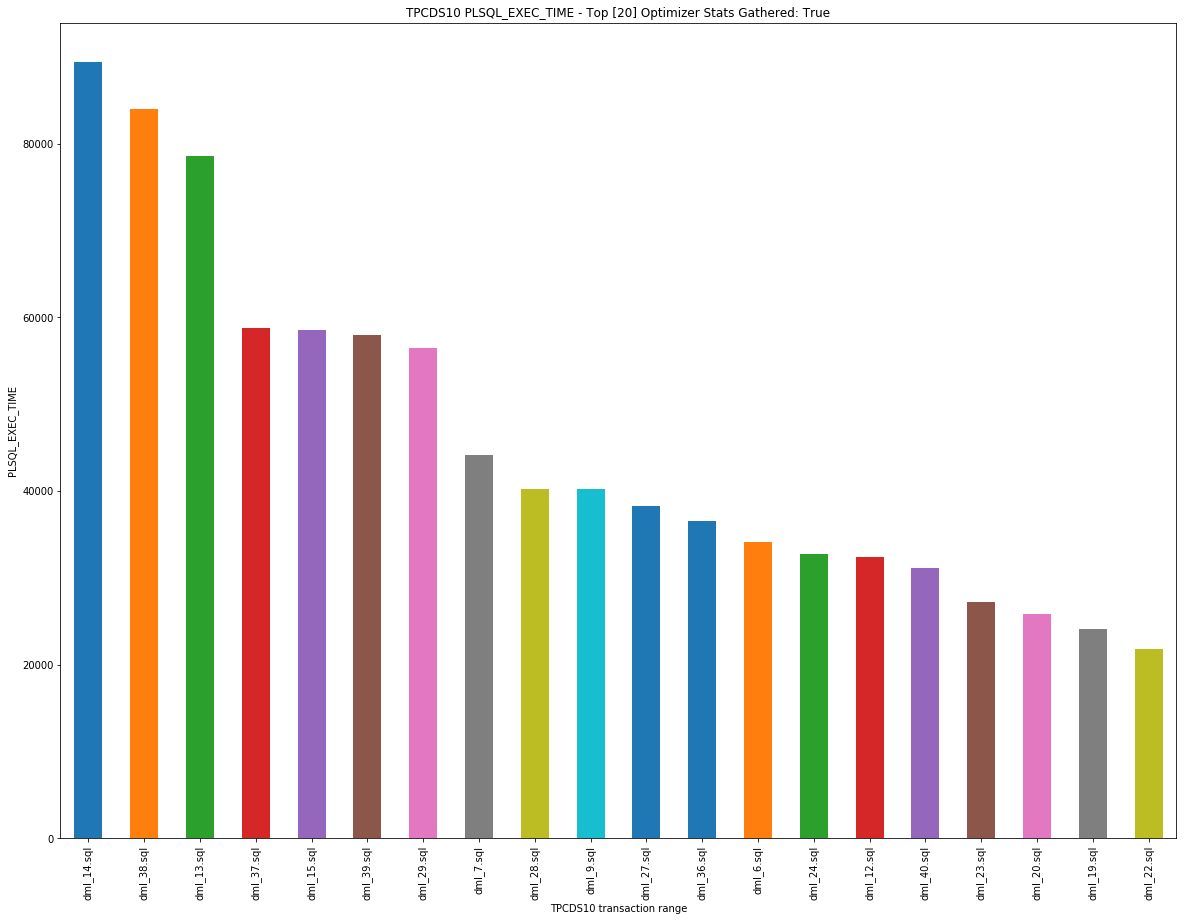

In [47]:
top_consumer_bar(table='rep_execution_plans', column='PLSQL_EXEC_TIME', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='PLSQL_EXEC_TIME', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Rows Processed Distribution (Histogram Distribution)

Total number of rows the parsed SQL statement returns

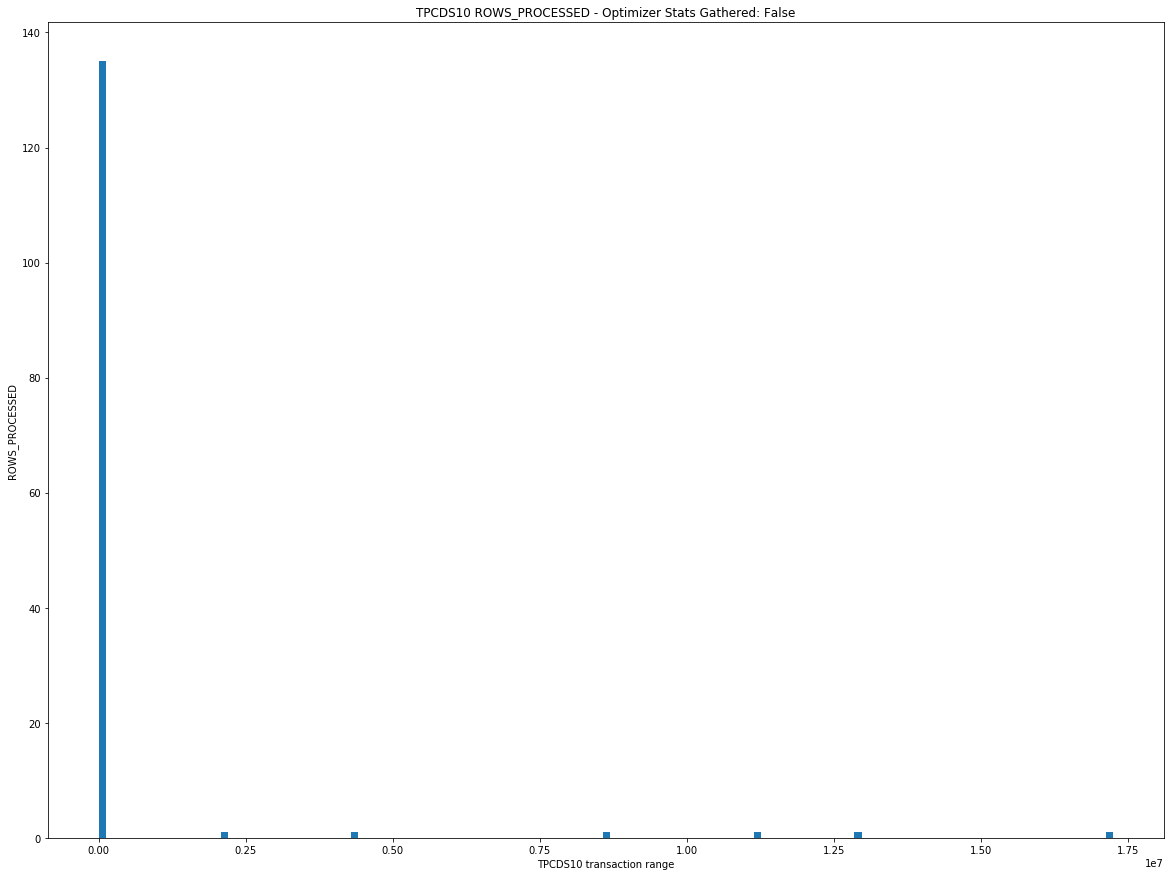

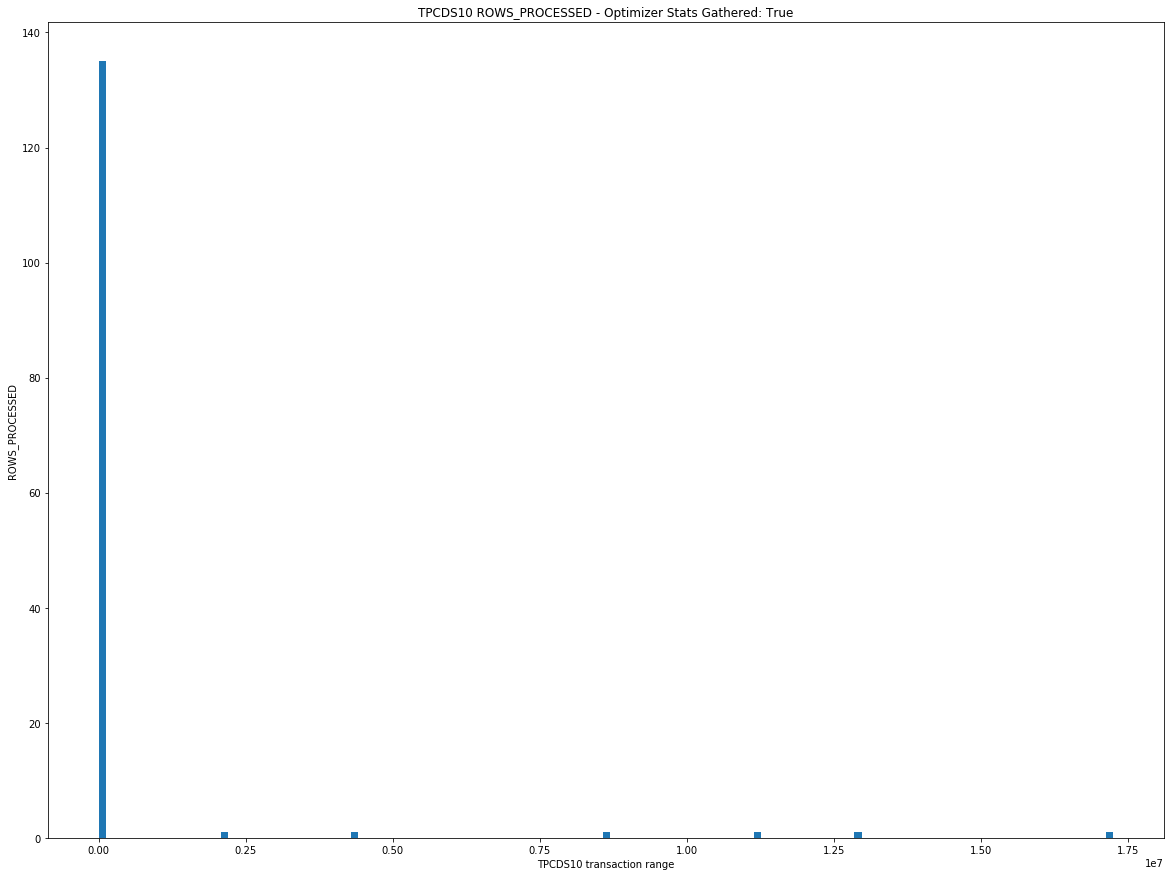

In [48]:
top_consumer_histogram(table='rep_execution_plans', column='ROWS_PROCESSED', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='ROWS_PROCESSED', tpc_type=tpcds, gathered_stats=True)

### Rows Processed Distribution (Top 20 Transactions)

Total number of rows the parsed SQL statement returns

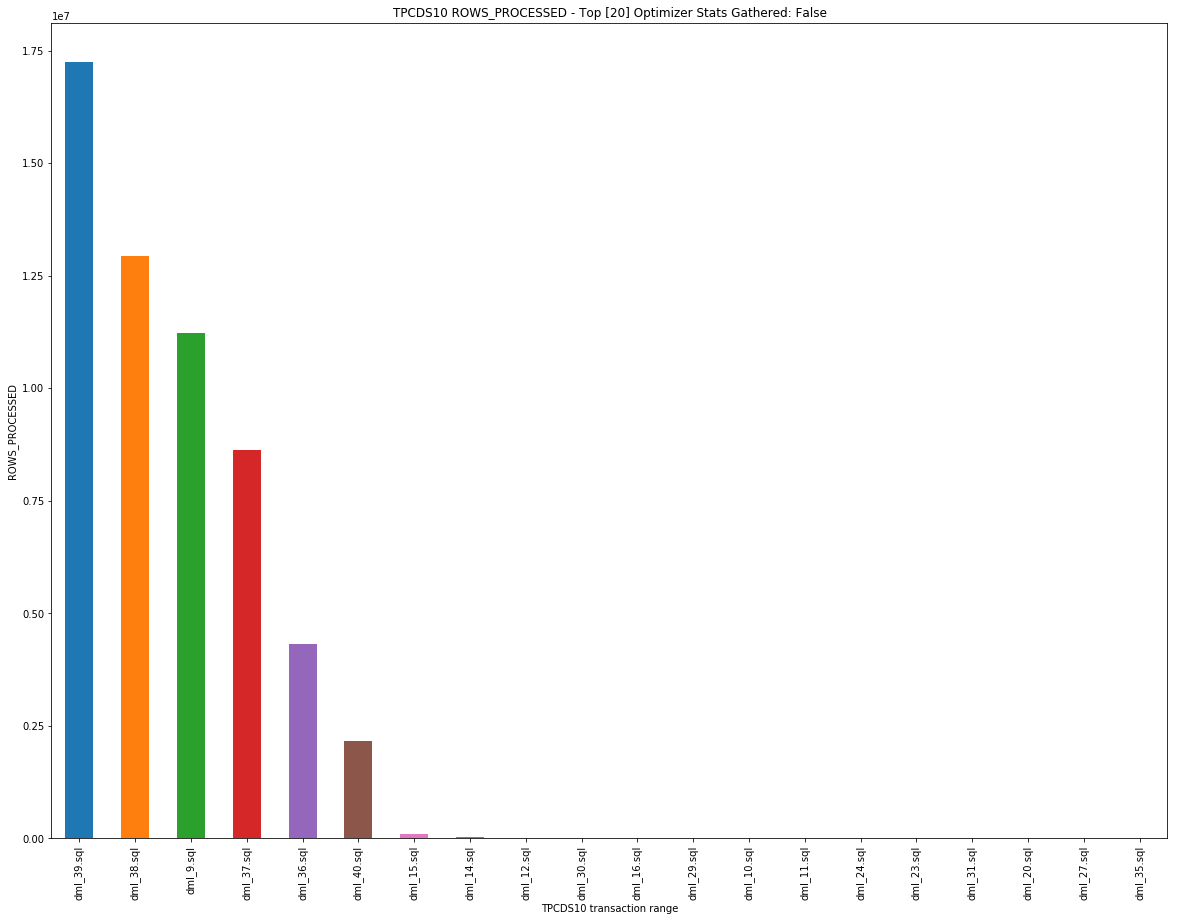

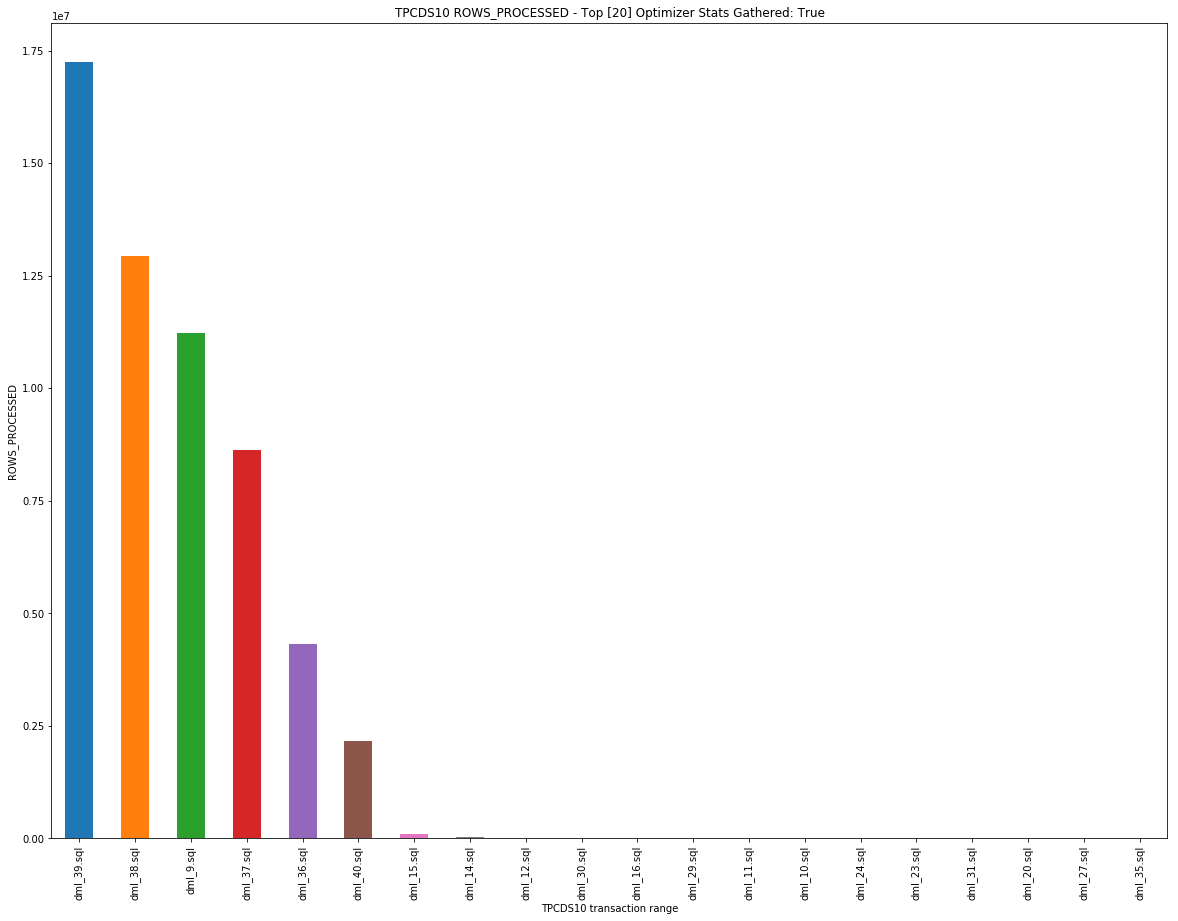

In [49]:
top_consumer_bar(table='rep_execution_plans', column='ROWS_PROCESSED', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='ROWS_PROCESSED', tpc_type=tpcds, gathered_stats=True,top_n=20)

### CPU Time Distribution (Histogram Distribution)

CPU time (in microseconds) used by this cursor for parsing, executing, and fetching

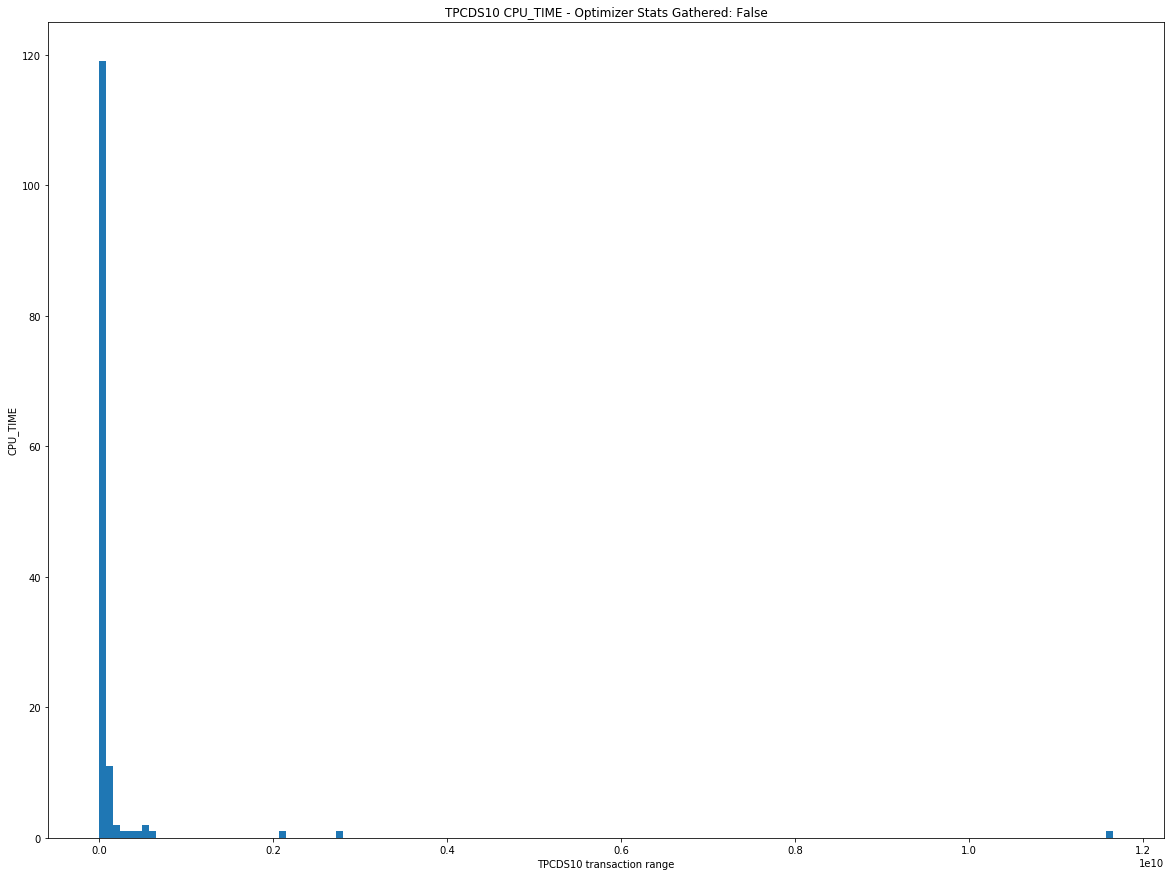

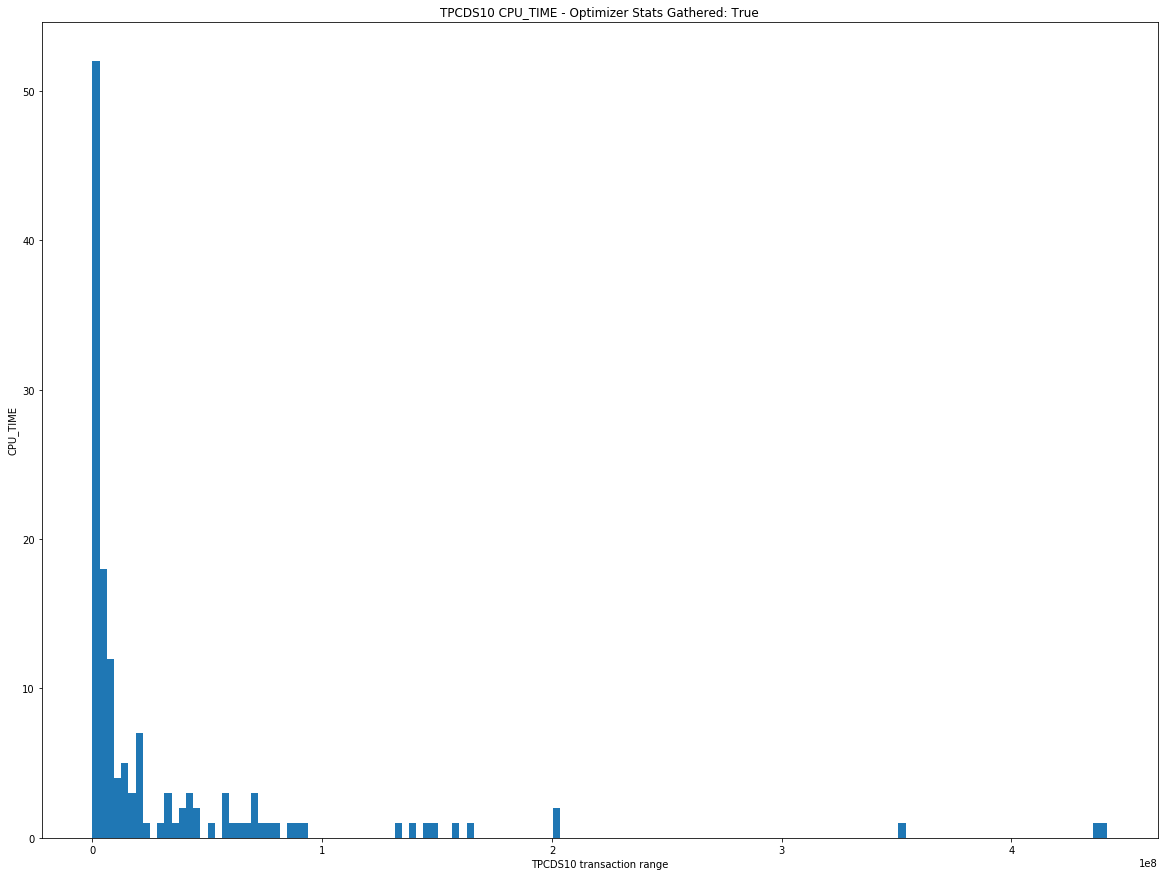

In [50]:
top_consumer_histogram(table='rep_execution_plans', column='CPU_TIME', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='CPU_TIME', tpc_type=tpcds, gathered_stats=True)

### CPU Time Distribution (Top 20 Transactions)

CPU time (in microseconds) used by this cursor for parsing, executing, and fetching

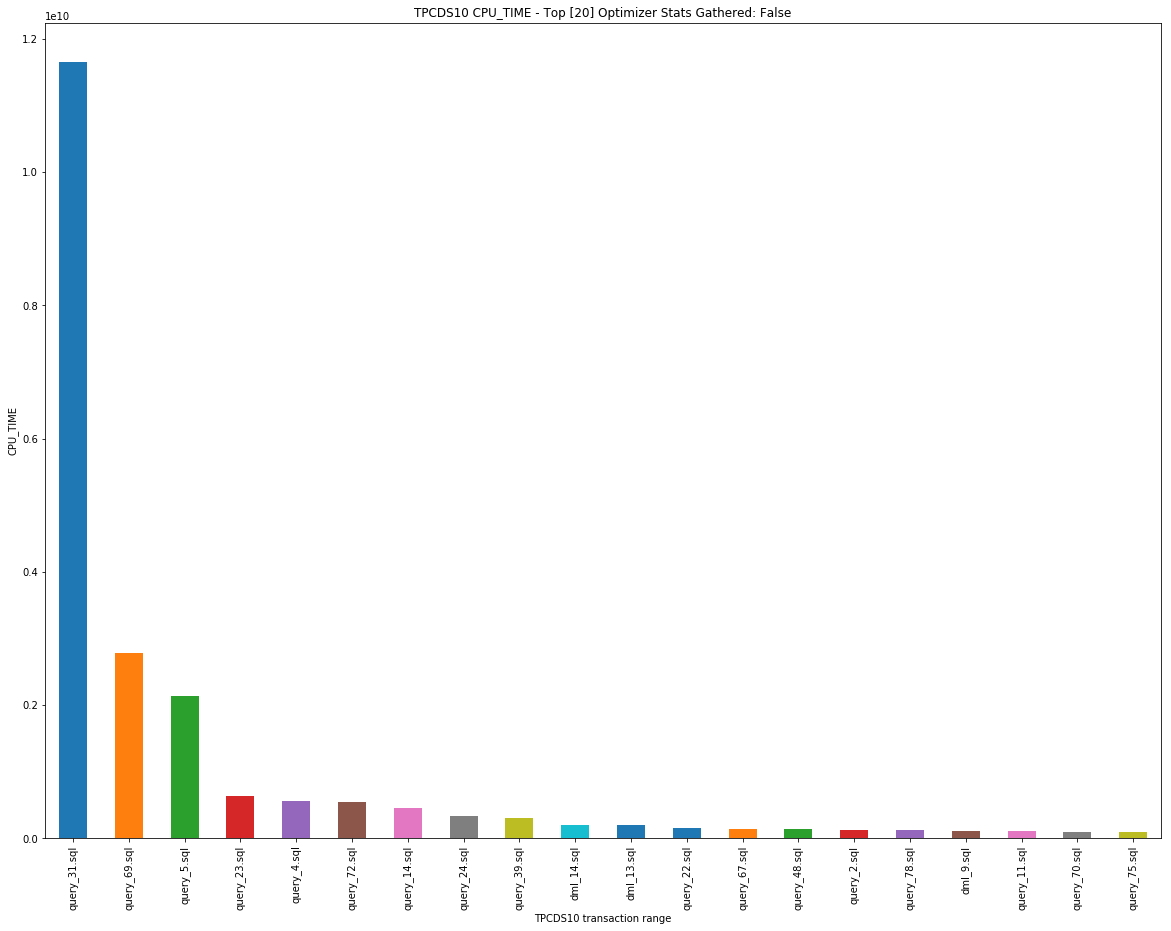

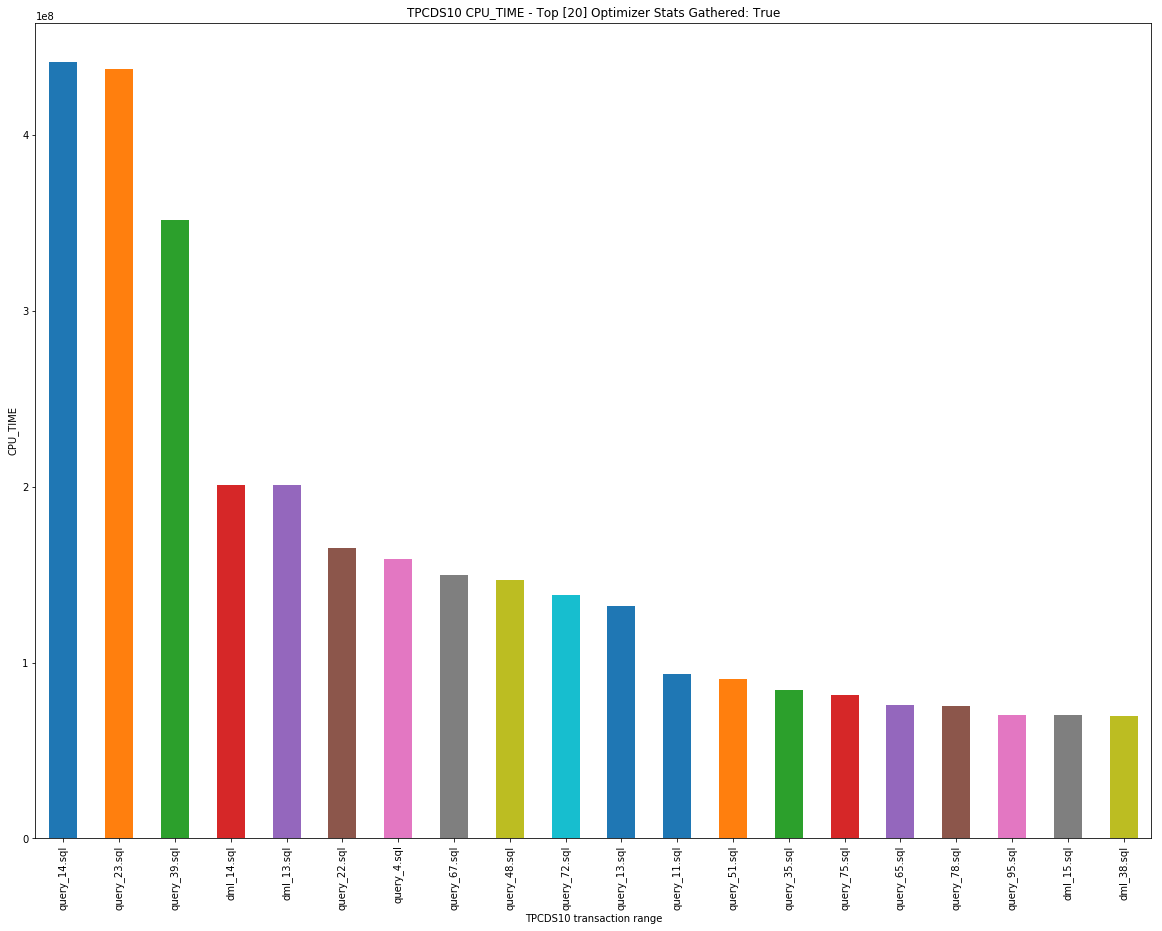

In [51]:
top_consumer_bar(table='rep_execution_plans', column='CPU_TIME', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='CPU_TIME', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Elapsed Time Distribution (Histogram Distribution)

Elapsed time (in microseconds) used by this cursor for parsing, executing, and fetching

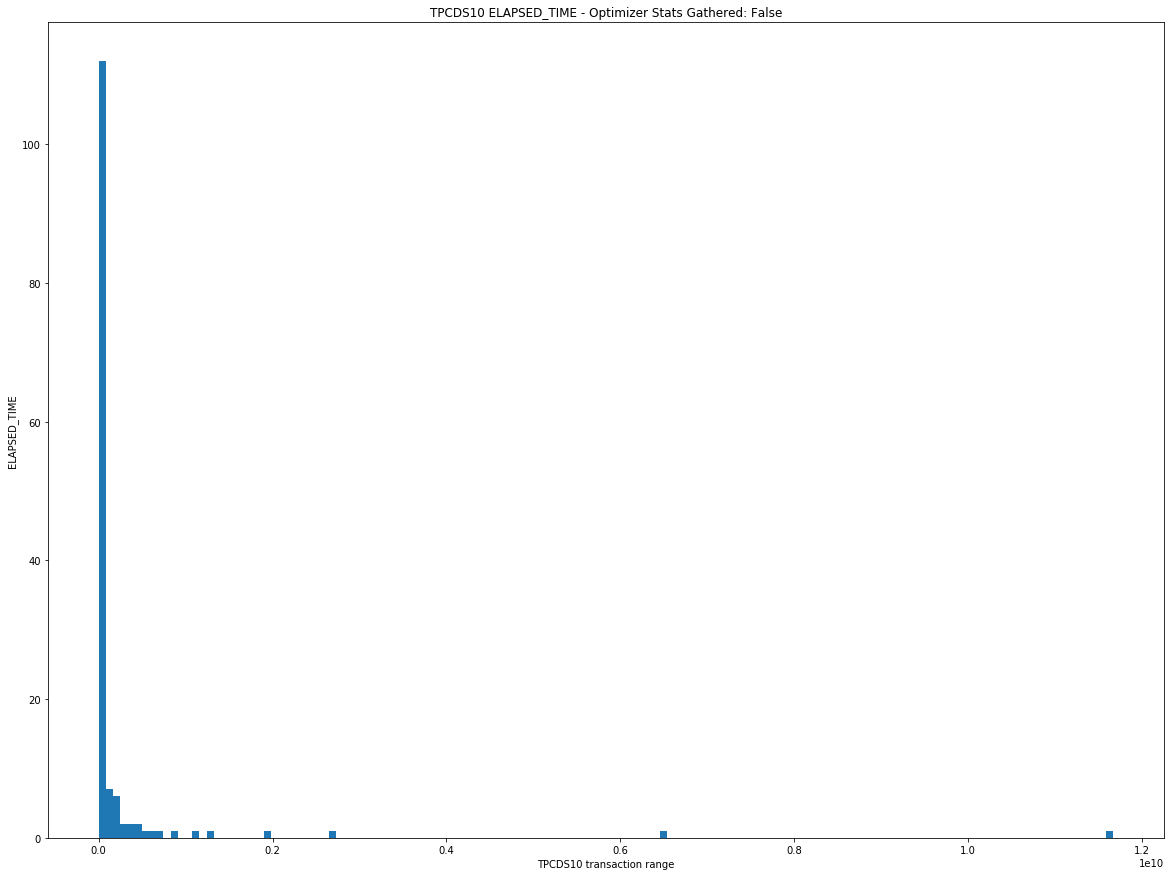

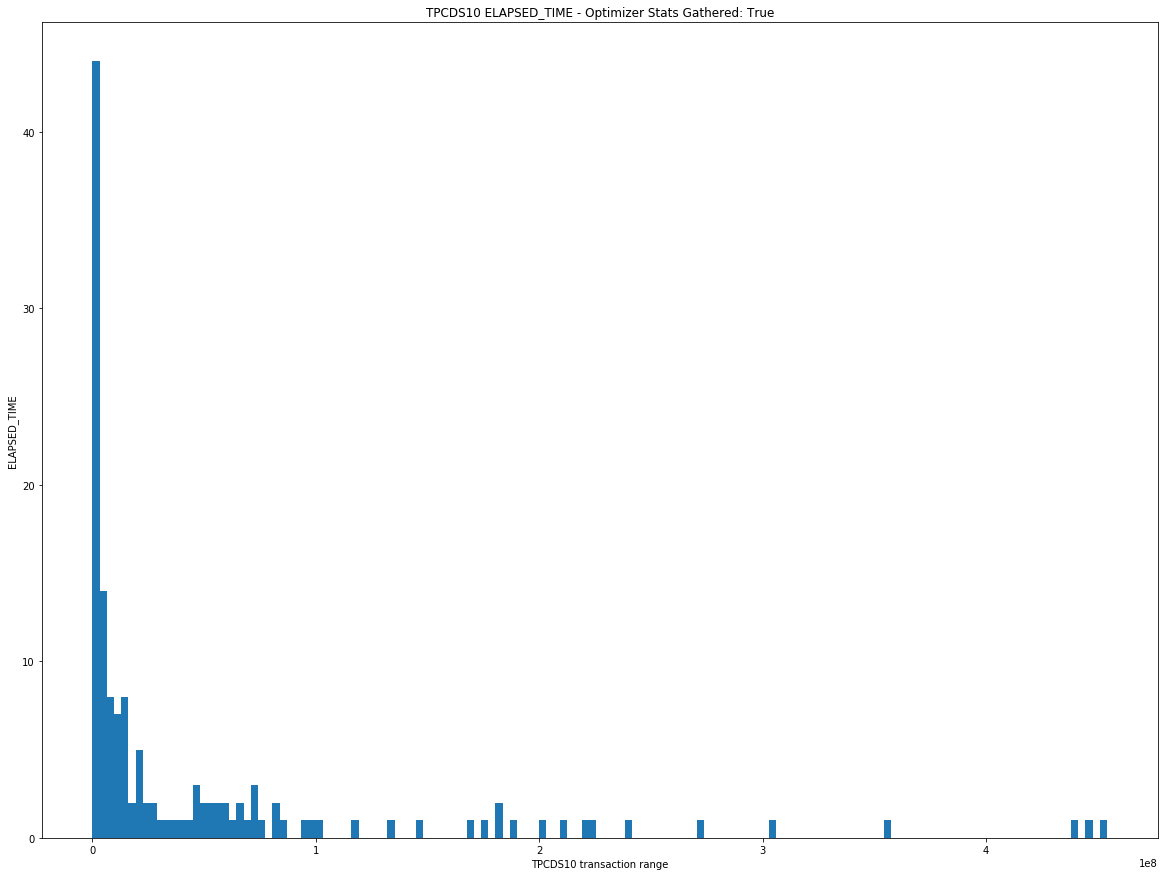

In [52]:
top_consumer_histogram(table='rep_execution_plans', column='ELAPSED_TIME', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='ELAPSED_TIME', tpc_type=tpcds, gathered_stats=True)

### Elapsed Time Distribution (Top 20 Transactions)

Elapsed time (in microseconds) used by this cursor for parsing, executing, and fetching

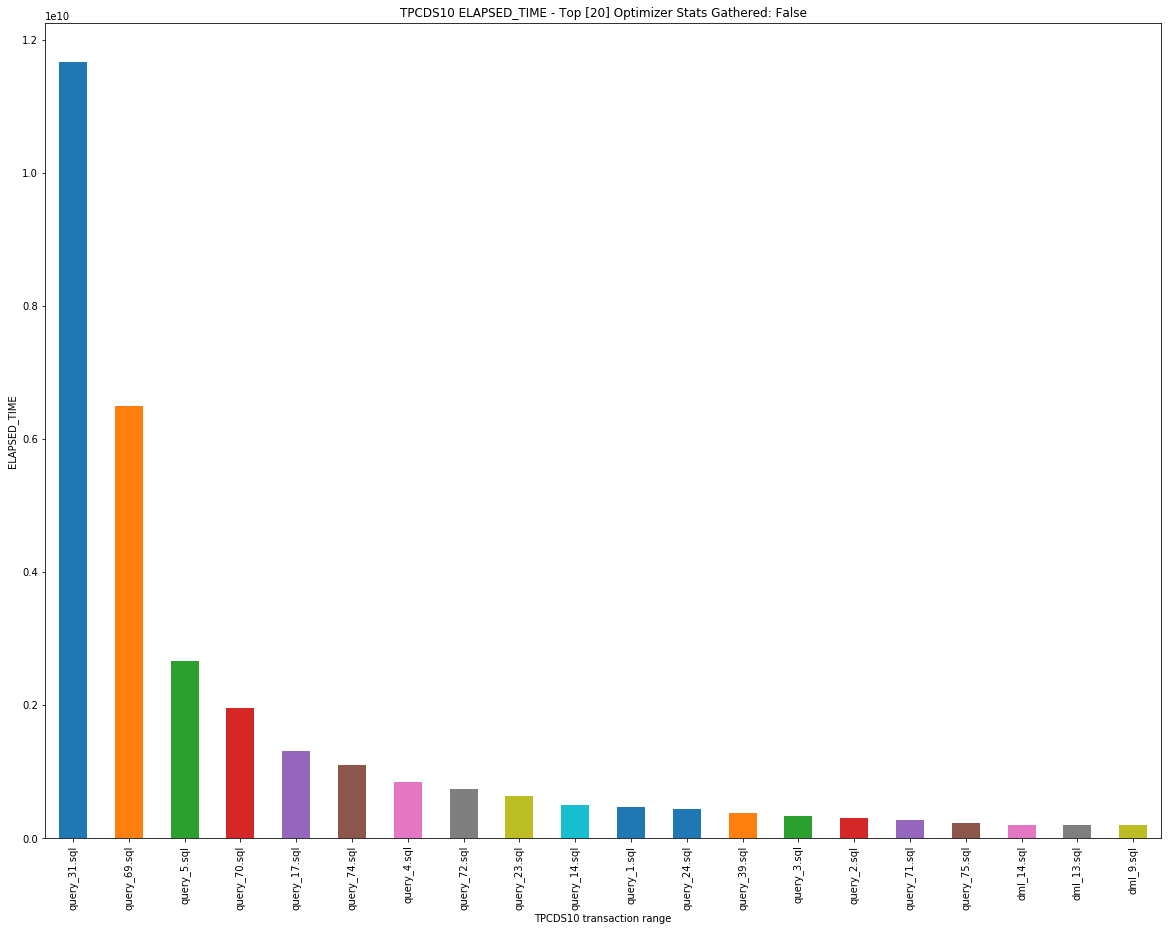

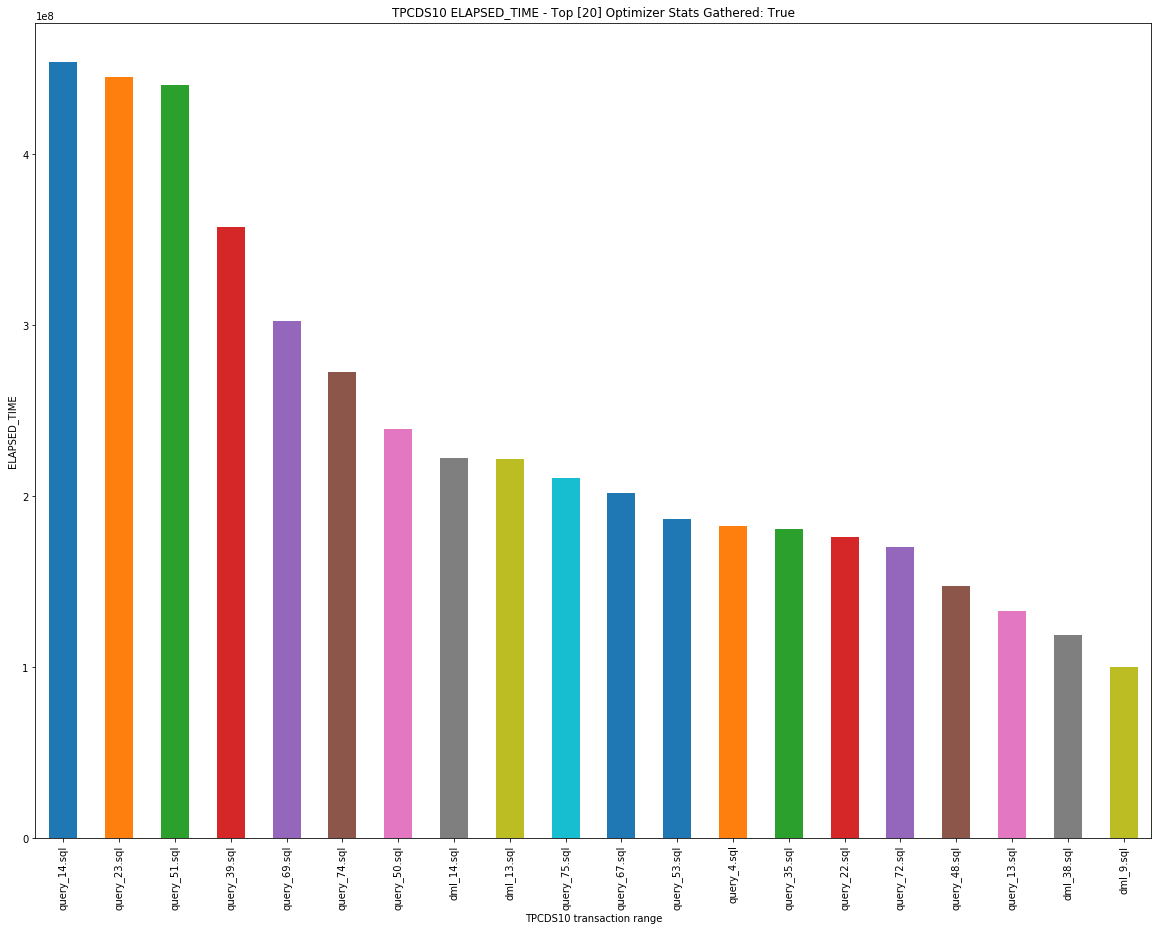

In [53]:
top_consumer_bar(table='rep_execution_plans', column='ELAPSED_TIME', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='ELAPSED_TIME', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Physical Read Requests Distribution (Histogram Distribution)

Number of physical read I/O requests issued by the monitored SQL

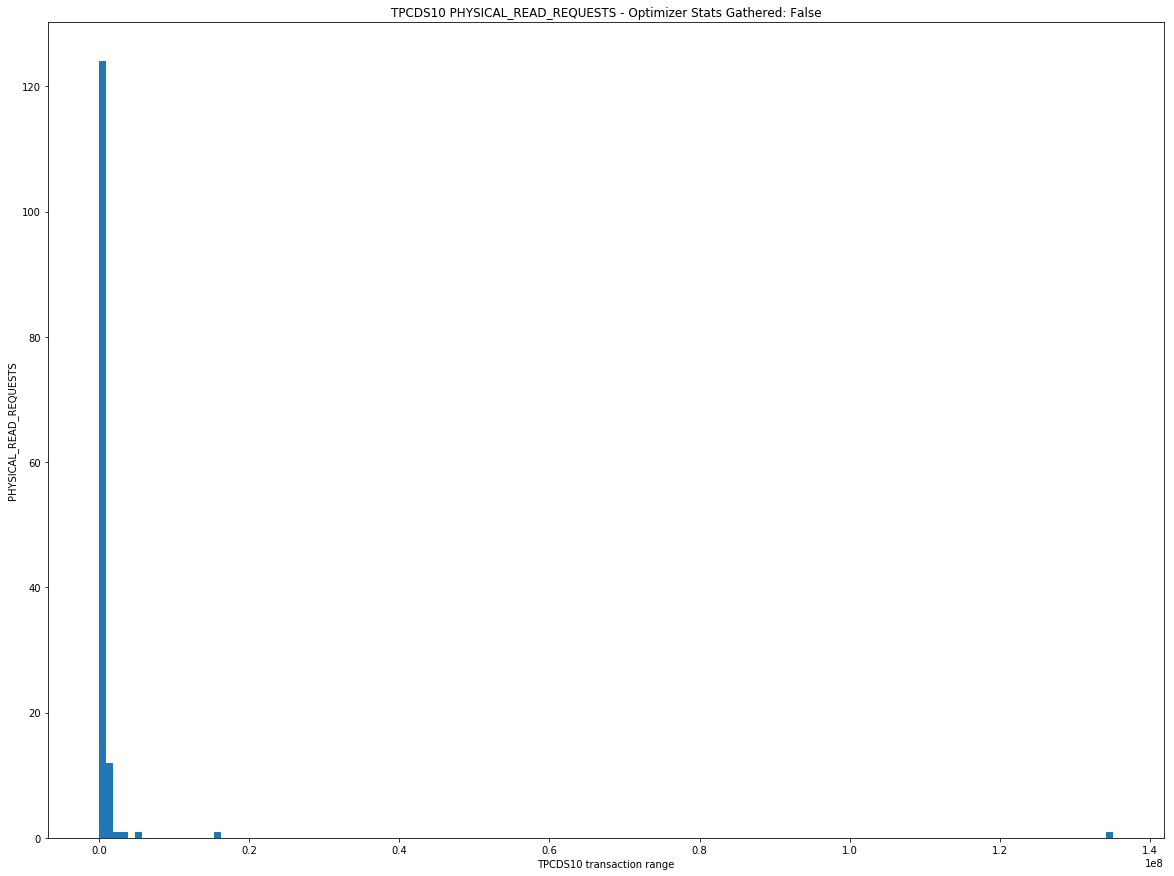

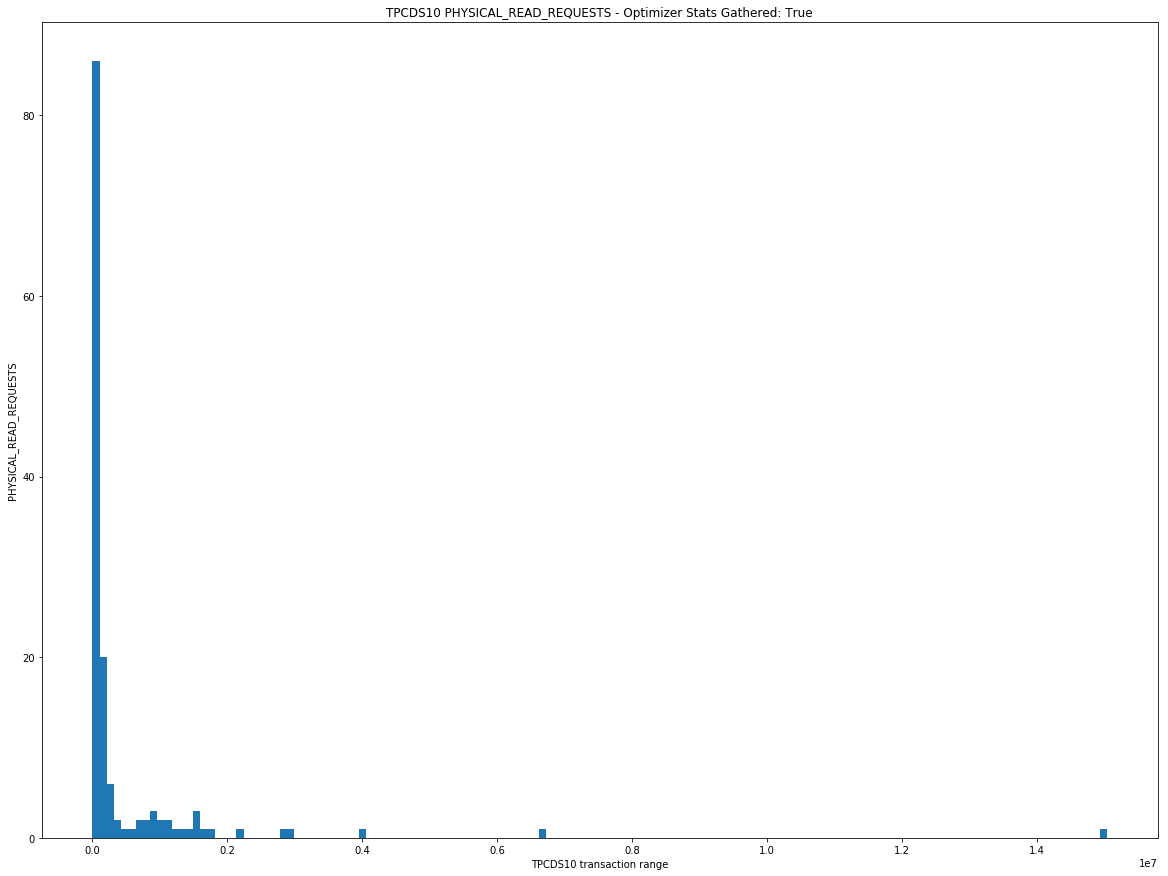

In [54]:
top_consumer_histogram(table='rep_execution_plans', column='PHYSICAL_READ_REQUESTS', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='PHYSICAL_READ_REQUESTS', tpc_type=tpcds, gathered_stats=True)

### Physical Read Requests Distribution (Top 20 Transactions)

Number of physical read I/O requests issued by the monitored SQL

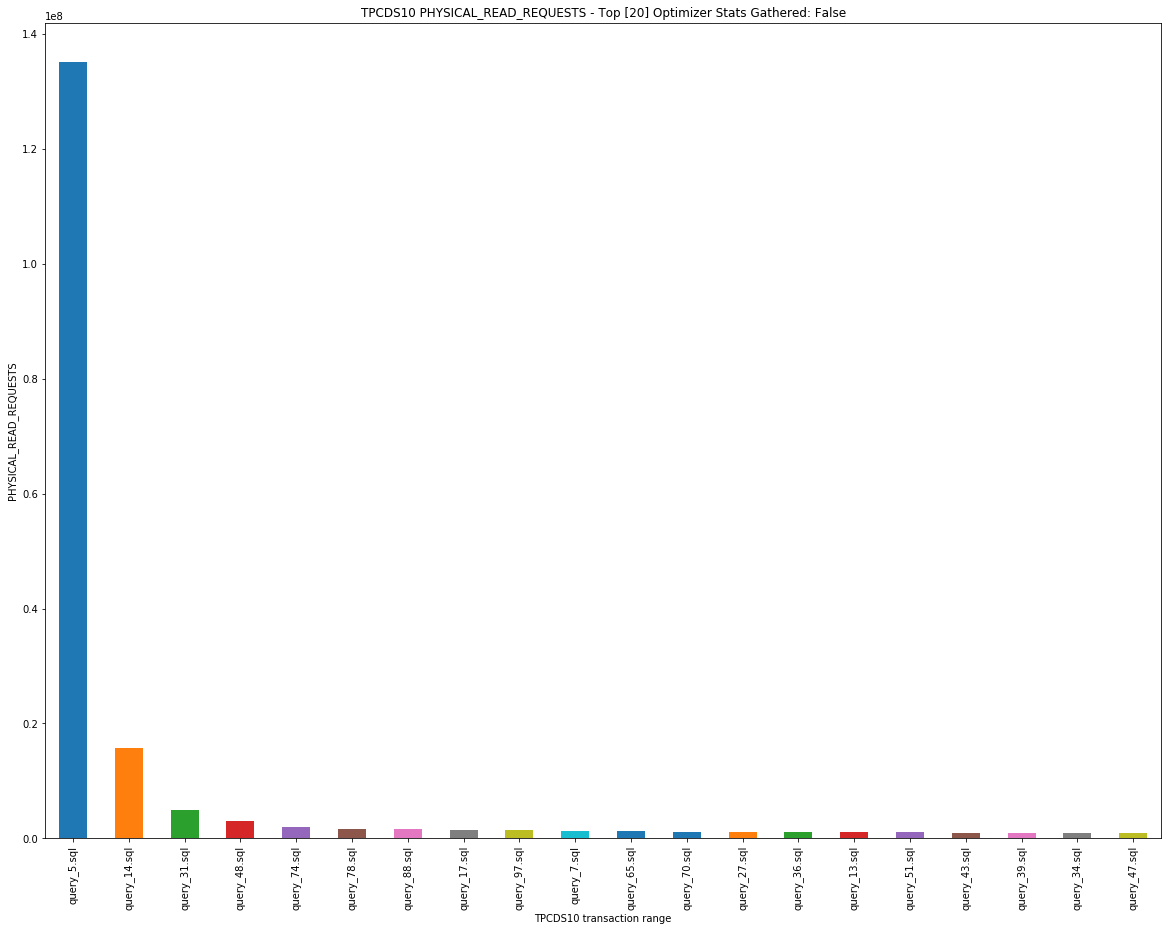

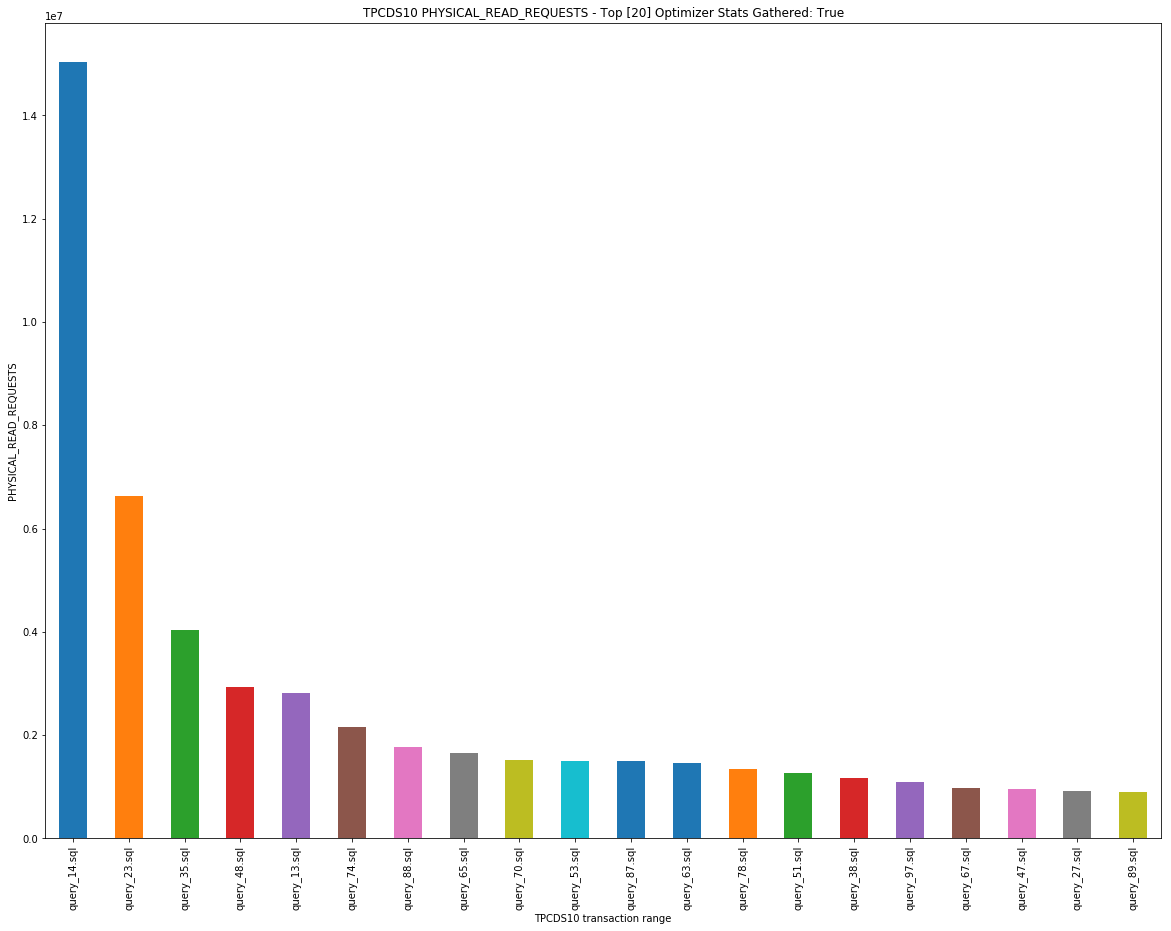

In [55]:
top_consumer_bar(table='rep_execution_plans', column='PHYSICAL_READ_REQUESTS', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='PHYSICAL_READ_REQUESTS', tpc_type=tpcds, gathered_stats=True,top_n=20)

### Physical Write Requests Distribution (Histogram Distribution)

Number of physical write I/O requests issued by the monitored SQL

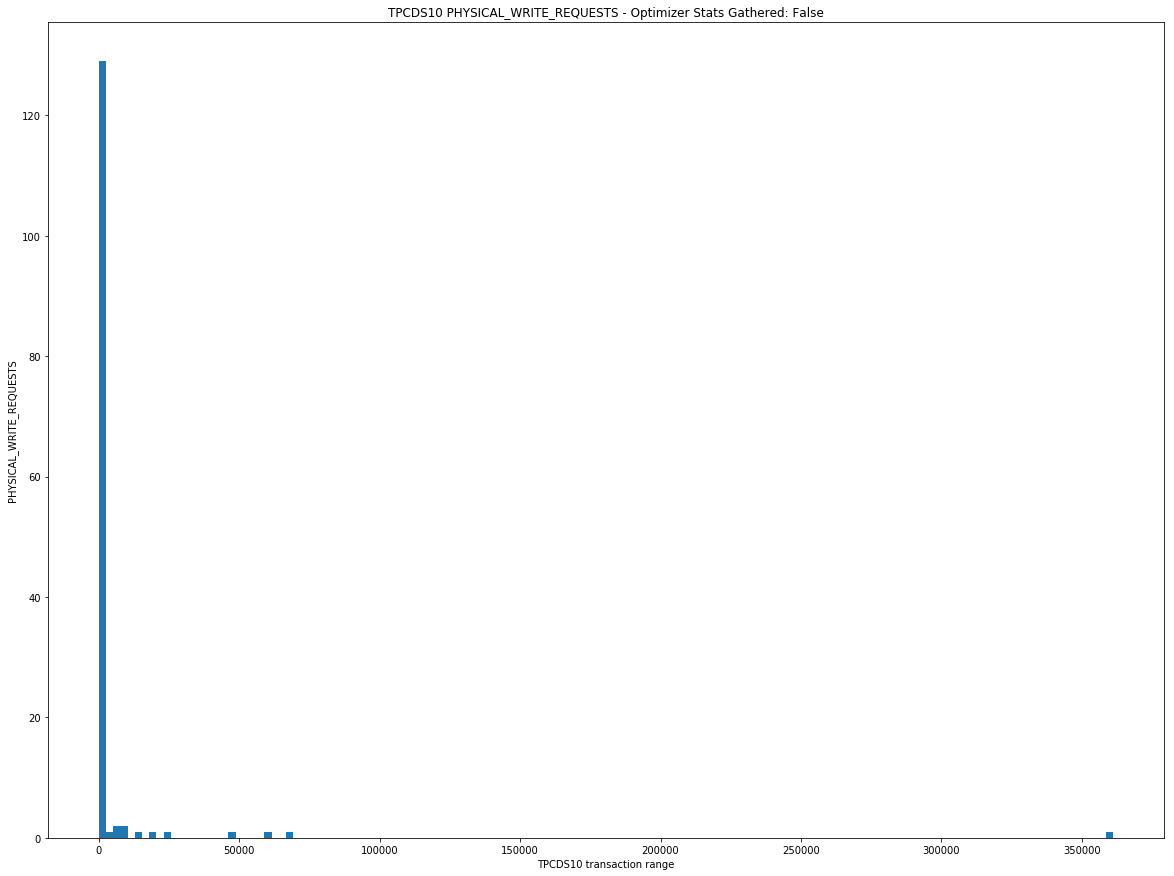

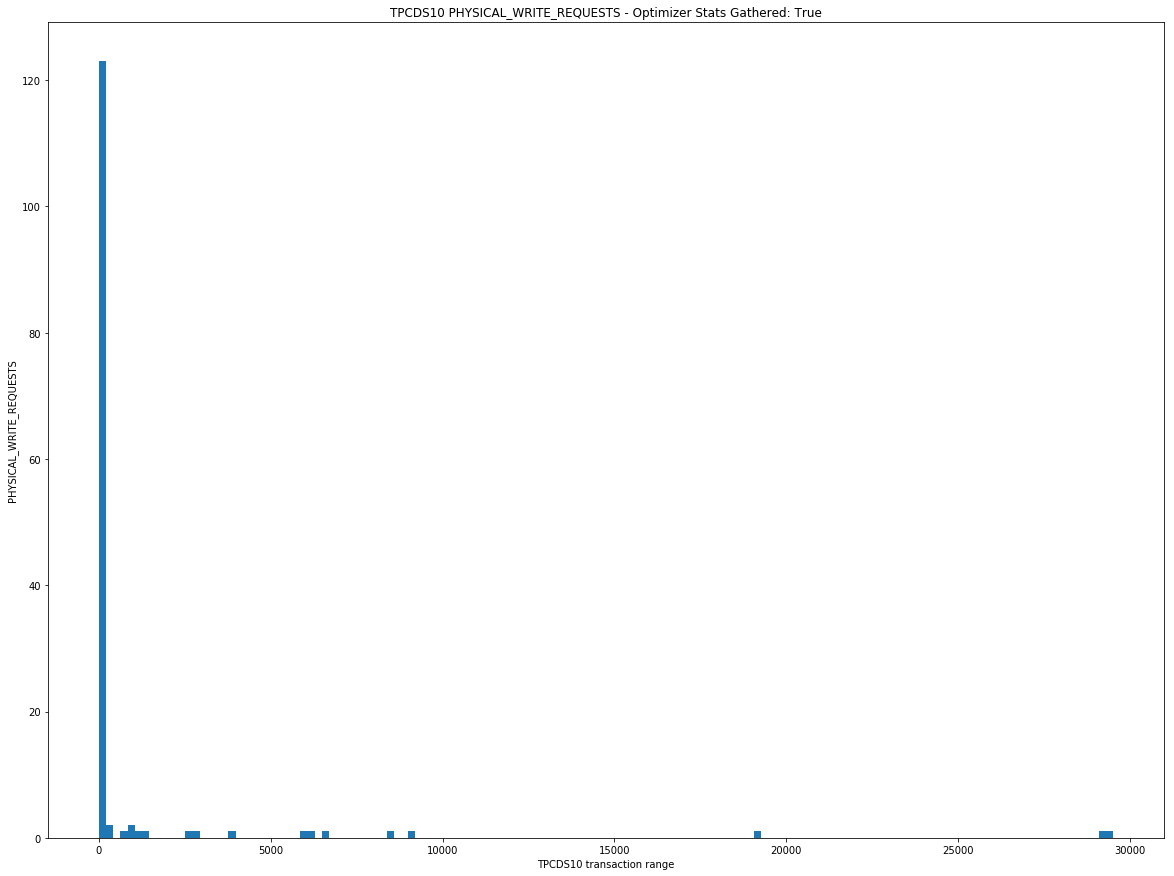

In [56]:
top_consumer_histogram(table='rep_execution_plans', column='PHYSICAL_WRITE_REQUESTS', tpc_type=tpcds, gathered_stats=False)
top_consumer_histogram(table='rep_execution_plans', column='PHYSICAL_WRITE_REQUESTS', tpc_type=tpcds, gathered_stats=True)

### Physical Write Requests Distribution (Top 20 Transactions)

Number of physical write I/O requests issued by the monitored SQL

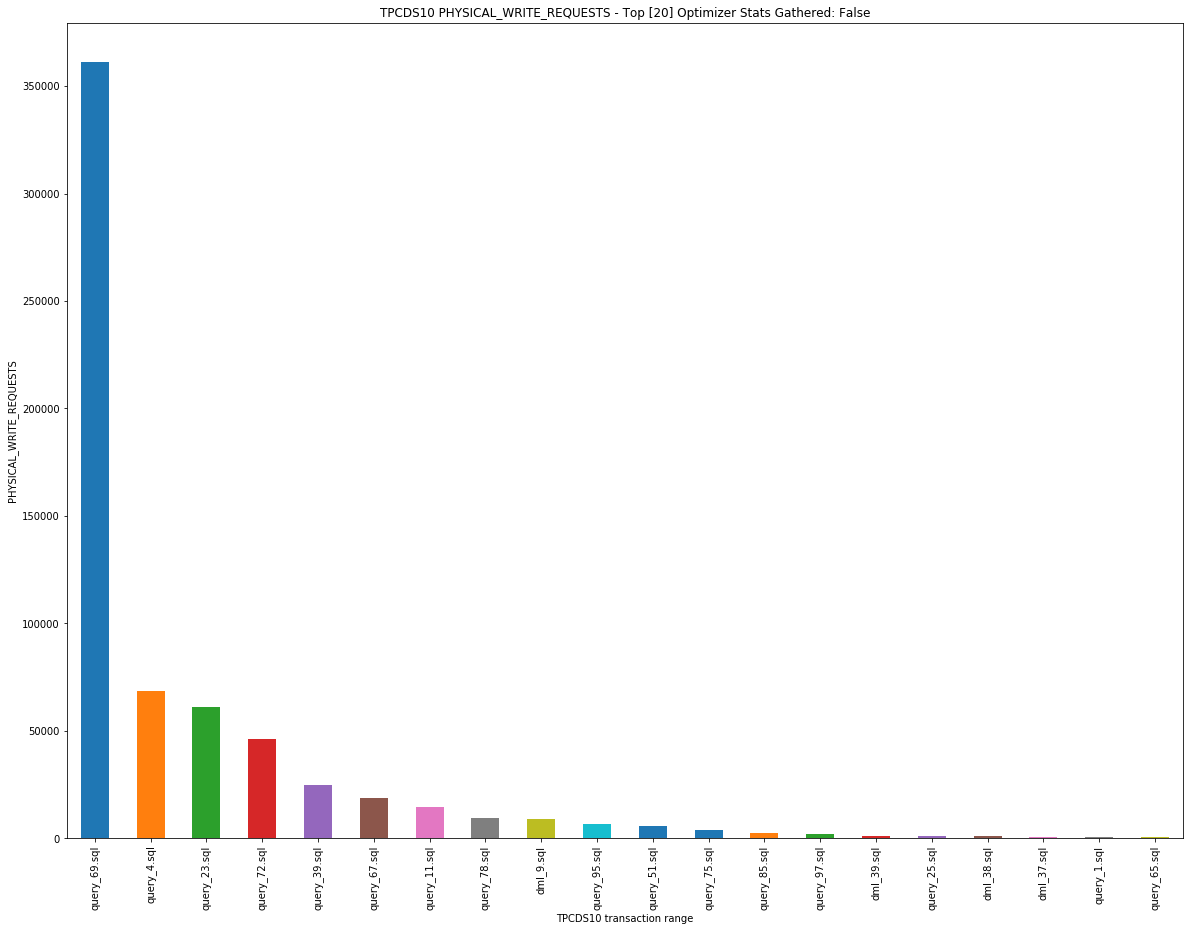

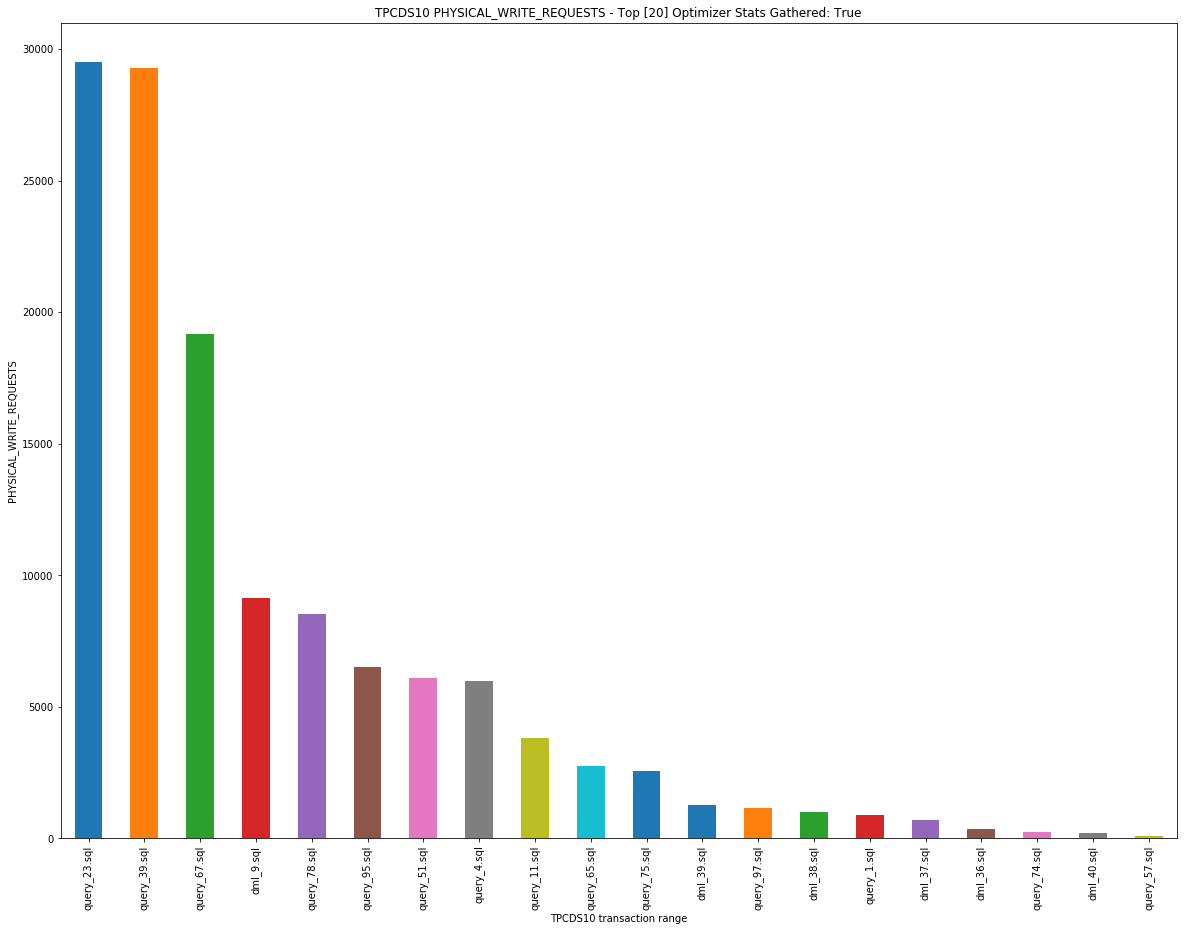

In [57]:
top_consumer_bar(table='rep_execution_plans', column='PHYSICAL_WRITE_REQUESTS', tpc_type=tpcds, gathered_stats=False,top_n=20)
top_consumer_bar(table='rep_execution_plans', column='PHYSICAL_WRITE_REQUESTS', tpc_type=tpcds, gathered_stats=True,top_n=20)